<a href="https://colab.research.google.com/github/bhaskarjyotitamuly/Interpretable-Credit-Risk-Scoring-Model/blob/main/Automobile_Loan_Lending_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### (Make in India: Sector Survey - Automobiles; India on its way to become the primary global automobile manufacturer - Make In India, 2020)

### Developing an interpretable Credit Scoring System for Automobile Loan Lending for the Indian Credit Industry :

### PROLOGUE :
- Since Automobile Credit Lending is one of the key sectors contributing to the overall growth in GDP of India, in this Python Notebook I use a Machine Learning approach to build a new scoring system. 
- This scoring is unique, on the basis that it makes use of CIBIL Score (PERFORM_CNS.SCORE) as well, as one of it's parameters, which is the conventionally followed Credit Scoring System in India.
- The system used to create the scoring is 'Points To Double the Odds' which is one of the most commonly used scoring systems used globally.
- The ML model makes use of LIME (Locally Interpretable Model Agnostic Explanations) for explaining the default probabilities assigned to the various individuals based on the model used.

### Data :
The data has been obtained from 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! pip install lime

     |████████████████████████████████| 276kB 5.7MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=a34c19ce55f419d9ed1b5c63ced49164c59ebbd18b3e9a550be616097b255c75
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [3]:
import pandas as pd
import numpy as np
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split
#from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier,plot_importance

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,f1_score,roc_auc_score,precision_score,recall_score,roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import tensorflow as tf

import lime,lime.lime_tabular

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
pd.set_option('max_columns',50)

In [5]:
data = pd.read_csv('/content/gdrive/MyDrive/L&T Vehicle Loan - train.csv')
diction = pd.read_csv('/content/gdrive/MyDrive/L&T Vehicle Loan - dictionary.csv')
data.head(10)

UniqueID  disbursed_amount  asset_cost    ltv  branch_id  supplier_id  \
0    420825             50578       58400  89.55         67        22807   
1    537409             47145       65550  73.23         67        22807   
2    417566             53278       61360  89.63         67        22807   
3    624493             57513       66113  88.48         67        22807   
4    539055             52378       60300  88.39         67        22807   
5    518279             54513       61900  89.66         67        22807   
6    529269             46349       61500  76.42         67        22807   
7    510278             43894       61900  71.89         67        22807   
8    490213             53713       61973  89.56         67        22807   
9    510980             52603       61300  86.95         67        22807   

   manufacturer_id  Current_pincode_ID Date.of.Birth Employment.Type  \
0               45                1441      01-01-84        Salaried   
1               45                1502      31-07-85   Self employed   
2               45                1497      24-08-85   Self employed   
3               45                1501      30-12-93   Self employed   
4               45                1495      09-12-77   Self employed   
5               45                1501      08-09-90   Self employed   
6               45                1502      01-06-88        Salaried   
7               45                1501      04-10-89        Salaried   
8               45                1497      15-11-91   Self employed   
9               45                1492      01-06-68        Salaried   

  DisbursalDate  State_ID  Employee_code_ID  MobileNo_Avl_Flag  Aadhar_flag  \
0      03-08-18         6              1998                  1            1   
1      26-09-18         6              1998                  1            1   
2      01-08-18         6              1998                  1            1   
3      26-10-18         6              1998                  1            1   
4      26-09-18         6              1998                  1            1   
5      19-09-18         6              1998                  1            1   
6      23-09-18         6              1998                  1            1   
7      16-09-18         6              1998                  1            1   
8      05-09-18         6              1998                  1            1   
9      16-09-18         6              1998                  1            0   

   PAN_flag  VoterID_flag  Driving_flag  Passport_flag  PERFORM_CNS.SCORE  \
0         0             0             0              0                  0   
1         0             0             0              0                598   
2         0             0             0              0                  0   
3         0             0             0              0                305   
4         0             0             0              0                  0   
5         0             0             0              0                825   
6         0             0             0              0                  0   
7         0             0             0              0                 17   
8         0             0             0              0                718   
9         0             1             0              0                818   

                       PERFORM_CNS.SCORE.DESCRIPTION  PRI.NO.OF.ACCTS  \
0                        No Bureau History Available                0   
1                                      I-Medium Risk                1   
2                        No Bureau History Available                0   
3                                   L-Very High Risk                3   
4                        No Bureau History Available                0   
5                                    A-Very Low Risk                2   
6                        No Bureau History Available                0   
7  Not Scored: Not Enough Info available on the c...                1  

In [6]:
data.shape

(233154, 41)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Date.of.Birth                        233154 non-null  object 
 9   Employment.Type                      225493 non-null  object 
 10  DisbursalDate                        233154 non-null  object 
 11  State_ID     

In [8]:
data.UniqueID.describe()

count    233154.000000
mean     535917.573376
std       68315.693711
min      417428.000000
25%      476786.250000
50%      535978.500000
75%      595039.750000
max      671084.000000
Name: UniqueID, dtype: float64

In [9]:
data.UniqueID = data.UniqueID.astype('object')

In [10]:
data.UniqueID.describe()

count     233154
unique    233154
top       524287
freq           1
Name: UniqueID, dtype: int64

In [11]:
data.UniqueID.duplicated().sum()

0

### Checking for Data Imbalance :

In [12]:
(data['loan_default'].value_counts()/data.shape[0])*100

0    78.292888
1    21.707112
Name: loan_default, dtype: float64

#### So we see that the percentage difference between the loan defaulters and non-defaulters is not unmanageably high. So,we'll check the final results both with balancing,as well as without.

In [13]:
pd.set_option('max_colwidth',500)

In [14]:
# Coming to the data dictionary now :
diction

Unnamed: 0                        Variable Name  \
0            0                             UniqueID   
1            1                         loan_default   
2            2                     disbursed_amount   
3            3                           asset_cost   
4            4                                  ltv   
5            5                            branch_id   
6            6                          supplier_id   
7            7                      manufacturer_id   
8            8                      Current_pincode   
9            9                        Date.of.Birth   
10          10                      Employment.Type   
11          11                        DisbursalDate   
12          12                             State_ID   
13          13                     Employee_code_ID   
14          14                    MobileNo_Avl_Flag   
15          15                          Aadhar_flag   
16          16                             PAN_flag   
17          17                         VoterID_flag   
18          18                         Driving_flag   
19          19                        Passport_flag   
20          20                    PERFORM_CNS.SCORE   
21          21        PERFORM_CNS.SCORE.DESCRIPTION   
22          22                      PRI.NO.OF.ACCTS   
23          23                     PRI.ACTIVE.ACCTS   
24          24                    PRI.OVERDUE.ACCTS   
25          25                  PRI.CURRENT.BALANCE   
26          26                PRI.SANCTIONED.AMOUNT   
27          27                 PRI.DISBURSED.AMOUNT   
28          28                      SEC.NO.OF.ACCTS   
29          29                     SEC.ACTIVE.ACCTS   
30          30                    SEC.OVERDUE.ACCTS   
31          31                  SEC.CURRENT.BALANCE   
32          32                SEC.SANCTIONED.AMOUNT   
33          33                 SEC.DISBURSED.AMOUNT   
34          34                   PRIMARY.INSTAL.AMT   
35          35                       SEC.INSTAL.AMT   
36          36         NEW.ACCTS.IN.LAST.SIX.MONTHS   
37          37  DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS   
38          38                     AVERAGE.ACCT.AGE   
39          39                CREDIT.HISTORY.LENGTH   
40          40                      NO.OF_INQUIRIES   

                                                                           Description  \
0                                                             Identifier for customers   
1                                         Payment default in the first EMI on due date   
2                                                             Amount of Loan disbursed   
3                                                                    Cost of the Asset   
4                                                           Loan to Value of the asset   
5                                                  Branch where the loan was disbursed   
6                                          Vehicle Dealer where the loan was disbursed   
7                                          Vehicle manufacturer(Hero, Honda, TVS etc.)   
8                                                      Current pincode of the customer   
9                                                        Date of birth of the customer   
10                            Employment Type of the customer (Salaried/Self Employed)   
11                                                                Date of disbursement   
12                                                               State of disbursement   
13                            Employee of the organization who logged the disbursement   
14                          if Mobile no. was shared by the customer then flagged as 1   
15                              if aadhar was shared by the customer then flagged as 1   
16                                 if pan was shared by the customer then flagged as 1   
17                              if voter  was shared by the customer then

In [15]:
data.dtypes

UniqueID                                object
disbursed_amount                         int64
asset_cost                               int64
ltv                                    float64
branch_id                                int64
supplier_id                              int64
manufacturer_id                          int64
Current_pincode_ID                       int64
Date.of.Birth                           object
Employment.Type                         object
DisbursalDate                           object
State_ID                                 int64
Employee_code_ID                         int64
MobileNo_Avl_Flag                        int64
Aadhar_flag                              int64
PAN_flag                                 int64
VoterID_flag                             int64
Driving_flag                             int64
Passport_flag                            int64
PERFORM_CNS.SCORE                        int64
PERFORM_CNS.SCORE.DESCRIPTION           object
PRI.NO.OF.ACC

In [16]:
pd.set_option('max_rows',500)

### Exploratory Data Analysis :

#### Before making any changes to the original data,we'll keep a copy of that data as it is for future reference:

In [17]:
data_original = data.copy()

### 1) Making necessary changes to the features of existing data :

### Removing redundant/ambiguous features :
'branch_id','supplier_id',and 'Employee_code_ID','Current_pincode_ID','State_ID' are features solely useful for the lending and manufacturing Company's internal usage. So we'll remove them : 

In [18]:
#data = data.drop(['branch_id','supplier_id','Employee_code_ID','Current_pincode_ID','State_ID'],axis=1)
data = data.drop(['branch_id','supplier_id','Employee_code_ID','Current_pincode_ID'],axis=1) # Checking if 'State_ID' has any correlation to the other variables.

In [19]:
data.shape

(233154, 37)

#### 'State_ID' can be dropped,as the states in which the loans were disbursed will not be of significance for determining the default behaviour of customers.Also we'll drop the pincodes of each unique customer as of now,as it doesn't seem relevant or can't be made relevant.

In [20]:
data_new = data.drop(['MobileNo_Avl_Flag','Aadhar_flag','PAN_flag','VoterID_flag','Driving_flag','Passport_flag'],axis=1)

In [21]:
data_new.shape

(233154, 31)

### Changing the columns to required datatypes :

In [22]:
# Checking all the specifications and versions of the current system and packages in use :
pd.show_versions()

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)



INSTALLED VERSIONS
------------------
commit           : b5958ee1999e9aead1938c0bba2b674378807b3d
python           : 3.7.10.final.0
python-bits      : 64
OS               : Linux
OS-release       : 4.19.112+
Version          : #1 SMP Thu Jul 23 08:00:38 PDT 2020
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.1.5
numpy            : 1.19.5
pytz             : 2018.9
dateutil         : 2.8.1
pip              : 19.3.1
setuptools       : 56.1.0
Cython           : 0.29.22
pytest           : 3.6.4
hypothesis       : None
sphinx           : 1.8.5
blosc            : None
feather          : 0.4.1
xlsxwriter       : None
lxml.etree       : 4.2.6
html5lib         : 1.0.1
pymysql          : None
psycopg2         : 2.7.6.1 (dt dec pq3 ext lo64)
jinja2           : 2.11.3
IPython          : 5.5.0
pandas_datareader: 0.9.0
bs4              : 4.6.3
bottleneck       : 

In [23]:
data_new[['Date.of.Birth','DisbursalDate']] = data_new[['Date.of.Birth','DisbursalDate']].apply(pd.to_datetime)

In [24]:
data_new[['Date.of.Birth','DisbursalDate']].head(20)

Date.of.Birth DisbursalDate
0     1984-01-01    2018-03-08
1     1985-07-31    2018-09-26
2     1985-08-24    2018-01-08
3     1993-12-30    2018-10-26
4     1977-09-12    2018-09-26
5     1990-08-09    2018-09-19
6     1988-01-06    2018-09-23
7     1989-04-10    2018-09-16
8     1991-11-15    2018-05-09
9     2068-01-06    2018-09-16
10    1979-01-01    2018-09-29
11    1984-07-09    2018-03-09
12    1974-01-06    2018-08-30
13    1984-08-16    2018-08-30
14    1973-02-18    2018-08-31
15    1994-05-07    2018-10-22
16    1976-01-06    2018-09-18
17    1983-02-27    2018-09-20
18    1988-10-08    2018-06-09
19    1980-04-16    2018-11-10

In [25]:
data_new[data_new['Date.of.Birth'] > data_new['DisbursalDate']]

UniqueID  disbursed_amount  asset_cost    ltv  manufacturer_id  \
9        510980             52603       61300  86.95               45   
26       440293             53713       61780  89.83               45   
29       519075             54513       61900  89.66               45   
32       501823             57259       70100  82.74               45   
40       557071             51303       66450  78.25               45   
...         ...               ...         ...    ...              ...   
233123   602689             73623      105626  71.01              120   
233128   607646             57259       73914  79.15              120   
233130   450782             60447       78437  79.04              120   
233143   626823             61213       89708  69.11               48   
233144   613161             56059       69001  83.04               86   

       Date.of.Birth Employment.Type DisbursalDate  State_ID  \
9         2068-01-06        Salaried    2018-09-16         6   
26        2068-02-08   Self employed    2018-08-16         6   
29        2069-06-27   Self employed    2018-09-19         6   
32        2066-01-06        Salaried    2018-12-09         6   
40        2069-01-06        Salaried    2018-04-10         6   
...              ...             ...           ...       ...   
233123    2063-11-15        Salaried    2018-10-22        15   
233128    2069-06-04        Salaried    2018-10-23        15   
233130    2064-01-16        Salaried    2018-08-20        15   
233143    2067-01-25   Self employed    2018-10-26         6   
233144    2063-06-15        Salaried    2018-10-24         6   

        PERFORM_CNS.SCORE  \
9                     818   
26                      0   
29                    730   
32                    768   
40                    719   
...                   ...   
233123                  0   
233128                 17   
233130                806   
233143                835   
233144                  0   

                                PERFORM_CNS.SCORE.DESCRIPTION  \
9                                             A-Very Low Risk   
26                                No Bureau History Available   
29                                            D-Very Low Risk   
32                                            B-Very Low Risk   
40                                            D-Very Low Risk   
...                                                       ...   
233123                            No Bureau History Available   
233128  Not Scored: Not Enough Info available on the customer   
233130                                        A-Very Low Risk   
233143                                        A-Very Low Risk   
233144                            No Bureau History Available   

        PRI.NO.OF.ACCTS  PRI.ACTIVE.ACCTS  PRI.OVERDUE.ACCTS  \
9                     1                 0                  0   
26                    0                 0                  0   
29                    5                 3                  0   
32                    7                 3                  0   
40                    5                 2                  0   
...                 ...               ...                ...   
233123                0                 0                  0   
233128                1                 1                  0   
233130                6                 4                  0   
233143                6                 4                  0   
233144                0                 0                  0   

        PRI.CURRENT.BALANCE  PRI.SANCTIONED.AMOUNT  PRI.DISBURSED.AMOUNT  \
9                         0                      0                     0   
26                        0                      0                     0   
29                   101518                 162800                162800   
32                   324323                 604845                604845   
40                     8000                 145000                145000   
...   

In [26]:
data_new_1 = data_new.copy()

#### So we'll keep **data_new** as it is for later comparison,and now instead work on it's copy **data_new_1** .

### New feature creation :

In [27]:
data_new_1.dtypes

UniqueID                                       object
disbursed_amount                                int64
asset_cost                                      int64
ltv                                           float64
manufacturer_id                                 int64
Date.of.Birth                          datetime64[ns]
Employment.Type                                object
DisbursalDate                          datetime64[ns]
State_ID                                        int64
PERFORM_CNS.SCORE                               int64
PERFORM_CNS.SCORE.DESCRIPTION                  object
PRI.NO.OF.ACCTS                                 int64
PRI.ACTIVE.ACCTS                                int64
PRI.OVERDUE.ACCTS                               int64
PRI.CURRENT.BALANCE                             int64
PRI.SANCTIONED.AMOUNT                           int64
PRI.DISBURSED.AMOUNT                            int64
SEC.NO.OF.ACCTS                                 int64
SEC.ACTIVE.ACCTS            

In [28]:
data_new_1['Age'] = data_new_1['DisbursalDate'] - data_new_1['Date.of.Birth']
data_new_1 = data_new_1.drop(['DisbursalDate','Date.of.Birth'],axis=1)
data_new_1['Age'] = data_new_1['Age'].astype(str)
data_new_1['Age'] = data_new_1['Age'].str.strip('days')
data_new_1['Age'] = data_new_1['Age'].astype(int)

In [29]:
data_new_1.head()

UniqueID  disbursed_amount  asset_cost    ltv  manufacturer_id  \
0   420825             50578       58400  89.55               45   
1   537409             47145       65550  73.23               45   
2   417566             53278       61360  89.63               45   
3   624493             57513       66113  88.48               45   
4   539055             52378       60300  88.39               45   

  Employment.Type  State_ID  PERFORM_CNS.SCORE PERFORM_CNS.SCORE.DESCRIPTION  \
0        Salaried         6                  0   No Bureau History Available   
1   Self employed         6                598                 I-Medium Risk   
2   Self employed         6                  0   No Bureau History Available   
3   Self employed         6                305              L-Very High Risk   
4   Self employed         6                  0   No Bureau History Available   

   PRI.NO.OF.ACCTS  PRI.ACTIVE.ACCTS  PRI.OVERDUE.ACCTS  PRI.CURRENT.BALANCE  \
0                0                 0                  0                    0   
1                1                 1                  1                27600   
2                0                 0                  0                    0   
3                3                 0                  0                    0   
4                0                 0                  0                    0   

   PRI.SANCTIONED.AMOUNT  PRI.DISBURSED.AMOUNT  SEC.NO.OF.ACCTS  \
0                      0                     0                0   
1                  50200                 50200                0   
2                      0                     0                0   
3                      0                     0                0   
4                      0                     0                0   

   SEC.ACTIVE.ACCTS  SEC.OVERDUE.ACCTS  SEC.CURRENT.BALANCE  \
0                 0                  0                    0   
1                 0                  0                    0   
2                 0                  0                    0   
3                 0                  0                    0   
4                 0                  0                    0   

   SEC.SANCTIONED.AMOUNT  SEC.DISBURSED.AMOUNT  PRIMARY.INSTAL.AMT  \
0                      0                     0                   0   
1                      0                     0                1991   
2                      0                     0                   0   
3                      0                     0                  31   
4                      0                     0                   0   

   SEC.INSTAL.AMT  NEW.ACCTS.IN.LAST.SIX.MONTHS  \
0               0                             0   
1               0                             0   
2               0                             0   
3               0                             0   
4               0                             0   

   DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS AVERAGE.ACCT.AGE CREDIT.HISTORY.LENGTH  \
0                                    0        0yrs 0mon             0yrs 0mon   
1                                    1       1yrs 11mon            1yrs 11mon   
2                                    0        0yrs 0mon             0yrs 0mon   
3                                    0        0yrs 8mon             1yrs 3mon   
4                                    0        0yrs 0mon             0yrs 0mon   

   NO.OF_INQUIRIES  loan_default    Age  
0                0             0  12485  
1                0             1  12110  
2                0             0  11825  
3                1             1   9066  
4                1             1  14989

#### For 'AVERAGE.ACCT.AGE' :

In [30]:
data_new_1['AVERAGE.ACCT.AGE_months'] = data_new_1['AVERAGE.ACCT.AGE'].str.slice(start = -5)
data_new_1['AVERAGE.ACCT.AGE_years'] = data_new_1['AVERAGE.ACCT.AGE'].str.slice(start = 0,stop = 5)
data_new_1['AVERAGE.ACCT.AGE_months'] = data_new_1['AVERAGE.ACCT.AGE_months'].str.rstrip(' mon')
data_new_1['AVERAGE.ACCT.AGE_years'] = data_new_1['AVERAGE.ACCT.AGE_years'].str.rstrip(' yrs')
data_new_1['AVERAGE.ACCT.AGE_months'] = data_new_1['AVERAGE.ACCT.AGE_months'].astype(int)
data_new_1['AVERAGE.ACCT.AGE_years'] = data_new_1['AVERAGE.ACCT.AGE_years'].astype(int)

In [31]:
# Converting the months and years to days,we get :
data_new_1['AVERAGE.ACCT.AGE_months'] = data_new_1['AVERAGE.ACCT.AGE_months']*30
data_new_1['AVERAGE.ACCT.AGE_years'] = data_new_1['AVERAGE.ACCT.AGE_years']*365
data_new_1['AVERAGE.ACCT.AGE (in days)'] = data_new_1['AVERAGE.ACCT.AGE_months'] + data_new_1['AVERAGE.ACCT.AGE_years']
data_new_1 = data_new_1.drop(['AVERAGE.ACCT.AGE_years','AVERAGE.ACCT.AGE_months','AVERAGE.ACCT.AGE'],axis=1)

#### For 'CREDIT.HISTORY.LENGTH' :

In [32]:
data_new_1['CREDIT.HISTORY.LENGTH_months'] = data_new_1['CREDIT.HISTORY.LENGTH'].str.slice(start = -5)
data_new_1['CREDIT.HISTORY.LENGTH_years'] = data_new_1['CREDIT.HISTORY.LENGTH'].str.slice(start = 0,stop = 5)
data_new_1['CREDIT.HISTORY.LENGTH_months'] = data_new_1['CREDIT.HISTORY.LENGTH_months'].str.rstrip(' mon')
data_new_1['CREDIT.HISTORY.LENGTH_years'] = data_new_1['CREDIT.HISTORY.LENGTH_years'].str.rstrip(' yrs')
data_new_1['CREDIT.HISTORY.LENGTH_months'] = data_new_1['CREDIT.HISTORY.LENGTH_months'].astype(int)
data_new_1['CREDIT.HISTORY.LENGTH_years'] = data_new_1['CREDIT.HISTORY.LENGTH_years'].astype(int)

In [33]:
# Converting the months and years to days,we get :
data_new_1['CREDIT.HISTORY.LENGTH_months'] = data_new_1['CREDIT.HISTORY.LENGTH_months']*30
data_new_1['CREDIT.HISTORY.LENGTH_years'] = data_new_1['CREDIT.HISTORY.LENGTH_years']*365
data_new_1['CREDIT.HISTORY.LENGTH (in days)'] = data_new_1['CREDIT.HISTORY.LENGTH_months'] + data_new_1['CREDIT.HISTORY.LENGTH_years']
data_new_1 = data_new_1.drop(['CREDIT.HISTORY.LENGTH_years','CREDIT.HISTORY.LENGTH_months','CREDIT.HISTORY.LENGTH'],axis=1)

#### Now,we'll try removing features without significant variane,that is,those without adding any significant information :

In [34]:
data_new_1[data_new_1['PRI.SANCTIONED.AMOUNT'] != data_new_1['PRI.DISBURSED.AMOUNT']].shape[0]

13636

In [35]:
data_new_1.shape[0]

233154

In [36]:
str(round(data_new_1[data_new_1['PRI.SANCTIONED.AMOUNT'] != data_new_1['PRI.DISBURSED.AMOUNT']].shape[0]/len(data_new_1),2)*100) + '%'

'6.0%'

#### Thus, since it's varying from the disbursed amount only for 6% of the total cases,it can be concluded that it isn't adding any extra significant information.Thus, it's safe to remove it.

In [37]:
data_new_1[data_new_1['PRI.SANCTIONED.AMOUNT'] != data_new_1['PRI.DISBURSED.AMOUNT']]['loan_default'].value_counts()/data_new_1[data_new_1['PRI.SANCTIONED.AMOUNT'] != data_new_1['PRI.DISBURSED.AMOUNT']].shape[0]

0    0.882297
1    0.117703
Name: loan_default, dtype: float64

In [38]:
data_new_1[data_new_1['PRI.SANCTIONED.AMOUNT'] < data_new_1['PRI.DISBURSED.AMOUNT']].shape

(4266, 30)

In [39]:
data_new_1[data_new_1['PRI.SANCTIONED.AMOUNT'] < data_new_1['PRI.DISBURSED.AMOUNT']]['loan_default'].value_counts()/data_new_1[data_new_1['PRI.SANCTIONED.AMOUNT'] < data_new_1['PRI.DISBURSED.AMOUNT']].shape[0]

0    0.839194
1    0.160806
Name: loan_default, dtype: float64

In [40]:
data_new_1['loan_default'].value_counts()/data_new_1['loan_default'].shape[0]

0    0.782929
1    0.217071
Name: loan_default, dtype: float64

In [41]:
# Dropping the sanctioned amounts
data_new_1 = data_new_1.drop(['PRI.SANCTIONED.AMOUNT','SEC.SANCTIONED.AMOUNT'],axis=1)

### Univariate Analysis of Features :

In [42]:
data_new_1.shape

(233154, 28)

In [43]:
data_new_1.dtypes

UniqueID                                object
disbursed_amount                         int64
asset_cost                               int64
ltv                                    float64
manufacturer_id                          int64
Employment.Type                         object
State_ID                                 int64
PERFORM_CNS.SCORE                        int64
PERFORM_CNS.SCORE.DESCRIPTION           object
PRI.NO.OF.ACCTS                          int64
PRI.ACTIVE.ACCTS                         int64
PRI.OVERDUE.ACCTS                        int64
PRI.CURRENT.BALANCE                      int64
PRI.DISBURSED.AMOUNT                     int64
SEC.NO.OF.ACCTS                          int64
SEC.ACTIVE.ACCTS                         int64
SEC.OVERDUE.ACCTS                        int64
SEC.CURRENT.BALANCE                      int64
SEC.DISBURSED.AMOUNT                     int64
PRIMARY.INSTAL.AMT                       int64
SEC.INSTAL.AMT                           int64
NEW.ACCTS.IN.

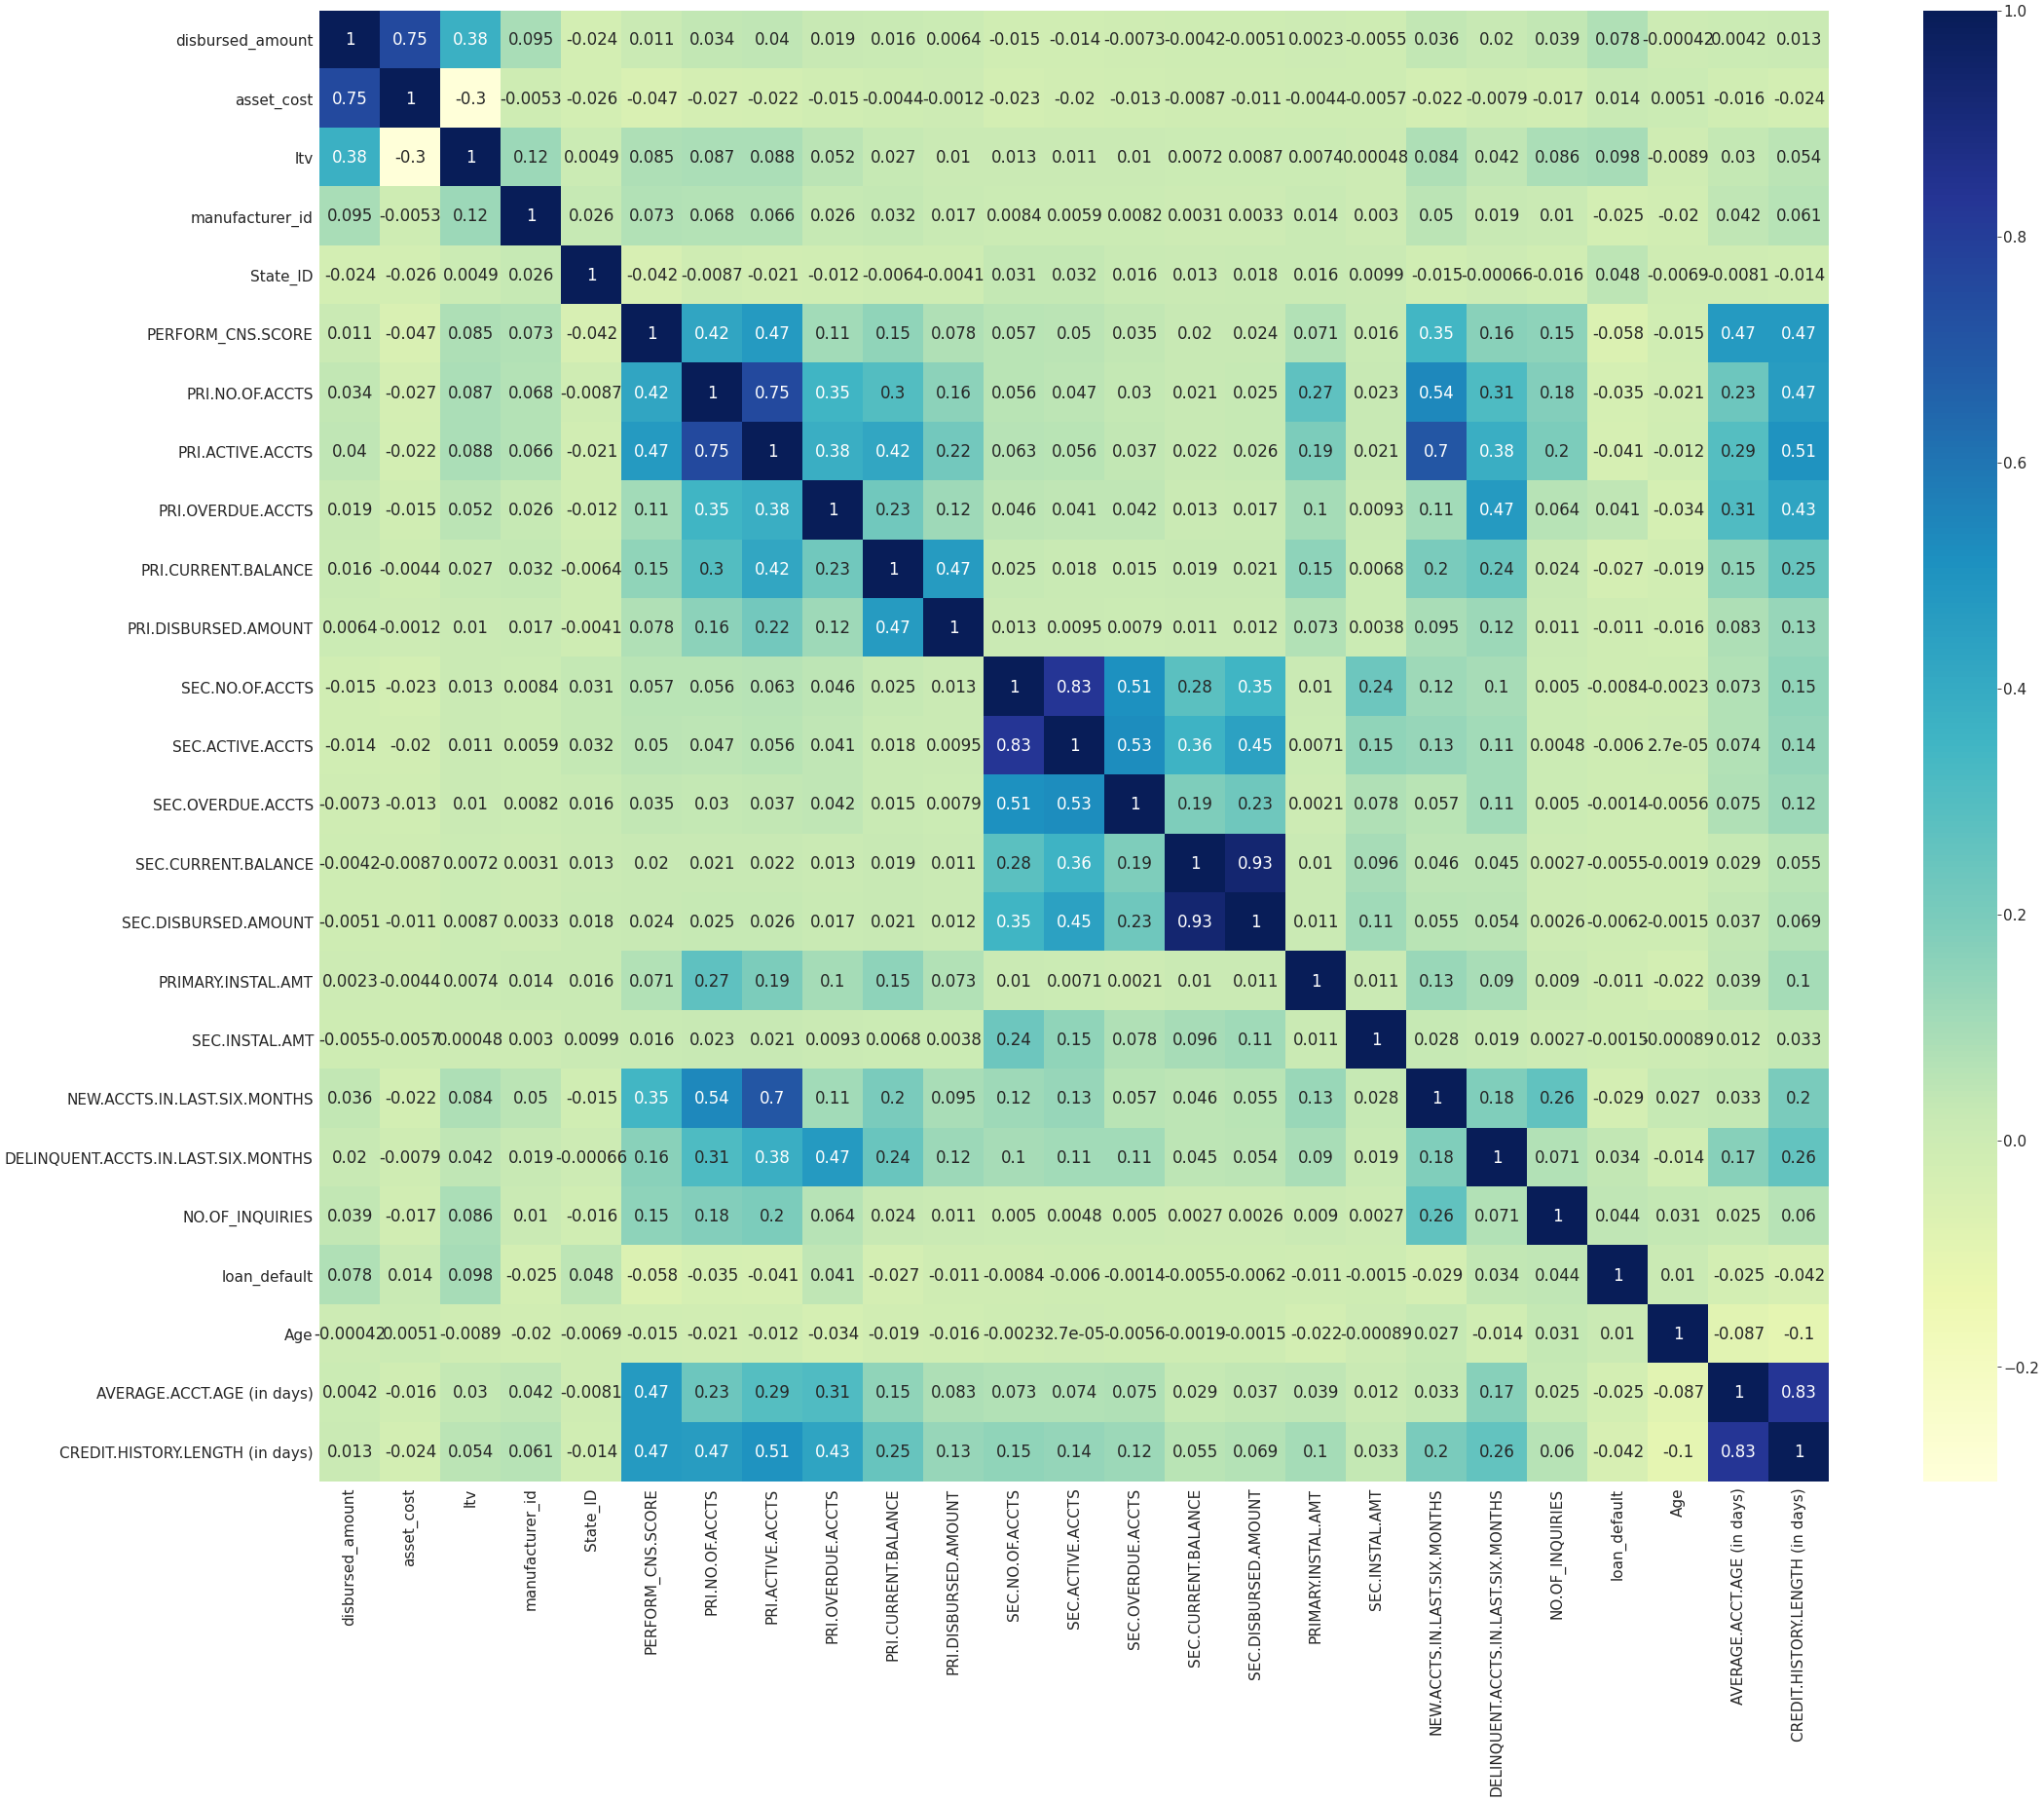

In [44]:
# Plotting a heatmap showing the correlations amongst all the numerical features :
plt.figure(figsize=(50,40),dpi=50)
sns.set(font_scale=2)
sns.heatmap(data_new_1.corr(),cmap='YlGnBu',annot=True)
plt.show()

#### Here 'State_ID' is actually a redundant variable for this analysis,and also it's a categorical variable. But still, we see that it has a negative correlation with PC1, which is the principal component having a high weightage on 'Aadhar' and 'Voter ID',meaning that there is a correlation of being in a particular state with the Aadhar and Voter IDs . However, we'll remove it as it's not needed in our model here.  
#### Also,'manufacturer_id' is a categorical variable, and hence we'll not analyse it in our analysis of numerical features.

In [45]:
data_new_1 = data_new_1.drop(['State_ID'],axis=1)

#### Other than 'UniqueID' and 'Employment.Type' , we also have 'manufacturer_id' which is also a categorical variable. So let's also make it categorical, and do our analysis :

In [46]:
data_new_1['manufacturer_id'] = data_new_1['manufacturer_id'].astype(str)
#data_new_1_cats = data_new_1[['manufacturer_id','Employment.Type']]

### We're beginning our analysis witht the categorical feature with multiple categories, in order to cross check in the end and make sure that all of the categories are preserved even after the outlier treatment. 

### 1) manufacturer_id :

In [47]:
data_new_1['manufacturer_id'].value_counts()

86     109534
45      56626
51      27204
48      16710
49      10220
120      9658
67       2405
145       778
153        12
152         6
156         1
Name: manufacturer_id, dtype: int64

In [48]:
type(data_new_1['manufacturer_id'][0])

str

#### Since ids 153,152 and 156 appear a very minimal number of times, we'll remove all of these cases, as the information added is negligible.

In [49]:
data_new_1 = data_new_1[~data_new_1['manufacturer_id'].str.contains('153|152|156')]

In [ ]:
sns.boxplot(x='manufacturer_id',y='ltv',data=data_new_1)
sns.set(font_scale=1)
plt.show()

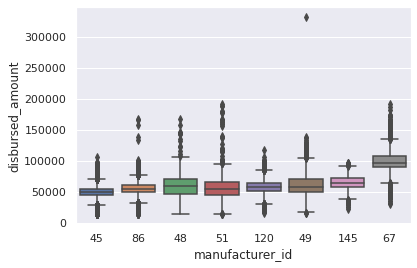

In [51]:
sns.boxplot(x='manufacturer_id',y='disbursed_amount',data=data_new_1)
sns.set(font_scale=1)
plt.show()

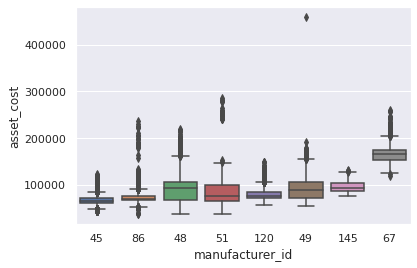

In [52]:
sns.boxplot(x='manufacturer_id',y='asset_cost',data=data_new_1)
sns.set(font_scale=1)
plt.show()

### 2) Employment.Type :

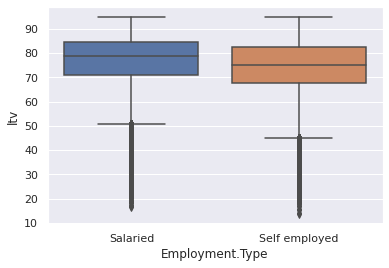

In [53]:
sns.boxplot(x='Employment.Type',y='ltv',data=data_new_1)
sns.set(font_scale=1)
plt.show()

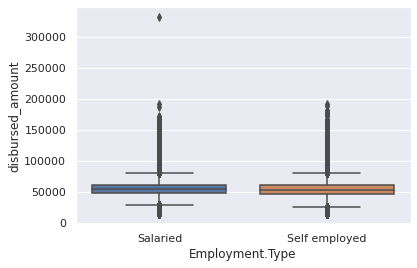

In [54]:
sns.boxplot(x='Employment.Type',y='disbursed_amount',data=data_new_1)
sns.set(font_scale=1)
plt.show()

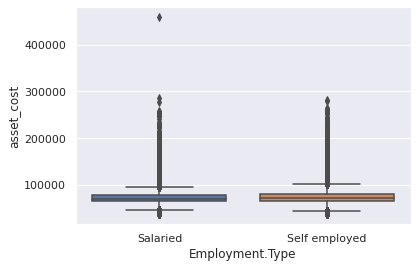

In [55]:
sns.boxplot(x='Employment.Type',y='asset_cost',data=data_new_1)
sns.set(font_scale=1)
plt.show()

#### So clearly the 'Salaried' class is given a higher preference in some extreme cases.

### Moving to the numerical variables now :

In [56]:
data_new_1_nums = data_new_1.select_dtypes(include='number')

In [57]:
data_new_1_nums.shape

(233135, 23)

In [58]:
data_new_1_nums.columns

Index(['disbursed_amount', 'asset_cost', 'ltv', 'PERFORM_CNS.SCORE',
       'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS',
       'PRI.CURRENT.BALANCE', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
       'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'NO.OF_INQUIRIES', 'loan_default', 'Age', 'AVERAGE.ACCT.AGE (in days)',
       'CREDIT.HISTORY.LENGTH (in days)'],
      dtype='object')

In [59]:
data_new_1.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'manufacturer_id',
       'Employment.Type', 'PERFORM_CNS.SCORE', 'PERFORM_CNS.SCORE.DESCRIPTION',
       'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS',
       'PRI.CURRENT.BALANCE', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
       'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'NO.OF_INQUIRIES', 'loan_default', 'Age', 'AVERAGE.ACCT.AGE (in days)',
       'CREDIT.HISTORY.LENGTH (in days)'],
      dtype='object')

#### So out of the 29 variables,we find that 27 of them are numerical.Now,we'll firstly carry out the univariate analysis of these 27 variables :

#### So let's first check the correlations of all these 27 variables,and then analyze these 27 variables one by one :

### 1) disbursed_amount :

In [60]:
data_new_1_nums.shape

(233135, 23)

In [61]:
data_new_1_nums['disbursed_amount'].nunique()

24553

In [62]:
data_new_1_nums.shape

(233135, 23)

#### Thus even though 'disbursed_amount' variable is numerical or quantitative,there are only 24565 unique amounts disbursed,out of a total of 233154 disbursements.Thus,this variable is still categorical in some ways.So let's plot the frequency distribution of the variable like a categorical one :

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 1.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


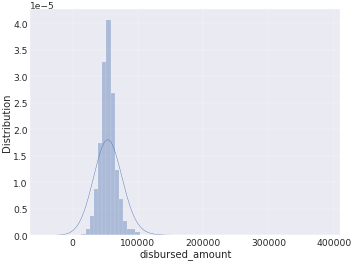

In [63]:
plt.figure(figsize=(20,15),dpi=20)
sns.set(font_scale=3)
sns.distplot(data_new_1_nums['disbursed_amount'],kde_kws = {'bw' : 1.5})
plt.xlabel('disbursed_amount')
plt.ylabel('Distribution')
plt.show() 

No handles with labels found to put in legend.


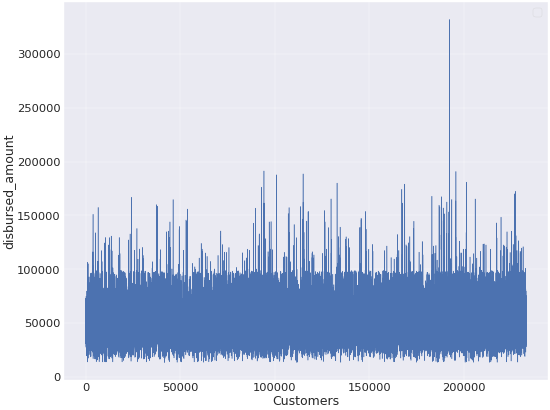

In [64]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['disbursed_amount'])
plt.legend(loc=1)
plt.xlabel('Customers')
plt.ylabel('disbursed_amount')
sns.set(font_scale=2)
plt.show()

In [65]:
# Thus removing the obvious outliers,we get :
data_new_1_nums = data_new_1_nums[data_new_1_nums['disbursed_amount'] <= (0.2*10**6)]
data_new_1 = data_new_1[data_new_1['disbursed_amount'] <= (0.2*10**6)]

No handles with labels found to put in legend.


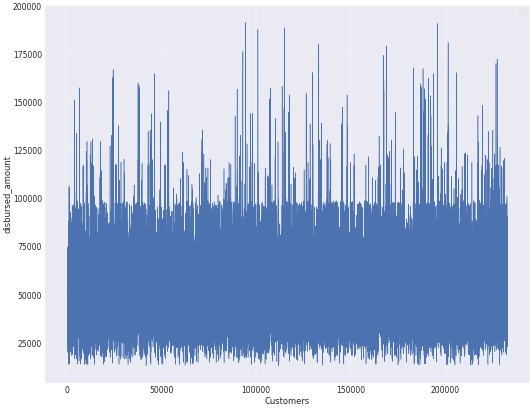

In [66]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['disbursed_amount'])
plt.legend(loc=1)
plt.xlabel('Customers')
plt.ylabel('disbursed_amount')
sns.set(font_scale=2)
plt.show()

In [67]:
print(data_new_1_nums['disbursed_amount'].mean())
print(data_new_1_nums['disbursed_amount'].max())
print(data_new_1_nums['disbursed_amount'].min())
print(data_new_1_nums['disbursed_amount'].median())

54339.918355966955
191392
13320
53803.0


#### Thus we see that as this is a normal curve,most of the loans given out are centered around the mean of Rs.54000 . This brings the following points into light :
- The loans given out by L&T Financial Services for automobile lending in this dataset are mostly only for typical economic Indian 2 wheelers as the range of loans given out are resembling that.However,let's check the variable for outliers as well.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


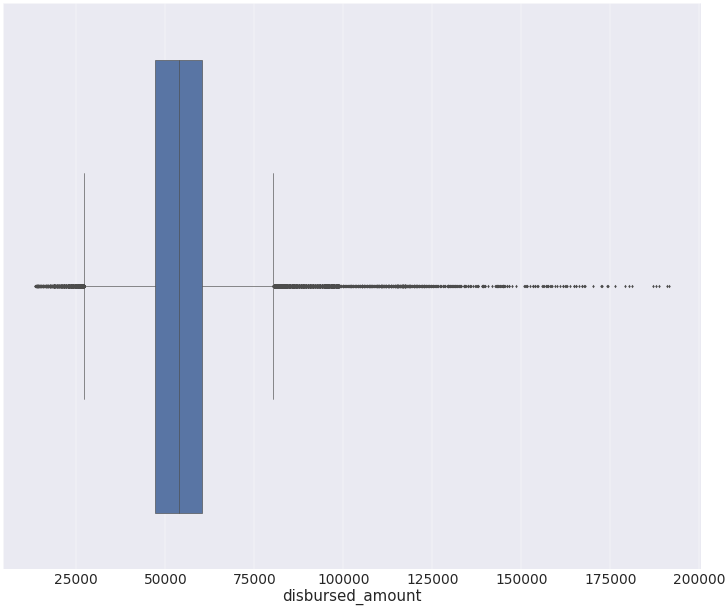

In [68]:
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['disbursed_amount'])
plt.show()

#### Thus we see quite a few outliers on the right hand extreme,that is,way beyond the 75% quantile.We'll not treat these outliers immediately in order to grasp and understand the behaviour of customers in all the buckets of loan amounts.
#### However,there exists 1 or 2 unique outliers which are extremely high close to Rs.10,00,000 (10 lakhs).So,we'll exclude only those few cases.

In [69]:
#Applying Tukey's Rule on variable 'disbursed_amount' :
'''Q1 = data_new_1_nums['disbursed_amount'].quantile(0.25)
Q3 = data_new_1_nums['disbursed_amount'].quantile(0.75)
IQR = Q3 - Q1
# So we'll have to apply this filtration on both 'data_new_1_nums' as well as 'data_new_1' : 
data_new_1_nums = data_new_1_nums[data_new_1_nums['disbursed_amount'] <= (Q3 + 1.5*IQR)]
data_new_1 = data_new_1[data_new_1['disbursed_amount'] <= (Q3 + 1.5*IQR)]'''

"Q1 = data_new_1_nums['disbursed_amount'].quantile(0.25)\nQ3 = data_new_1_nums['disbursed_amount'].quantile(0.75)\nIQR = Q3 - Q1\n# So we'll have to apply this filtration on both 'data_new_1_nums' as well as 'data_new_1' : \ndata_new_1_nums = data_new_1_nums[data_new_1_nums['disbursed_amount'] <= (Q3 + 1.5*IQR)]\ndata_new_1 = data_new_1[data_new_1['disbursed_amount'] <= (Q3 + 1.5*IQR)]"

In [70]:
Q1 = data_new_1_nums['disbursed_amount'].quantile(0.25)
Q2 = data_new_1_nums['disbursed_amount'].quantile(0.50)
Q3 = data_new_1_nums['disbursed_amount'].quantile(0.75)
Q4 = data_new_1_nums['disbursed_amount'].quantile(0.95)
Q5 = data_new_1_nums['disbursed_amount'].quantile(0.99)
Q6 = data_new_1_nums['disbursed_amount'].quantile(0.995)
Q7 = data_new_1_nums['disbursed_amount'].quantile(0.998)
print(Q1)
print(Q2)
print(Q3)
print(Q4)
print(Q5)
print(Q6)
print(Q7)

47145.0
53803.0
60413.0
74079.0
95391.0
97799.0
115418.0


In [71]:
data_new_1_nums = data_new_1_nums[data_new_1_nums['disbursed_amount'] <= data_new_1_nums['disbursed_amount'].quantile(0.995)]
data_new_1 = data_new_1[data_new_1['disbursed_amount'] <= data_new_1['disbursed_amount'].quantile(0.995)]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


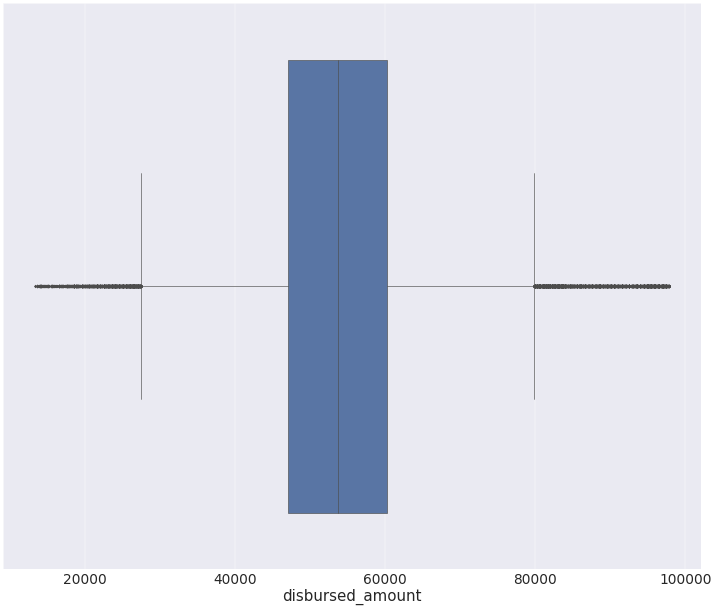

In [72]:
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['disbursed_amount'])
plt.show()

In [73]:
Q1 = data_new_1_nums['disbursed_amount'].quantile(0.25)
Q2 = data_new_1_nums['disbursed_amount'].quantile(0.50)
Q3 = data_new_1_nums['disbursed_amount'].quantile(0.75)
print(Q1)
print(Q2)
print(Q3)

47111.0
53713.0
60213.0


In [74]:
# Now applying Tukey's Rule on the same we get :
'''IQR = Q3 - Q1
data_new_1_nums = data_new_1_nums[data_new_1_nums['disbursed_amount'] >= (Q1 - 1.5*IQR)][data_new_1_nums['disbursed_amount'] <= (Q3 + 1.5*IQR)]
data_new_1 = data_new_1[data_new_1['disbursed_amount'] >= (Q1 - 1.5*IQR)][data_new_1['disbursed_amount'] <= (Q3 + 1.5*IQR)]'''

"IQR = Q3 - Q1\ndata_new_1_nums = data_new_1_nums[data_new_1_nums['disbursed_amount'] >= (Q1 - 1.5*IQR)][data_new_1_nums['disbursed_amount'] <= (Q3 + 1.5*IQR)]\ndata_new_1 = data_new_1[data_new_1['disbursed_amount'] >= (Q1 - 1.5*IQR)][data_new_1['disbursed_amount'] <= (Q3 + 1.5*IQR)]"

In [75]:
'''plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['disbursed_amount'])
plt.show()'''

"plt.figure(figsize=(30,25),dpi=30)\nsns.set(font_scale=3)\nsns.boxplot(data_new_1_nums['disbursed_amount'])\nplt.show()"

In [76]:
print(data_new_1_nums.shape)
print(data_new_1.shape)

(231979, 23)
(231979, 27)


#### Thus we see on the above plot that the outliers have been removed now.

#### So now we'll make slabs on the range of disbursed amounts,and see if there is any correlation between them and the loan defaults :

#### So we'll divide the disbursements as follows :
- Less (less than or equal to 25 percentile)
- Moderate (more than 25 percentile & less than or equal to 50 percentile)
- High (more than 50 percentile & less than or equal to 75 percentile)
- Very high (more than 75 percentile) . 

In [77]:
less_disbursed = data_new_1_nums[data_new_1_nums['disbursed_amount'] <= Q1]
moderate_disbursed = data_new_1_nums[data_new_1_nums['disbursed_amount'] > Q1][data_new_1_nums['disbursed_amount'] <= Q2]
high_disbursed = data_new_1_nums[data_new_1_nums['disbursed_amount'] > Q2][data_new_1_nums['disbursed_amount'] <= Q3]
very_high_disbursed = data_new_1_nums[data_new_1_nums['disbursed_amount'] > Q3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [78]:
# Now we'll check the percentage of defaults for every bucket of loan amount disbursed :
print(less_disbursed['loan_default'].value_counts()/less_disbursed.shape[0])
print(moderate_disbursed['loan_default'].value_counts()/moderate_disbursed.shape[0])
print(high_disbursed['loan_default'].value_counts()/high_disbursed.shape[0])
print(very_high_disbursed['loan_default'].value_counts()/very_high_disbursed.shape[0])

0    0.84109
1    0.15891
Name: loan_default, dtype: float64
0    0.793969
1    0.206031
Name: loan_default, dtype: float64
0    0.754882
1    0.245118
Name: loan_default, dtype: float64
0    0.741987
1    0.258013
Name: loan_default, dtype: float64


### Thus,there is a clearcut pattern of an increase in default rates as the loan amounts disbursed go on increasing for the lesser to moderate amounts.And also a slight increase in loan amounts disbursed as the amounts increase from high to very high.So let's verify it with the remaining variables now as well.

In [79]:
print(data_new_1_nums.shape)
print(data_new_1.shape)

(231979, 23)
(231979, 27)


### 2) asset_cost (Correlated to disbursed_amount) :

In [80]:
data_new_1_nums.shape

(231979, 23)

In [81]:
data_new_1_nums['asset_cost'].nunique()

45694

In [82]:
data_new_1_nums['asset_cost'].describe()

count    231979.000000
mean      75374.437009
std       17101.633443
min       37000.000000
25%       65695.000000
50%       70886.000000
75%       79000.000000
max      244607.000000
Name: asset_cost, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 1.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


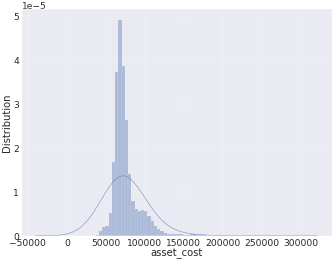

In [83]:
plt.figure(figsize=(20,15),dpi=20)
sns.set(font_scale=3)
sns.distplot(data_new_1_nums['asset_cost'],kde_kws = {'bw' : 1.5})
plt.xlabel('asset_cost')
plt.ylabel('Distribution')
plt.show() 

#### So the frequency distribution plot is almost similar to 'disbursed_amount' . 

No handles with labels found to put in legend.


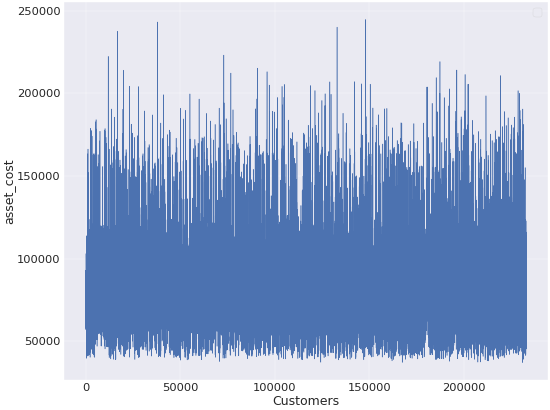

In [84]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['asset_cost'])
plt.legend(loc=1)
plt.xlabel('Customers')
plt.ylabel('asset_cost')
sns.set(font_scale=2)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


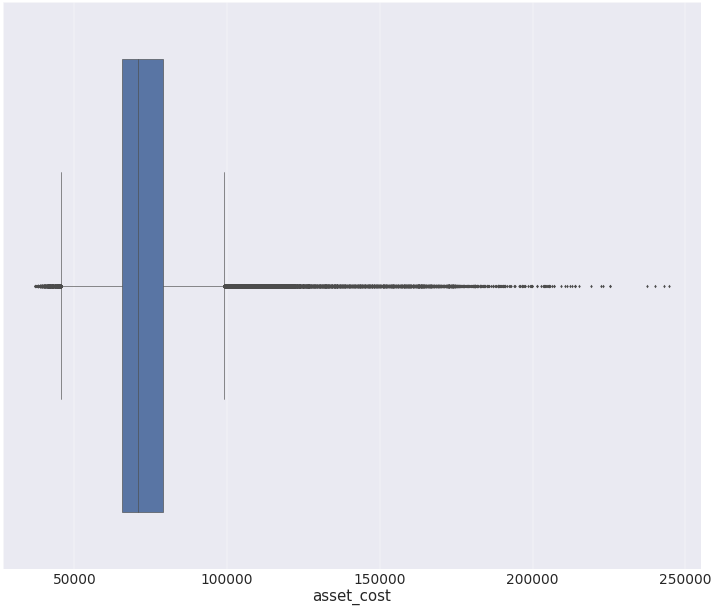

In [85]:
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['asset_cost'])
plt.show()

In [86]:
Q1 = data_new_1_nums['asset_cost'].quantile(0.25)
Q2 = data_new_1_nums['asset_cost'].quantile(0.50)
Q3 = data_new_1_nums['asset_cost'].quantile(0.75)
Q4 = data_new_1_nums['asset_cost'].quantile(0.95)
Q5 = data_new_1_nums['asset_cost'].quantile(0.99)
Q6 = data_new_1_nums['asset_cost'].quantile(0.995)
Q7 = data_new_1_nums['asset_cost'].quantile(0.998)
print(Q1)
print(Q2)
print(Q3)
print(Q4)
print(Q5)
print(Q6)
print(Q7)

65695.0
70886.0
79000.0
108280.0
144000.0
160163.0
171747.7479999999


In [87]:
data_new_1_nums = data_new_1_nums[data_new_1_nums['asset_cost'] <= data_new_1_nums['asset_cost'].quantile(0.99)]
data_new_1 = data_new_1[data_new_1['asset_cost'] <= data_new_1['asset_cost'].quantile(0.99)]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


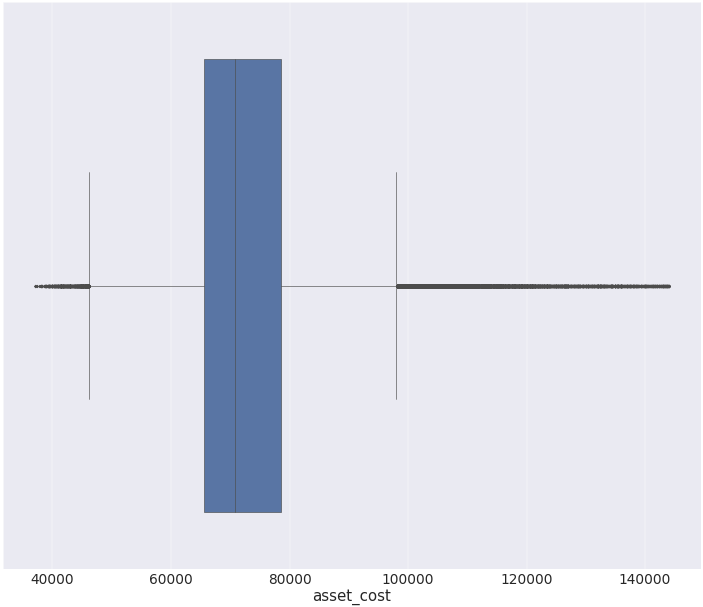

In [88]:
# So plotting the boxplot again now,we get :
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['asset_cost'])
plt.show()

In [89]:
Q1 = data_new_1_nums['asset_cost'].quantile(0.25)
Q2 = data_new_1_nums['asset_cost'].quantile(0.50)
Q3 = data_new_1_nums['asset_cost'].quantile(0.75)

In [90]:
print(data_new_1_nums.shape)
print(data_new_1.shape)

(229663, 23)
(229663, 27)


#### Hence we'll adopt the same approach with 'asset_cost' as we've adopted with 'disbursed_amount' , and divide the asset costs into 'less','moderate','high' and 'very high'. 

In [91]:
less_asset_cost = data_new_1_nums[data_new_1_nums['asset_cost'] <= Q1]
moderate_asset_cost = data_new_1_nums[data_new_1_nums['asset_cost'] > Q1][data_new_1_nums['asset_cost'] <= Q2]
high_asset_cost = data_new_1_nums[data_new_1_nums['asset_cost'] > Q2][data_new_1_nums['asset_cost'] <= Q3]
very_high_asset_cost = data_new_1_nums[data_new_1_nums['asset_cost'] > Q3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [92]:
# Now we'll check the percentage of defaults for every bucket of asset cost :
print(less_asset_cost['loan_default'].value_counts()/less_asset_cost.shape[0])
print(moderate_asset_cost['loan_default'].value_counts()/moderate_asset_cost.shape[0])
print(high_asset_cost['loan_default'].value_counts()/high_asset_cost.shape[0])
print(very_high_asset_cost['loan_default'].value_counts()/very_high_asset_cost.shape[0])

0    0.789157
1    0.210843
Name: loan_default, dtype: float64
0    0.79053
1    0.20947
Name: loan_default, dtype: float64
0    0.781561
1    0.218439
Name: loan_default, dtype: float64
0    0.770816
1    0.229184
Name: loan_default, dtype: float64


### Thus,almost like 'disbursed_amount','asset_cost' also shows a strong correlation with the defaults .

In [93]:
print(data_new_1_nums.shape)
print(data_new_1.shape)

(229663, 23)
(229663, 27)


### 3) ltv :

In [94]:
data_new_1_nums.shape

(229663, 23)

In [95]:
data_new_1_nums.head()

disbursed_amount  asset_cost    ltv  PERFORM_CNS.SCORE  PRI.NO.OF.ACCTS  \
0             50578       58400  89.55                  0                0   
1             47145       65550  73.23                598                1   
2             53278       61360  89.63                  0                0   
3             57513       66113  88.48                305                3   
4             52378       60300  88.39                  0                0   

   PRI.ACTIVE.ACCTS  PRI.OVERDUE.ACCTS  PRI.CURRENT.BALANCE  \
0                 0                  0                    0   
1                 1                  1                27600   
2                 0                  0                    0   
3                 0                  0                    0   
4                 0                  0                    0   

   PRI.DISBURSED.AMOUNT  SEC.NO.OF.ACCTS  SEC.ACTIVE.ACCTS  SEC.OVERDUE.ACCTS  \
0                     0                0                 0                  0   
1                 50200                0                 0                  0   
2                     0                0                 0                  0   
3                     0                0                 0                  0   
4                     0                0                 0                  0   

   SEC.CURRENT.BALANCE  SEC.DISBURSED.AMOUNT  PRIMARY.INSTAL.AMT  \
0                    0                     0                   0   
1                    0                     0                1991   
2                    0                     0                   0   
3                    0                     0                  31   
4                    0                     0                   0   

   SEC.INSTAL.AMT  NEW.ACCTS.IN.LAST.SIX.MONTHS  \
0               0                             0   
1               0                             0   
2               0                             0   
3               0                             0   
4               0                             0   

   DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS  NO.OF_INQUIRIES  loan_default    Age  \
0                                    0                0             0  12485   
1                                    1                0             1  12110   
2                                    0                0             0  11825   
3                                    0                1             1   9066   
4                                    0                1             1  14989   

   AVERAGE.ACCT.AGE (in days)  CREDIT.HISTORY.LENGTH (in days)  
0                           0                                0  
1                         695                              695  
2                           0                                0  
3                         240                              455  
4                           0                                0

In [96]:
round(47145/65550,4)*100

71.92

In [97]:
data_new_1_nums[data_new_1_nums['ltv'] != data_new_1_nums['disbursed_amount']/data_new_1_nums['asset_cost']].shape

(229663, 23)

In [98]:
data_new_1_nums['ltv'].nunique()

6530

#### Thus,the number of unique values for 'loan to value ratio' are quite small obviously,as these are only values between 1 to 100.

#### The 'ltv' values are also expressed in terms of percentage.

In [99]:
data_new_1_nums['ltv'].describe()

count    229663.000000
mean         74.965291
std          11.320830
min          13.500000
25%          69.240000
50%          77.040000
75%          83.770000
max          95.000000
Name: ltv, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 1.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


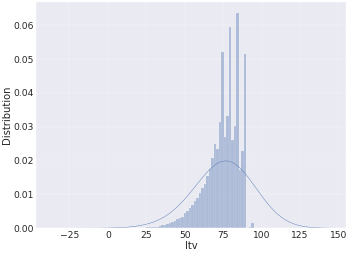

In [100]:
plt.figure(figsize=(20,15),dpi=20)
sns.set(font_scale=3)
sns.distplot(data_new_1_nums['ltv'],kde_kws = {'bw' : 1.5})
plt.xlabel('ltv')
plt.ylabel('Distribution')
plt.show() 

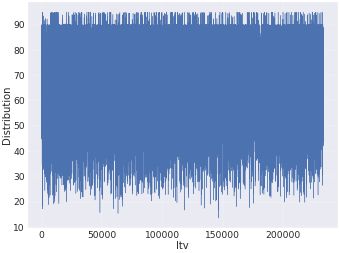

In [101]:
plt.figure(figsize=(20,15),dpi=20)
sns.set(font_scale=3)
plt.plot(data_new_1_nums['ltv'])
plt.xlabel('ltv')
plt.ylabel('Distribution')
plt.show() 

In [102]:
print(data_new_1_nums['ltv'].mean())
print(data_new_1_nums['ltv'].max())
print(data_new_1_nums['ltv'].min())
print(data_new_1_nums['ltv'].median())

74.96529136169522
95.0
13.5
77.04


#### The following points can be noted here :
- Thus unlike the earlier variables,'ltv' has a higher concentration of values around the right hand extreme.That means,majority of the customers take loans to cover greater than 50% of the asset cost.
- The average loan to value ratio is 75,thus justifying the fact that majority of customers take loans almost close to the vehicle price.
- No customer has been given a loan exactly equal to the vehicle price,but always lesser than the exact vehicle price.And the maximum cost covered by the loan is 95% of the vehicle cost.

In [103]:
Q1 = data_new_1_nums['ltv'].quantile(0.25)
Q2 = data_new_1_nums['ltv'].quantile(0.50)
Q3 = data_new_1_nums['ltv'].quantile(0.75)
print(Q1)
print(Q2)
print(Q3)

69.24
77.04
83.77


In [104]:
data_new_1_nums['ltv'].quantile(0.10)

59.33

In [105]:
data_new_1_nums['ltv'].quantile(0.01)

39.58

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


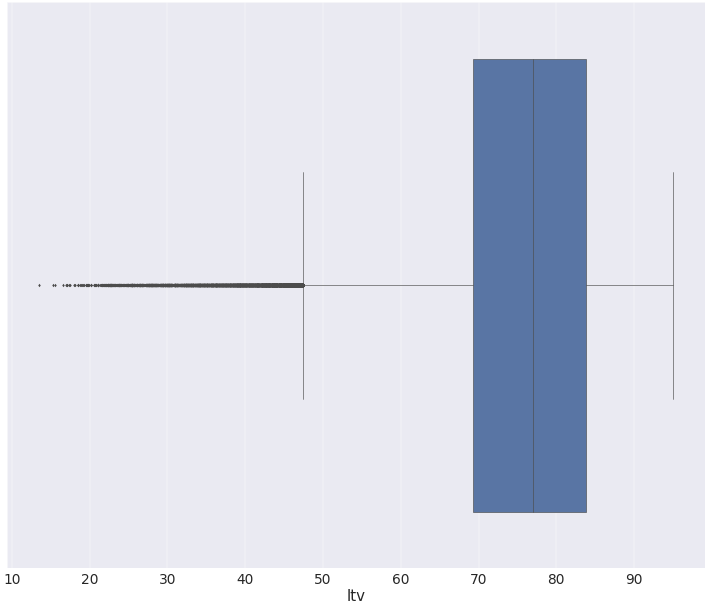

In [106]:
# Plotting the boxplot
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['ltv'])
plt.show()

In [107]:
# By removing 1% of the extreme left values,we get :
data_new_1_nums = data_new_1_nums[data_new_1_nums['ltv'] >= data_new_1_nums['ltv'].quantile(0.01)]
data_new_1 = data_new_1[data_new_1['ltv'] >= data_new_1['ltv'].quantile(0.01)]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


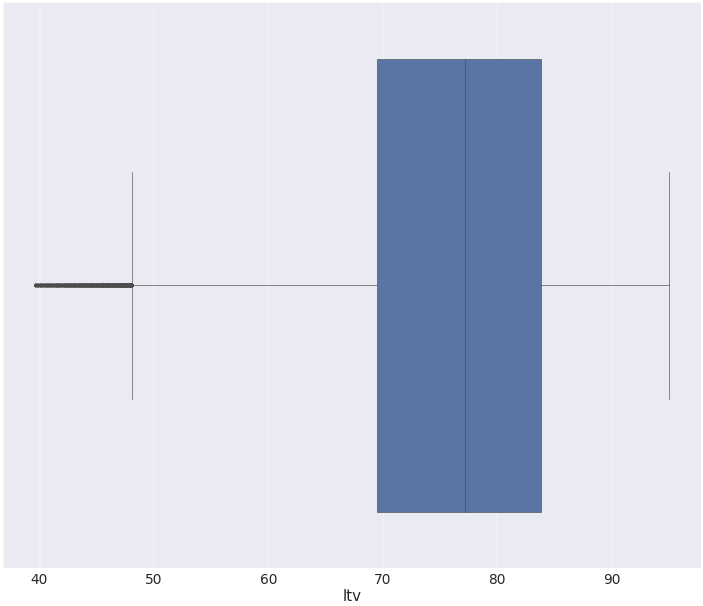

In [108]:
# Plotting the boxplot
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['ltv'])
plt.show()

In [109]:
data_new_1_nums.shape

(227368, 23)

In [110]:
less_ltv = data_new_1_nums[data_new_1_nums['ltv'] <= Q1]
moderate_ltv = data_new_1_nums[data_new_1_nums['ltv'] > Q1][data_new_1_nums['ltv'] <= Q2]
high_ltv = data_new_1_nums[data_new_1_nums['ltv'] > Q2][data_new_1_nums['ltv'] <= Q3]
very_high_ltv = data_new_1_nums[data_new_1_nums['ltv'] > Q3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [111]:
# Now we'll check the percentage of defaults for every bucket of ltv ratio :
print(less_ltv['loan_default'].value_counts()/less_ltv.shape[0])
print(moderate_ltv['loan_default'].value_counts()/moderate_ltv.shape[0])
print(high_ltv['loan_default'].value_counts()/high_ltv.shape[0])
print(very_high_ltv['loan_default'].value_counts()/very_high_ltv.shape[0])

0    0.844684
1    0.155316
Name: loan_default, dtype: float64
0    0.791398
1    0.208602
Name: loan_default, dtype: float64
0    0.761937
1    0.238063
Name: loan_default, dtype: float64
0    0.732933
1    0.267067
Name: loan_default, dtype: float64


### Thus clearly like 'loan amount disbursed',the variable 'ltv' (loan to value ratio) also has a very high correlation to loan default.

In [112]:
print(data_new_1_nums.shape)
print(data_new_1.shape)

(227368, 23)
(227368, 27)


In [113]:
data_new_1_nums.columns

Index(['disbursed_amount', 'asset_cost', 'ltv', 'PERFORM_CNS.SCORE',
       'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS',
       'PRI.CURRENT.BALANCE', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
       'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'NO.OF_INQUIRIES', 'loan_default', 'Age', 'AVERAGE.ACCT.AGE (in days)',
       'CREDIT.HISTORY.LENGTH (in days)'],
      dtype='object')

#### We'll check 'PERFORM_CNS.SCORE' in the end.

#### Since,there are both primary and secondary demographic variables of customers,we'll keep plotting both at a time :

In [114]:
data_new_1_nums.head()

disbursed_amount  asset_cost    ltv  PERFORM_CNS.SCORE  PRI.NO.OF.ACCTS  \
0             50578       58400  89.55                  0                0   
1             47145       65550  73.23                598                1   
2             53278       61360  89.63                  0                0   
3             57513       66113  88.48                305                3   
4             52378       60300  88.39                  0                0   

   PRI.ACTIVE.ACCTS  PRI.OVERDUE.ACCTS  PRI.CURRENT.BALANCE  \
0                 0                  0                    0   
1                 1                  1                27600   
2                 0                  0                    0   
3                 0                  0                    0   
4                 0                  0                    0   

   PRI.DISBURSED.AMOUNT  SEC.NO.OF.ACCTS  SEC.ACTIVE.ACCTS  SEC.OVERDUE.ACCTS  \
0                     0                0                 0                  0   
1                 50200                0                 0                  0   
2                     0                0                 0                  0   
3                     0                0                 0                  0   
4                     0                0                 0                  0   

   SEC.CURRENT.BALANCE  SEC.DISBURSED.AMOUNT  PRIMARY.INSTAL.AMT  \
0                    0                     0                   0   
1                    0                     0                1991   
2                    0                     0                   0   
3                    0                     0                  31   
4                    0                     0                   0   

   SEC.INSTAL.AMT  NEW.ACCTS.IN.LAST.SIX.MONTHS  \
0               0                             0   
1               0                             0   
2               0                             0   
3               0                             0   
4               0                             0   

   DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS  NO.OF_INQUIRIES  loan_default    Age  \
0                                    0                0             0  12485   
1                                    1                0             1  12110   
2                                    0                0             0  11825   
3                                    0                1             1   9066   
4                                    0                1             1  14989   

   AVERAGE.ACCT.AGE (in days)  CREDIT.HISTORY.LENGTH (in days)  
0                           0                                0  
1                         695                              695  
2                           0                                0  
3                         240                              455  
4                           0                                0

### 4) PRI.NO.OF.ACCTS & SEC.NO.OF.ACCTS:

These are the count of total loans taken by the customer at the time of disbursement for personal use

In [115]:
data_new_1_nums.shape

(227368, 23)

In [116]:
print(data_new_1_nums['PRI.NO.OF.ACCTS'].nunique())
print(data_new_1_nums['SEC.NO.OF.ACCTS'].nunique())

107
37


In [117]:
data_new_1_nums['PRI.NO.OF.ACCTS'].describe()

count    227368.000000
mean          2.446945
std           5.230490
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max         453.000000
Name: PRI.NO.OF.ACCTS, dtype: float64

In [118]:
data_new_1_nums['SEC.NO.OF.ACCTS'].describe()

count    227368.000000
mean          0.059401
std           0.631206
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          52.000000
Name: SEC.NO.OF.ACCTS, dtype: float64

No handles with labels found to put in legend.


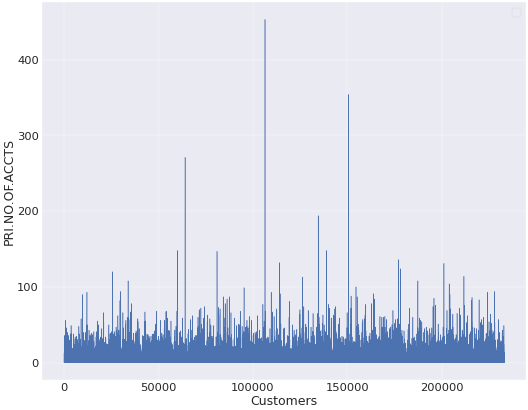

In [119]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['PRI.NO.OF.ACCTS'])
plt.legend(loc=1)
plt.ylabel('PRI.NO.OF.ACCTS')
plt.xlabel('Customers')
sns.set(font_scale=2)
plt.show()

No handles with labels found to put in legend.


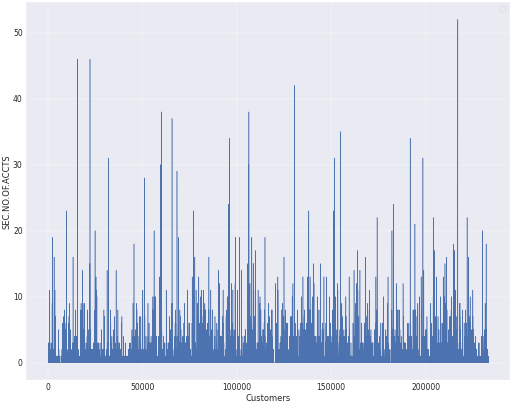

In [120]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['SEC.NO.OF.ACCTS'])
plt.legend(loc=1)
plt.ylabel('SEC.NO.OF.ACCTS')
plt.xlabel('Customers')
sns.set(font_scale=2)
plt.show()

#### Since primary number of accounts are so negligible as compared to the secondary ones,we'll combine both as 'total_no_of_accts' :

In [121]:
data_new_1_nums['TOTAL_NO_OF_ACCTS'] = data_new_1_nums['PRI.NO.OF.ACCTS'] + data_new_1_nums['SEC.NO.OF.ACCTS']
data_new_1['TOTAL_NO_OF_ACCTS'] = data_new_1['PRI.NO.OF.ACCTS'] + data_new_1['SEC.NO.OF.ACCTS']
data_new_2 = data_new_1.drop(['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS'],axis=1)

#### So,we've created a new dataframe named 'data_new_2' to contain only the modified new columns.

In [122]:
data_new_1_nums['TOTAL_NO_OF_ACCTS'].describe()

count    227368.000000
mean          2.506347
std           5.303389
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max         453.000000
Name: TOTAL_NO_OF_ACCTS, dtype: float64

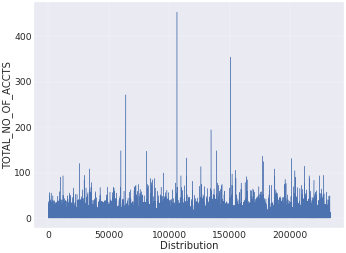

In [123]:
plt.figure(figsize=(20,15),dpi=20)
sns.set(font_scale=3)
plt.plot(data_new_1_nums['TOTAL_NO_OF_ACCTS'])
plt.xlabel('Distribution')
plt.ylabel('TOTAL_NO_OF_ACCTS')
plt.show() 

In [124]:
data_new_1_nums[data_new_1_nums['TOTAL_NO_OF_ACCTS'] > 100].shape

(18, 24)

#### Here since there are quite a few obvious extreme outliers as can be seen clearly in the visual itself, all the values above 100 are removed.

In [125]:
data_new_1_nums = data_new_1_nums[data_new_1_nums['TOTAL_NO_OF_ACCTS'] <= 100]
data_new_1 = data_new_1[data_new_1['TOTAL_NO_OF_ACCTS'] <= 100]
data_new_2 = data_new_2[data_new_2['TOTAL_NO_OF_ACCTS'] <= 100]

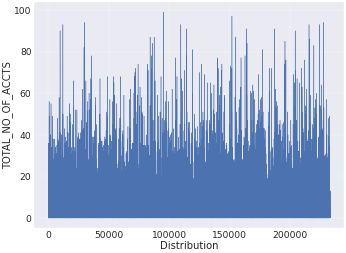

In [126]:
plt.figure(figsize=(20,15),dpi=20)
sns.set(font_scale=3)
plt.plot(data_new_1_nums['TOTAL_NO_OF_ACCTS'])
plt.xlabel('Distribution')
plt.ylabel('TOTAL_NO_OF_ACCTS')
plt.show() 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


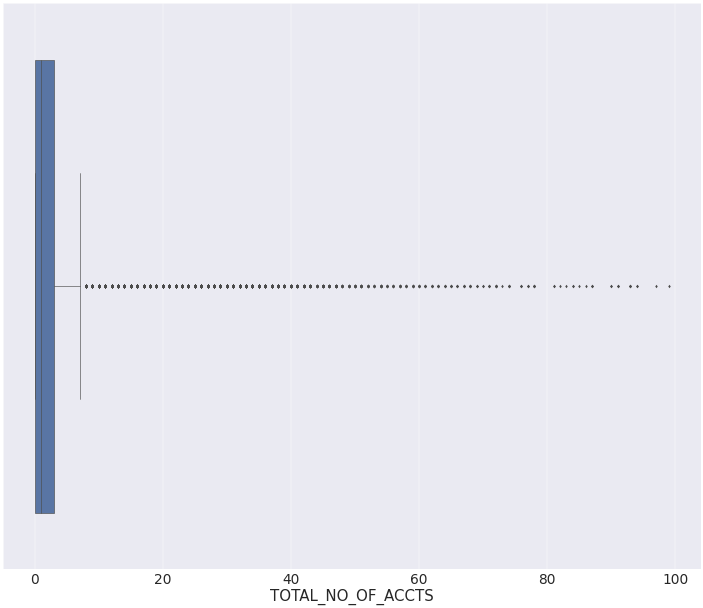

In [127]:
# Plotting the boxplot
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['TOTAL_NO_OF_ACCTS'])
plt.show()

In [128]:
print(data_new_1_nums['TOTAL_NO_OF_ACCTS'].quantile(0.995))
print(data_new_1_nums['TOTAL_NO_OF_ACCTS'].quantile(0.99))
print(data_new_1_nums['TOTAL_NO_OF_ACCTS'].quantile(0.98))
print(data_new_1_nums['TOTAL_NO_OF_ACCTS'].quantile(0.97))
print(data_new_1_nums['TOTAL_NO_OF_ACCTS'].quantile(0.96))
print(data_new_1_nums['TOTAL_NO_OF_ACCTS'].quantile(0.95))
print(data_new_1_nums['TOTAL_NO_OF_ACCTS'].quantile(0.75))
print(data_new_1_nums['TOTAL_NO_OF_ACCTS'].quantile(0.50))
print(data_new_1_nums['TOTAL_NO_OF_ACCTS'].quantile(0.25))

30.0
24.0
18.0
15.0
13.0
11.0
3.0
1.0
0.0


In [129]:
Q4 = data_new_1_nums['TOTAL_NO_OF_ACCTS'].quantile(0.98)

#### Thus,considering all the accounts only upto 98th quantile,we get the folowing :

In [130]:
data_new_1_nums = data_new_1_nums[data_new_1_nums['TOTAL_NO_OF_ACCTS'] <= Q4]
data_new_1 = data_new_1[data_new_1['TOTAL_NO_OF_ACCTS'] <= Q4]
data_new_2 = data_new_2[data_new_2['TOTAL_NO_OF_ACCTS'] <= Q4]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


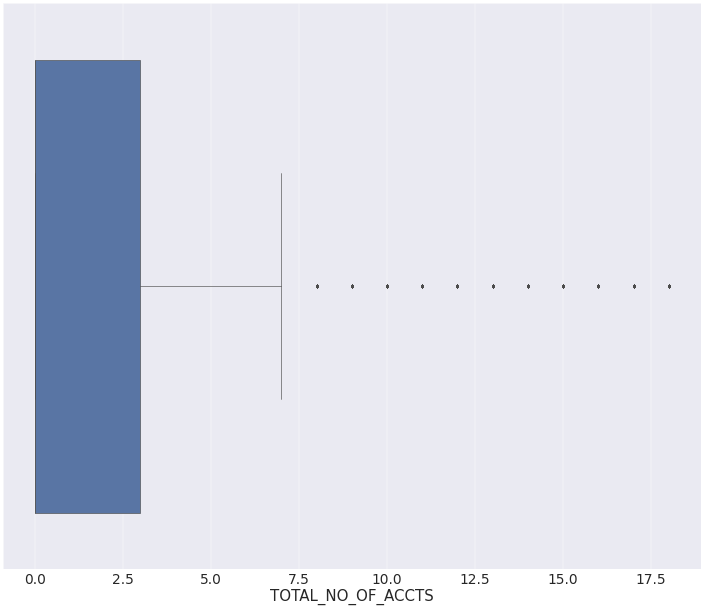

In [131]:
# Plotting the boxplot
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['TOTAL_NO_OF_ACCTS'])
plt.show()

In [132]:
data_new_1_nums.shape

(223174, 24)

In [133]:
Q1 = data_new_1_nums['TOTAL_NO_OF_ACCTS'].quantile(0.25)
Q2 = data_new_1_nums['TOTAL_NO_OF_ACCTS'].quantile(0.50)
Q3 = data_new_1_nums['TOTAL_NO_OF_ACCTS'].quantile(0.75)

In [134]:
print(Q1)
print(Q2)
print(Q3)

0.0
0.0
3.0


In [135]:
no_TOTAL_ACCTS = data_new_1_nums[data_new_1_nums['TOTAL_NO_OF_ACCTS'] == Q1]
more_TOTAL_ACCTS = data_new_1_nums[data_new_1_nums['TOTAL_NO_OF_ACCTS'] >= Q2][data_new_1_nums['TOTAL_NO_OF_ACCTS'] < Q3]
high_TOTAL_ACCTS = data_new_1_nums[data_new_1_nums['TOTAL_NO_OF_ACCTS'] >= Q3]

In [136]:
# Now we'll check the percentage of defaults for every number of primary account holders :
print(no_TOTAL_ACCTS['loan_default'].value_counts()/no_TOTAL_ACCTS.shape[0])
print(more_TOTAL_ACCTS['loan_default'].value_counts()/more_TOTAL_ACCTS.shape[0])
print(high_TOTAL_ACCTS['loan_default'].value_counts()/high_TOTAL_ACCTS.shape[0])

0    0.767629
1    0.232371
Name: loan_default, dtype: float64
0    0.771507
1    0.228493
Name: loan_default, dtype: float64
0    0.808739
1    0.191261
Name: loan_default, dtype: float64


### Thus there is a negative correlation between the different groups of ‘total number of accounts’, and the ‘default rate’.

### 5) PRI.ACTIVE.ACCTS & SEC.ACTIVE.ACCTS: 
These are the count of active loans taken by the customer at the time of disbursement	 

In [137]:
print(data_new_1_nums.shape)
print(data_new_1.shape)
print(data_new_2.shape)

(223174, 24)
(223174, 28)
(223174, 26)


In [138]:
print(data_new_1_nums['PRI.ACTIVE.ACCTS'].nunique())
print(data_new_1_nums['SEC.ACTIVE.ACCTS'].nunique())

18
13


No handles with labels found to put in legend.


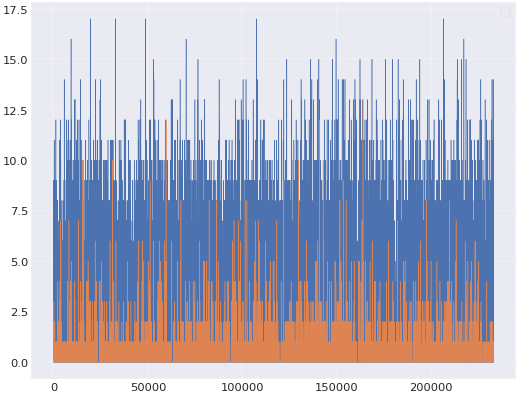

In [139]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['PRI.ACTIVE.ACCTS'])
plt.plot(data_new_1_nums['SEC.ACTIVE.ACCTS'])
plt.legend(loc=1)
sns.set(font_scale=2)
plt.show()

#### Here since number of secondary active accounts is so less,we'll add both as above to obtain 'TOTAL_ACTIVE_ACCTS'.

In [140]:
data_new_1_nums['TOTAL_ACTIVE_ACCTS'] = data_new_1_nums['PRI.ACTIVE.ACCTS'] + data_new_1_nums['SEC.ACTIVE.ACCTS']

In [141]:
data_new_1['TOTAL_ACTIVE_ACCTS'] = data_new_1['PRI.ACTIVE.ACCTS'] + data_new_1['SEC.ACTIVE.ACCTS']

In [142]:
data_new_2['TOTAL_ACTIVE_ACCTS'] = data_new_2['PRI.ACTIVE.ACCTS'] + data_new_2['SEC.ACTIVE.ACCTS']

In [143]:
data_new_2.head()

UniqueID  disbursed_amount  asset_cost    ltv manufacturer_id  \
0   420825             50578       58400  89.55              45   
1   537409             47145       65550  73.23              45   
2   417566             53278       61360  89.63              45   
3   624493             57513       66113  88.48              45   
4   539055             52378       60300  88.39              45   

  Employment.Type  PERFORM_CNS.SCORE PERFORM_CNS.SCORE.DESCRIPTION  \
0        Salaried                  0   No Bureau History Available   
1   Self employed                598                 I-Medium Risk   
2   Self employed                  0   No Bureau History Available   
3   Self employed                305              L-Very High Risk   
4   Self employed                  0   No Bureau History Available   

   PRI.ACTIVE.ACCTS  PRI.OVERDUE.ACCTS  PRI.CURRENT.BALANCE  \
0                 0                  0                    0   
1                 1                  1                27600   
2                 0                  0                    0   
3                 0                  0                    0   
4                 0                  0                    0   

   PRI.DISBURSED.AMOUNT  SEC.ACTIVE.ACCTS  SEC.OVERDUE.ACCTS  \
0                     0                 0                  0   
1                 50200                 0                  0   
2                     0                 0                  0   
3                     0                 0                  0   
4                     0                 0                  0   

   SEC.CURRENT.BALANCE  SEC.DISBURSED.AMOUNT  PRIMARY.INSTAL.AMT  \
0                    0                     0                   0   
1                    0                     0                1991   
2                    0                     0                   0   
3                    0                     0                  31   
4                    0                     0                   0   

   SEC.INSTAL.AMT  NEW.ACCTS.IN.LAST.SIX.MONTHS  \
0               0                             0   
1               0                             0   
2               0                             0   
3               0                             0   
4               0                             0   

   DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS  NO.OF_INQUIRIES  loan_default    Age  \
0                                    0                0             0  12485   
1                                    1                0             1  12110   
2                                    0                0             0  11825   
3                                    0                1             1   9066   
4                                    0                1             1  14989   

   AVERAGE.ACCT.AGE (in days)  CREDIT.HISTORY.LENGTH (in days)  \
0                           0                                0   
1                         695                              695   
2                           0                                0   
3                         240                              455   
4                           0                                0   

   TOTAL_NO_OF_ACCTS  TOTAL_ACTIVE_ACCTS  
0                  0                   0  
1                  1                   1  
2                  0                   0  
3                  3                   0  
4                  0                   0

In [144]:
data_new_2 = data_new_2.drop(['PRI.ACTIVE.ACCTS','SEC.ACTIVE.ACCTS'],axis=1)

In [145]:
data_new_1_nums['TOTAL_ACTIVE_ACCTS'].describe()

count    223174.000000
mean          0.943891
std           1.616234
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          17.000000
Name: TOTAL_ACTIVE_ACCTS, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


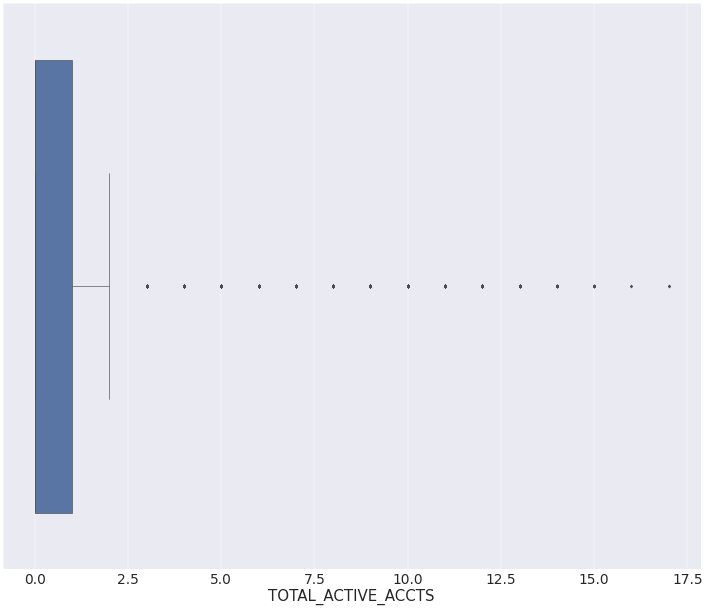

In [146]:
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['TOTAL_ACTIVE_ACCTS'])
plt.show()

In [147]:
data_new_1_nums['TOTAL_ACTIVE_ACCTS'].quantile(0.995)

8.0

In [148]:
print(data_new_1_nums[data_new_1_nums['TOTAL_ACTIVE_ACCTS']>data_new_1_nums['TOTAL_ACTIVE_ACCTS'].quantile(0.99)].shape)
print(data_new_1_nums[data_new_1_nums['TOTAL_ACTIVE_ACCTS']>data_new_1_nums['TOTAL_ACTIVE_ACCTS'].quantile(0.995)].shape)
print(data_new_1_nums[data_new_1_nums['TOTAL_ACTIVE_ACCTS']>=data_new_1_nums['TOTAL_ACTIVE_ACCTS'].quantile(0.995)].shape)

(1983, 25)
(1109, 25)
(1983, 25)


In [149]:
print(data_new_1_nums['TOTAL_ACTIVE_ACCTS'].quantile(0.25))
print(data_new_1_nums['TOTAL_ACTIVE_ACCTS'].quantile(0.50))
print(data_new_1_nums['TOTAL_ACTIVE_ACCTS'].quantile(0.75))
print(data_new_1_nums['TOTAL_ACTIVE_ACCTS'].quantile(0.95))
print(data_new_1_nums['TOTAL_ACTIVE_ACCTS'].quantile(0.98))
print(data_new_1_nums['TOTAL_ACTIVE_ACCTS'].quantile(0.99))

0.0
0.0
1.0
4.0
6.0
7.0


In [150]:
data_new_1_nums = data_new_1_nums[data_new_1_nums['TOTAL_ACTIVE_ACCTS'] <= 7]
data_new_1 = data_new_1[data_new_1['TOTAL_ACTIVE_ACCTS'] <= 7]
data_new_2 = data_new_2[data_new_2['TOTAL_ACTIVE_ACCTS'] <= 7]

In [151]:
data_new_1_nums.shape

(221191, 25)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


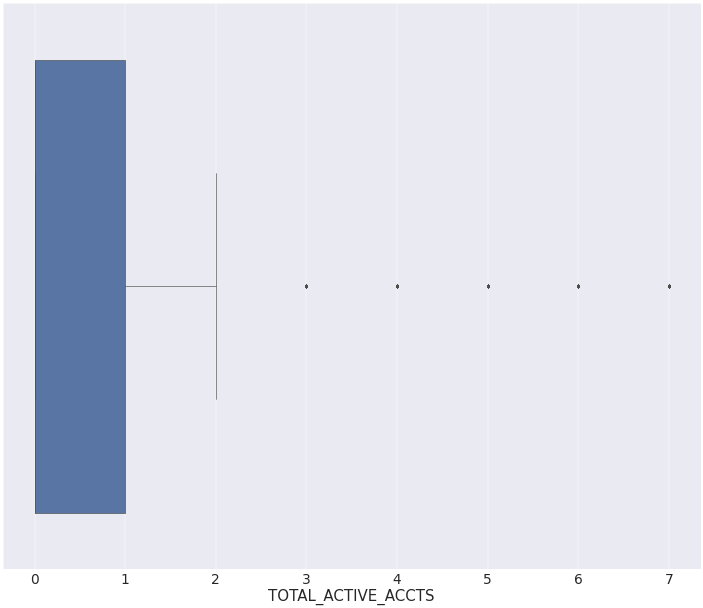

In [152]:
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['TOTAL_ACTIVE_ACCTS'])
plt.show()

In [153]:
Q1 = data_new_1_nums['TOTAL_ACTIVE_ACCTS'].quantile(0.25)
Q2 = data_new_1_nums['TOTAL_ACTIVE_ACCTS'].quantile(0.50)
Q3 = data_new_1_nums['TOTAL_ACTIVE_ACCTS'].quantile(0.75)

In [154]:
data_new_1_nums['TOTAL_ACTIVE_ACCTS'] = round(data_new_1_nums['TOTAL_ACTIVE_ACCTS'],2)
data_new_1['TOTAL_ACTIVE_ACCTS'] = round(data_new_1['TOTAL_ACTIVE_ACCTS'],2)
data_new_2['TOTAL_ACTIVE_ACCTS'] = round(data_new_2['TOTAL_ACTIVE_ACCTS'],2)

In [155]:
print(Q1)
print(Q2)
print(Q3)

0.0
0.0
1.0


In [156]:
no_TOTAL_ACTIVE_ACCTS = data_new_1_nums[data_new_1_nums['TOTAL_ACTIVE_ACCTS'] == 0]
one_TOTAL_ACTIVE_ACCTS = data_new_1_nums[data_new_1_nums['TOTAL_ACTIVE_ACCTS'] == 1]
more_TOTAL_ACTIVE_ACCTS = data_new_1_nums[data_new_1_nums['TOTAL_ACTIVE_ACCTS'] > 1]

In [157]:
# Now we'll check the percentage of defaults for every number of primary active accounts holders :
print(no_TOTAL_ACTIVE_ACCTS['loan_default'].value_counts()/no_TOTAL_ACTIVE_ACCTS.shape[0])
print(one_TOTAL_ACTIVE_ACCTS['loan_default'].value_counts()/one_TOTAL_ACTIVE_ACCTS.shape[0])
print(more_TOTAL_ACTIVE_ACCTS['loan_default'].value_counts()/more_TOTAL_ACTIVE_ACCTS.shape[0])

0    0.772283
1    0.227717
Name: loan_default, dtype: float64
0    0.780125
1    0.219875
Name: loan_default, dtype: float64
0    0.803453
1    0.196547
Name: loan_default, dtype: float64


### Thus clearly,higher number of active accounts means these are fleet owners of vehicles,and hence the likelihood of defaulting reduces as the case before.

### 5) PRI.OVERDUE.ACCTS & SEC.OVERDUE.ACCTS:

In [158]:
data_new_1_nums.shape

(221191, 25)

In [159]:
print(data_new_1_nums['PRI.OVERDUE.ACCTS'].nunique())
print(data_new_1_nums['SEC.OVERDUE.ACCTS'].nunique())

13
7


In [160]:
data_new_1_nums['PRI.OVERDUE.ACCTS'].describe()

count    221191.000000
mean          0.136185
std           0.464581
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.000000
Name: PRI.OVERDUE.ACCTS, dtype: float64

In [161]:
data_new_1_nums['SEC.OVERDUE.ACCTS'].describe()

count    221191.000000
mean          0.005791
std           0.089999
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: SEC.OVERDUE.ACCTS, dtype: float64

No handles with labels found to put in legend.


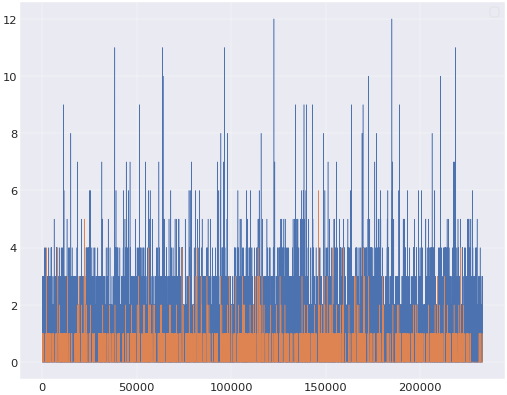

In [162]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['PRI.OVERDUE.ACCTS'])
plt.plot(data_new_1_nums['SEC.OVERDUE.ACCTS'])
plt.legend(loc=1)
sns.set(font_scale=2)
plt.show()

#### Similarly as above we'll add both primary and secondary overdue accounts:

In [163]:
data_new_1_nums['TOTAL_OVERDUE_ACCTS'] = data_new_1_nums['PRI.OVERDUE.ACCTS'] + data_new_1_nums['SEC.OVERDUE.ACCTS']
data_new_1['TOTAL_OVERDUE_ACCTS'] = data_new_1['PRI.OVERDUE.ACCTS'] + data_new_1['SEC.OVERDUE.ACCTS']
data_new_2['TOTAL_OVERDUE_ACCTS'] = data_new_2['PRI.OVERDUE.ACCTS'] + data_new_2['SEC.OVERDUE.ACCTS']
data_new_2 = data_new_2.drop(['PRI.OVERDUE.ACCTS','SEC.OVERDUE.ACCTS'],axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


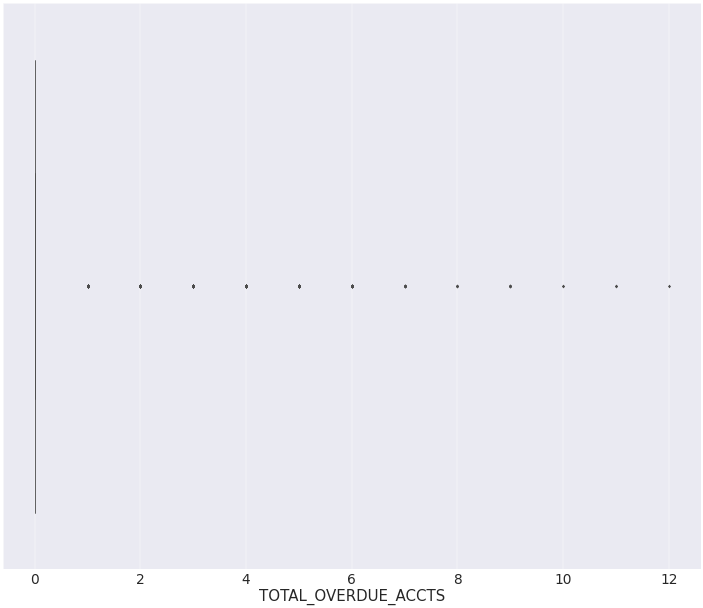

In [164]:
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['TOTAL_OVERDUE_ACCTS'])
plt.show()

#### So we'll remove the obvious extreme outliers, and thus all the ones above 7.

In [165]:
data_new_1_nums = data_new_1_nums[data_new_1_nums['TOTAL_OVERDUE_ACCTS'] <= 7]
data_new_1 = data_new_1[data_new_1['TOTAL_OVERDUE_ACCTS'] <= 7]
data_new_2 = data_new_2[data_new_2['TOTAL_OVERDUE_ACCTS'] <= 7]

In [166]:
data_new_1_nums.shape

(221164, 26)

No handles with labels found to put in legend.


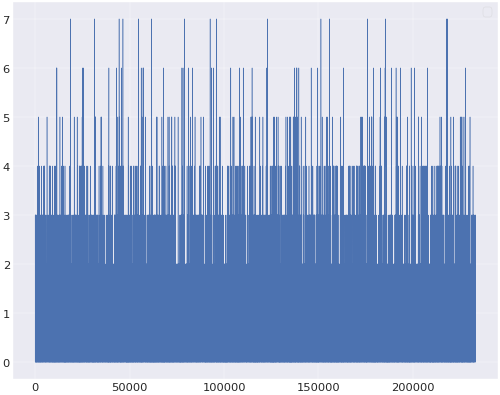

In [167]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_2['TOTAL_OVERDUE_ACCTS'])
plt.legend(loc=1)
sns.set(font_scale=2)
plt.show()

In [168]:
print(data_new_1_nums['TOTAL_OVERDUE_ACCTS'].quantile(0.25))
print(data_new_1_nums['TOTAL_OVERDUE_ACCTS'].quantile(0.50))
print(data_new_1_nums['TOTAL_OVERDUE_ACCTS'].quantile(0.75))
print(data_new_1_nums['TOTAL_OVERDUE_ACCTS'].quantile(0.95))
print(data_new_1_nums['TOTAL_OVERDUE_ACCTS'].quantile(0.98))
print(data_new_1_nums['TOTAL_OVERDUE_ACCTS'].quantile(0.99))
print(data_new_1_nums['TOTAL_OVERDUE_ACCTS'].quantile(0.995))
print(data_new_1_nums['TOTAL_OVERDUE_ACCTS'].quantile(0.998))

0.0
0.0
0.0
1.0
2.0
2.0
3.0
4.0


In [169]:
# A simple function to 
def overdue(i):
    if i>4:
        return 4
    else:
        return i

In [170]:
data_new_1_nums['TOTAL_OVERDUE_ACCTS'] = data_new_1_nums['TOTAL_OVERDUE_ACCTS'].apply(overdue)
data_new_1['TOTAL_OVERDUE_ACCTS'] = data_new_1['TOTAL_OVERDUE_ACCTS'].apply(overdue)
data_new_2['TOTAL_OVERDUE_ACCTS'] = data_new_2['TOTAL_OVERDUE_ACCTS'].apply(overdue)

In [171]:
Q1 = data_new_1_nums['TOTAL_OVERDUE_ACCTS'].quantile(0.25)
Q2 = data_new_1_nums['TOTAL_OVERDUE_ACCTS'].quantile(0.50)
Q3 = data_new_1_nums['TOTAL_OVERDUE_ACCTS'].quantile(0.75)

In [172]:
print(Q1)
print(Q2)
print(Q3)

0.0
0.0
0.0


In [173]:
data_new_1_nums['TOTAL_OVERDUE_ACCTS'] = round(data_new_1_nums['TOTAL_OVERDUE_ACCTS'],2)
data_new_1['TOTAL_OVERDUE_ACCTS'] = round(data_new_1['TOTAL_OVERDUE_ACCTS'],2)
data_new_2['TOTAL_OVERDUE_ACCTS'] = round(data_new_2['TOTAL_OVERDUE_ACCTS'],2)

In [174]:
no_TOTAL_OVERDUE_ACCTS = data_new_1_nums[data_new_1_nums['TOTAL_OVERDUE_ACCTS'] == 0]
one_TOTAL_OVERDUE_ACCTS = data_new_1_nums[data_new_1_nums['TOTAL_OVERDUE_ACCTS'] == 1]
more_TOTAL_OVERDUE_ACCTS = data_new_1_nums[data_new_1_nums['TOTAL_OVERDUE_ACCTS'] > 1]

In [175]:
# Now we'll check the percentage of defaults for every number of primary active accounts holders :
print(no_TOTAL_OVERDUE_ACCTS['loan_default'].value_counts()/no_TOTAL_OVERDUE_ACCTS.shape[0])
print(one_TOTAL_OVERDUE_ACCTS['loan_default'].value_counts()/one_TOTAL_OVERDUE_ACCTS.shape[0])
print(more_TOTAL_OVERDUE_ACCTS['loan_default'].value_counts()/more_TOTAL_OVERDUE_ACCTS.shape[0])

0    0.788076
1    0.211924
Name: loan_default, dtype: float64
0    0.722905
1    0.277095
Name: loan_default, dtype: float64
0    0.697998
1    0.302002
Name: loan_default, dtype: float64


### This is an obvious relationship,as more primary overdue accounts clearly mean more tendency to default on more.

In [176]:
print(data_new_1_nums.shape)
print(data_new_1.shape)
print(data_new_2.shape)

(221164, 26)
(221164, 30)
(221164, 24)


### 7) PRI.CURRENT.BALANCE & SEC.CURRENT.BALANCE :

In [177]:
print(data_new_1_nums['PRI.CURRENT.BALANCE'].nunique())
print(data_new_1_nums['SEC.CURRENT.BALANCE'].nunique())

64186
2743


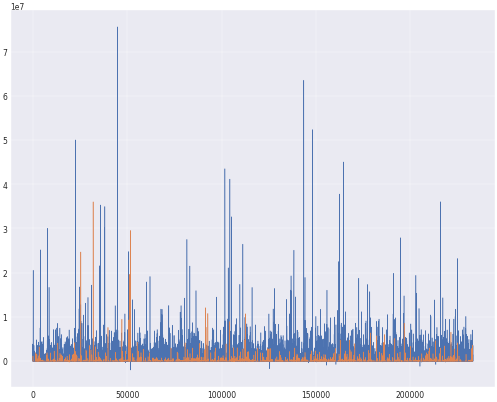

In [178]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['PRI.CURRENT.BALANCE'])
plt.plot(data_new_1_nums['SEC.CURRENT.BALANCE'])
#plt.legend(loc=1)
sns.set(font_scale=2)
plt.show()

#### Using the same logic as above,we'll add both 'PRI.CURRENT.BALANCE' and 'SEC.CURRENT.BALANCE' to obtain the overall current balance of the customer,calling it as 'OVERALL_CURRENT_BALANCE' :

In [179]:
data_new_1_nums['OVERALL_CURRENT_BALANCE'] = data_new_1_nums['PRI.CURRENT.BALANCE'] + data_new_1_nums['SEC.CURRENT.BALANCE']
data_new_1['OVERALL_CURRENT_BALANCE'] = data_new_1['PRI.CURRENT.BALANCE'] + data_new_1['SEC.CURRENT.BALANCE']
data_new_2['OVERALL_CURRENT_BALANCE'] = data_new_2['PRI.CURRENT.BALANCE'] + data_new_2['SEC.CURRENT.BALANCE']
data_new_2 = data_new_2.drop(['PRI.CURRENT.BALANCE','SEC.CURRENT.BALANCE'],axis=1)

No handles with labels found to put in legend.


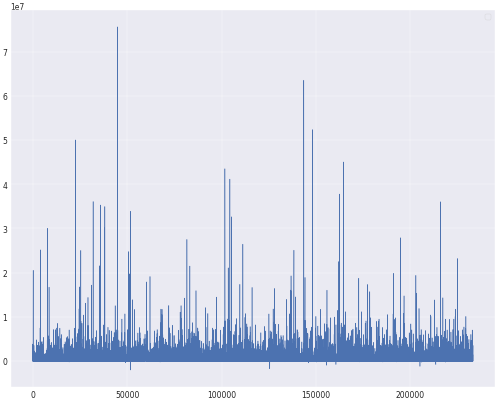

In [180]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['OVERALL_CURRENT_BALANCE'])
plt.legend(loc=1)
sns.set(font_scale=2)
plt.show()

#### Thus to get rid of the obvious extreme outliers, we'll remove all the values above 4 * 10^7

In [181]:
data_new_1_nums = data_new_1_nums[data_new_1_nums['OVERALL_CURRENT_BALANCE'] <= 4*10**7]
data_new_1 = data_new_1[data_new_1['OVERALL_CURRENT_BALANCE'] <= 4*10**7]
data_new_2 = data_new_2[data_new_2['OVERALL_CURRENT_BALANCE'] <= 4*10**7]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


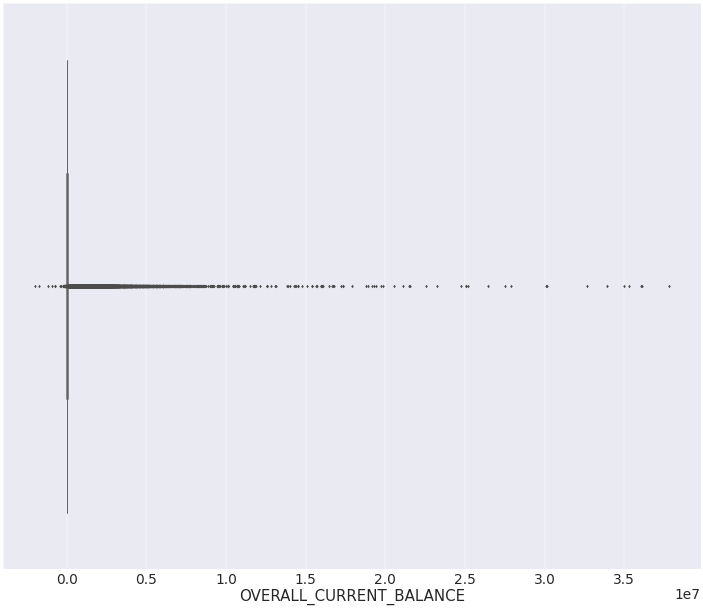

In [182]:
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['OVERALL_CURRENT_BALANCE'])
plt.show()

In [183]:
data_new_1[data_new_1['OVERALL_CURRENT_BALANCE']<0].shape

(433, 31)

#### Thus clearly there are some cases where the 'OVERALL_CURRENT_BALANCE' is negative. These are possibly the cases where the customer has overpaid than his equalised periodical due amount beforehand,which is a positive indicator of not defaulting.

#### Now to get rid of the right hand extreme outliers, we'll carry out the same process as above :

In [184]:
print(data_new_2['OVERALL_CURRENT_BALANCE'].quantile(0.998))
print(data_new_2['OVERALL_CURRENT_BALANCE'].quantile(0.995))
print(data_new_2['OVERALL_CURRENT_BALANCE'].quantile(0.99))
print(data_new_2['OVERALL_CURRENT_BALANCE'].quantile(0.98))
print(data_new_2['OVERALL_CURRENT_BALANCE'].quantile(0.97))
print(data_new_2['OVERALL_CURRENT_BALANCE'].quantile(0.96))

5106062.130000002
3302103.6250000037
2364405.850000011
1529201.6
1114292.75
842560.3999999961


In [185]:
print(data_new_2['OVERALL_CURRENT_BALANCE'].quantile(0.25))
print(data_new_2['OVERALL_CURRENT_BALANCE'].quantile(0.50))
print(data_new_2['OVERALL_CURRENT_BALANCE'].quantile(0.75))
print(data_new_2['OVERALL_CURRENT_BALANCE'].quantile(0.95))

0.0
0.0
28745.25
657455.0


In [186]:
data_new_1_nums = data_new_1_nums[data_new_1_nums['OVERALL_CURRENT_BALANCE'] < data_new_1_nums['OVERALL_CURRENT_BALANCE'].quantile(0.99)]
data_new_1 = data_new_1[data_new_1['OVERALL_CURRENT_BALANCE'] < data_new_1['OVERALL_CURRENT_BALANCE'].quantile(0.99)]
data_new_2 = data_new_2[data_new_2['OVERALL_CURRENT_BALANCE'] < data_new_2['OVERALL_CURRENT_BALANCE'].quantile(0.99)]

In [187]:
print(data_new_1_nums.shape)
print(data_new_1.shape)
print(data_new_2.shape)

(218944, 27)
(218944, 31)
(218944, 23)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


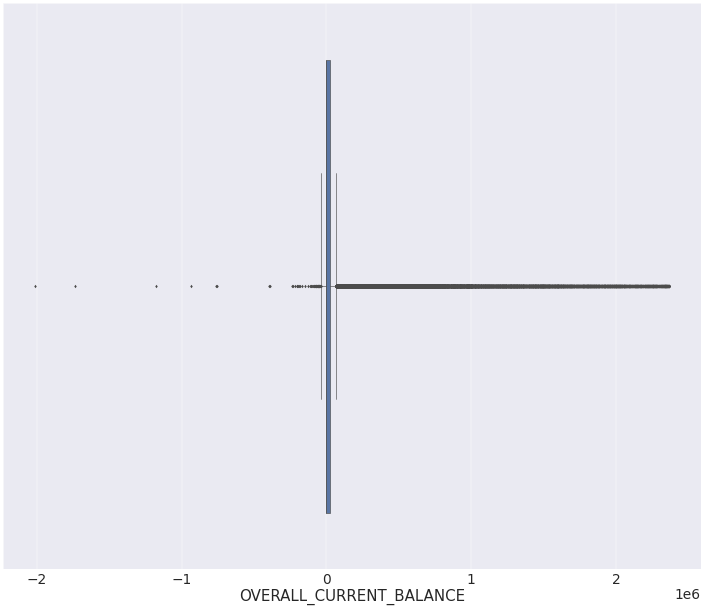

In [188]:
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['OVERALL_CURRENT_BALANCE'])
plt.show()

In [189]:
Q1 = data_new_1_nums['OVERALL_CURRENT_BALANCE'].quantile(0.25)
Q2 = data_new_1_nums['OVERALL_CURRENT_BALANCE'].quantile(0.50)
Q3 = data_new_1_nums['OVERALL_CURRENT_BALANCE'].quantile(0.75)
Q4 = data_new_1_nums['OVERALL_CURRENT_BALANCE'].quantile(0.95)

In [190]:
print(Q1)
print(Q2)
print(Q3)
print(Q4)

0.0
0.0
25818.75
529298.4499999991


In [191]:
data_new_1_nums['OVERALL_CURRENT_BALANCE'] = round(data_new_1_nums['OVERALL_CURRENT_BALANCE'],2)
data_new_1['OVERALL_CURRENT_BALANCE'] = round(data_new_1['OVERALL_CURRENT_BALANCE'],2)
data_new_2['OVERALL_CURRENT_BALANCE'] = round(data_new_2['OVERALL_CURRENT_BALANCE'],2)

In [192]:
negative_CURRENT_BALANCE = data_new_1_nums[data_new_1_nums['OVERALL_CURRENT_BALANCE'] < 0]
no_CURRENT_BALANCE = data_new_1_nums[data_new_1_nums['OVERALL_CURRENT_BALANCE'] == 0]
high_CURRENT_BALANCE = data_new_1_nums[data_new_1_nums['OVERALL_CURRENT_BALANCE'] >= Q3][data_new_1_nums['OVERALL_CURRENT_BALANCE'] < Q4]
very_high_CURRENT_BALANCE = data_new_1_nums[data_new_1_nums['OVERALL_CURRENT_BALANCE'] >= Q4] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [193]:
# Now we'll check the percentage of defaults for every band of overall current balance holders :
print(negative_CURRENT_BALANCE['loan_default'].value_counts()/negative_CURRENT_BALANCE.shape[0])
print(no_CURRENT_BALANCE['loan_default'].value_counts()/no_CURRENT_BALANCE.shape[0])
print(high_CURRENT_BALANCE['loan_default'].value_counts()/high_CURRENT_BALANCE.shape[0])
print(very_high_CURRENT_BALANCE['loan_default'].value_counts()/very_high_CURRENT_BALANCE.shape[0])

0    0.849885
1    0.150115
Name: loan_default, dtype: float64
0    0.773177
1    0.226823
Name: loan_default, dtype: float64
0    0.78147
1    0.21853
Name: loan_default, dtype: float64
0    0.840884
1    0.159116
Name: loan_default, dtype: float64


#### Thus as expected the negative current balance holders and very high current balance holders have significantly lesser chances of defaulting than the others. The reason can be attributed to the facts that :
- For negative current balance holders,they've already paid more than due meaning that they're not financially stressed.
- For very high current balance holders,it means that either they're owners of big fleets of vehicles or some big shots because of which it's unlikely for them to default.

In [194]:
print(data_new_1_nums.shape)
print(data_new_1.shape)
print(data_new_2.shape)

(218944, 27)
(218944, 31)
(218944, 23)


### 9) PRI.DISBURSED.AMOUNT & SEC.DISBURSED.AMOUNT :

In [195]:
print(data_new_1_nums['PRI.DISBURSED.AMOUNT'].nunique())
print(data_new_1_nums['SEC.DISBURSED.AMOUNT'].nunique())

39837
2042


No handles with labels found to put in legend.


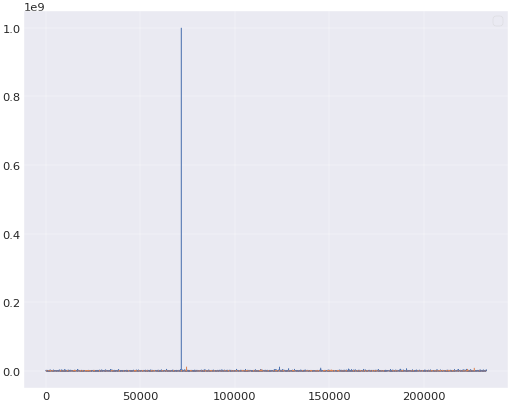

In [196]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['PRI.DISBURSED.AMOUNT'])
plt.plot(data_new_1_nums['SEC.DISBURSED.AMOUNT'])
plt.legend(loc=1)
sns.set(font_scale=2)
plt.show()

#### The very high and sharp kink at around 55000 clearly means that there's an abnormally high outlier,that's someone with an unusually high primary disbursed amount,at around the fifty five thousandth customer.

#### Using the same logic as above,we'll add both 'PRI.DISBURSED.AMOUNT' and 'SEC.DISBURSED.AMOUNT' to obtain the overall disbursed amount of the customer,calling it as 'OVERALL_DISBURSED_AMOUNT' :

In [197]:
data_new_1_nums['OVERALL_DISBURSED_AMOUNT'] = data_new_1_nums['PRI.DISBURSED.AMOUNT'] + data_new_1_nums['SEC.DISBURSED.AMOUNT']
data_new_1['OVERALL_DISBURSED_AMOUNT'] = data_new_1['PRI.DISBURSED.AMOUNT'] + data_new_1['SEC.DISBURSED.AMOUNT']
data_new_2['OVERALL_DISBURSED_AMOUNT'] = data_new_2['PRI.DISBURSED.AMOUNT'] + data_new_2['SEC.DISBURSED.AMOUNT']
data_new_2 = data_new_2.drop(['PRI.DISBURSED.AMOUNT','SEC.DISBURSED.AMOUNT'],axis=1)

No handles with labels found to put in legend.


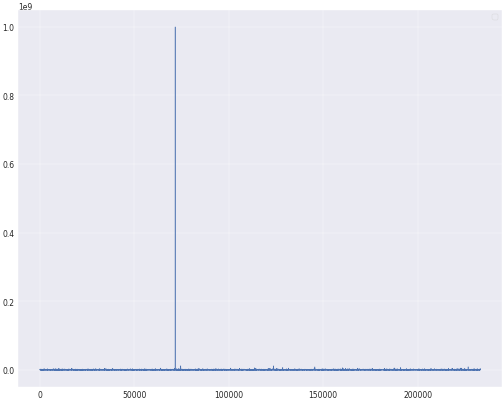

In [198]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['OVERALL_DISBURSED_AMOUNT'])
plt.legend(loc=1)
sns.set(font_scale=2)
plt.show()

In [199]:
# Removing the obvious outliers
data_new_1_nums = data_new_1_nums[data_new_1_nums['OVERALL_DISBURSED_AMOUNT'] < (0.2*10**9)]
data_new_1 = data_new_1[data_new_1['OVERALL_DISBURSED_AMOUNT'] < (0.2*10**9)]
data_new_2 = data_new_2[data_new_2['OVERALL_DISBURSED_AMOUNT'] < (0.2*10**9)]

No handles with labels found to put in legend.


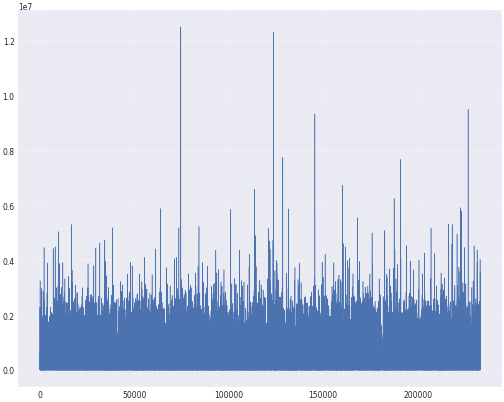

In [200]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['OVERALL_DISBURSED_AMOUNT'])
plt.legend(loc=1)
sns.set(font_scale=2)
plt.show()

In [201]:
# Removing the obvious outliers once again :
data_new_1_nums = data_new_1_nums[data_new_1_nums['OVERALL_DISBURSED_AMOUNT'] <= (0.6*10**7)]
data_new_1 = data_new_1[data_new_1['OVERALL_DISBURSED_AMOUNT'] <= (0.6*10**7)]
data_new_2 = data_new_2[data_new_2['OVERALL_DISBURSED_AMOUNT'] <= (0.6*10**7)]

No handles with labels found to put in legend.


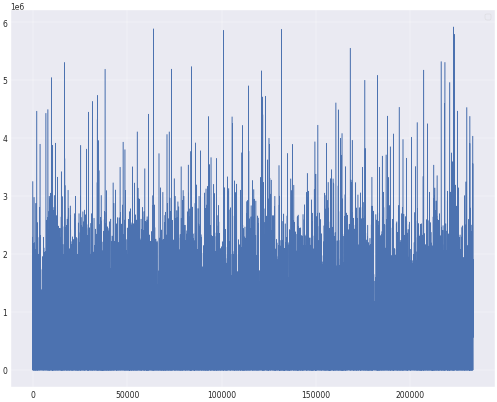

In [202]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['OVERALL_DISBURSED_AMOUNT'])
plt.legend(loc=1)
sns.set(font_scale=2)
plt.show()

In [203]:
Q1 = data_new_1_nums['OVERALL_DISBURSED_AMOUNT'].quantile(0.25)
Q2 = data_new_1_nums['OVERALL_DISBURSED_AMOUNT'].quantile(0.50)
Q3 = data_new_1_nums['OVERALL_DISBURSED_AMOUNT'].quantile(0.75)
Q4 = data_new_1_nums['OVERALL_DISBURSED_AMOUNT'].quantile(0.95)
Q5 = data_new_1_nums['OVERALL_DISBURSED_AMOUNT'].quantile(0.98)
Q6 = data_new_1_nums['OVERALL_DISBURSED_AMOUNT'].quantile(0.99)
Q7 = data_new_1_nums['OVERALL_DISBURSED_AMOUNT'].quantile(0.995)
Q8 = data_new_1_nums['OVERALL_DISBURSED_AMOUNT'].quantile(0.998)
print(Q1)
print(Q2)
print(Q3)
print(Q4)
print(Q5)
print(Q6)
print(Q7)
print(Q8)

0.0
0.0
50000.0
705394.0499999962
1400000.0
1860000.0
2226615.2399999974
2597690.377999976


In [204]:
data_new_1_nums['OVERALL_DISBURSED_AMOUNT'].max()

5919026

In [205]:
# Since here the deviation due to outliers is too large,we'll choose only the values upto the 98th percentile.
data_new_1_nums = data_new_1_nums[data_new_1_nums['OVERALL_DISBURSED_AMOUNT'] <= data_new_1_nums['OVERALL_DISBURSED_AMOUNT'].quantile(0.98)]
data_new_1 = data_new_1[data_new_1['OVERALL_DISBURSED_AMOUNT'] <= data_new_1['OVERALL_DISBURSED_AMOUNT'].quantile(0.98)]
data_new_2 = data_new_2[data_new_2['OVERALL_DISBURSED_AMOUNT'] <= data_new_2['OVERALL_DISBURSED_AMOUNT'].quantile(0.98)]

In [206]:
data_new_1_nums['OVERALL_DISBURSED_AMOUNT'] = round(data_new_1_nums['OVERALL_DISBURSED_AMOUNT'],2)
data_new_1['OVERALL_DISBURSED_AMOUNT'] = round(data_new_1['OVERALL_DISBURSED_AMOUNT'],2)
data_new_2['OVERALL_DISBURSED_AMOUNT'] = round(data_new_2['OVERALL_DISBURSED_AMOUNT'],2)

In [207]:
print(data_new_1_nums.shape)
print(data_new_1.shape)
print(data_new_2.shape)

(214576, 28)
(214576, 32)
(214576, 22)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


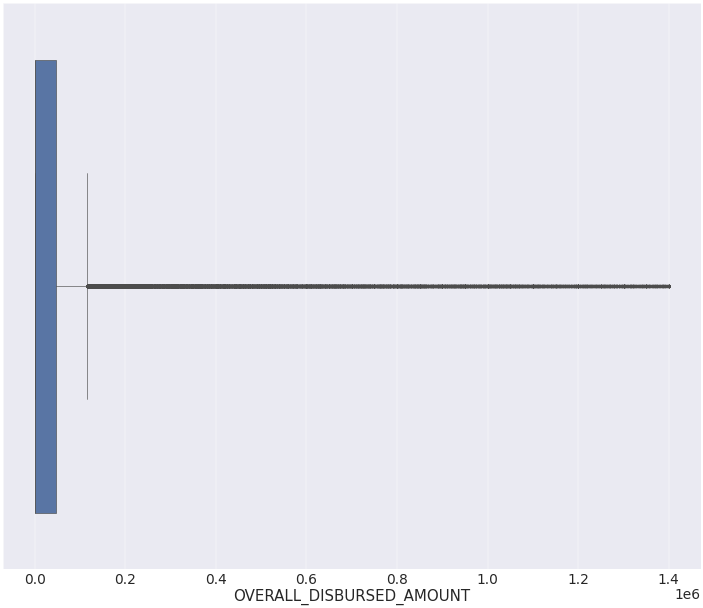

In [208]:
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['OVERALL_DISBURSED_AMOUNT'])
plt.show()

In [209]:
no_DISBURSED_AMOUNT = data_new_1_nums[data_new_1_nums['OVERALL_DISBURSED_AMOUNT'] == 0]
high_DISBURSED_AMOUNT = data_new_1_nums[data_new_1_nums['OVERALL_DISBURSED_AMOUNT'] >= Q3][data_new_1_nums['OVERALL_DISBURSED_AMOUNT'] < Q4]
very_high_DISBURSED_AMOUNT = data_new_1_nums[data_new_1_nums['OVERALL_DISBURSED_AMOUNT'] >= Q4] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [210]:
# Now we'll check the percentage of defaults for every band of overall disbursed amount groups :
print(no_DISBURSED_AMOUNT['loan_default'].value_counts()/no_DISBURSED_AMOUNT.shape[0])
print(high_DISBURSED_AMOUNT['loan_default'].value_counts()/high_DISBURSED_AMOUNT.shape[0])
print(very_high_DISBURSED_AMOUNT['loan_default'].value_counts()/very_high_DISBURSED_AMOUNT.shape[0])

0    0.772551
1    0.227449
Name: loan_default, dtype: float64
0    0.783817
1    0.216183
Name: loan_default, dtype: float64
0    0.843375
1    0.156625
Name: loan_default, dtype: float64


In [211]:
print(data_new_1_nums.shape)
print(data_new_1.shape)
print(data_new_2.shape)

(214576, 28)
(214576, 32)
(214576, 22)


### 10) PRIMARY.INSTAL.AMT & SEC.INSTAL.AMT :

No handles with labels found to put in legend.


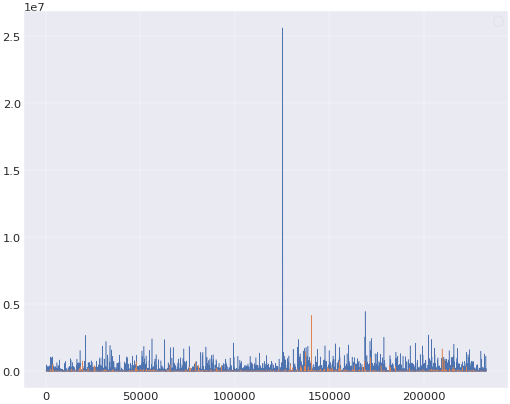

In [212]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['PRIMARY.INSTAL.AMT'])
plt.plot(data_new_1_nums['SEC.INSTAL.AMT'])
plt.legend(loc=1)
sns.set(font_scale=2)
plt.show()

In [213]:
data_new_1_nums['TOTAL_INSTAL_AMT'] = data_new_1_nums['PRIMARY.INSTAL.AMT'] + data_new_1_nums['SEC.INSTAL.AMT']
data_new_1['TOTAL_INSTAL_AMT'] = data_new_1['PRIMARY.INSTAL.AMT'] + data_new_1['SEC.INSTAL.AMT']
data_new_2['TOTAL_INSTAL_AMT'] = data_new_2['PRIMARY.INSTAL.AMT'] + data_new_2['SEC.INSTAL.AMT']
data_new_2 = data_new_2.drop(['PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT'],axis=1)

In [214]:
data_new_1_nums = data_new_1_nums[data_new_1_nums['TOTAL_INSTAL_AMT'] < (0.25*10**7)]
data_new_1 = data_new_1[data_new_1['TOTAL_INSTAL_AMT'] < (0.25*10**7)]
data_new_2 = data_new_2[data_new_2['TOTAL_INSTAL_AMT'] < (0.25*10**7)]

No handles with labels found to put in legend.


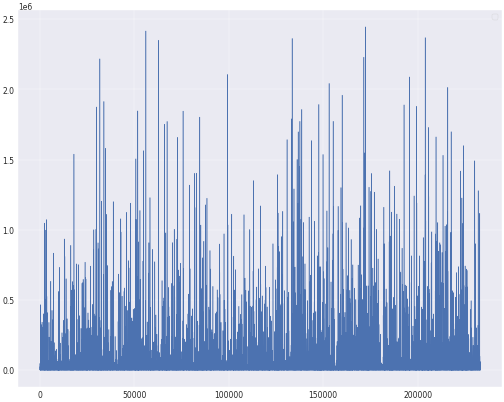

In [215]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['TOTAL_INSTAL_AMT'])
plt.legend(loc=1)
sns.set(font_scale=2)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


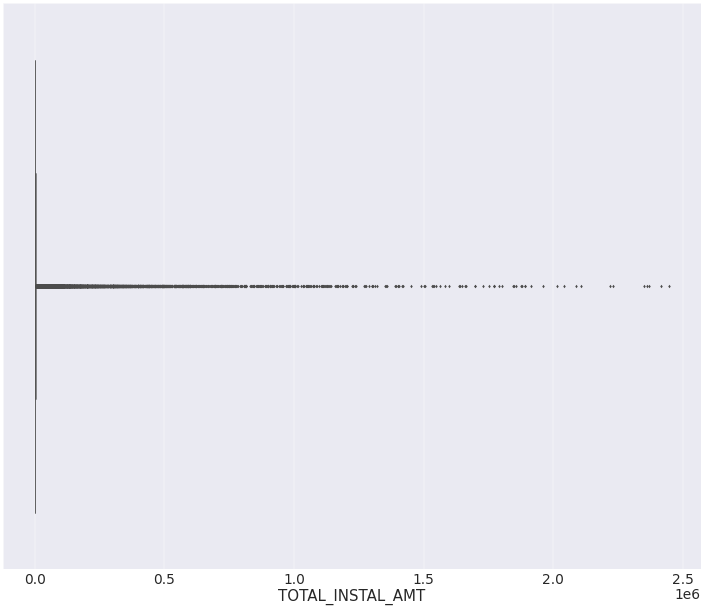

In [216]:
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['TOTAL_INSTAL_AMT'])
plt.show()

In [217]:
data_new_1_nums.shape

(214569, 29)

In [218]:
data_new_1_nums[data_new_1_nums['TOTAL_INSTAL_AMT'] > 136479.56].shape

(2217, 29)

In [219]:
data_new_1_nums[data_new_1_nums['TOTAL_INSTAL_AMT'] > 0.5*10**6].shape

(470, 29)

In [220]:
print(data_new_1_nums['TOTAL_INSTAL_AMT'].quantile(0.95))
print(data_new_1_nums['TOTAL_INSTAL_AMT'].quantile(0.98))
print(data_new_1_nums['TOTAL_INSTAL_AMT'].quantile(0.99))
print(data_new_1_nums['TOTAL_INSTAL_AMT'].quantile(0.995))
print(data_new_1_nums['TOTAL_INSTAL_AMT'].quantile(0.998))

15660.0
51000.0
141867.4000000003
282015.8400000003
535855.0560000008


In [221]:
data_new_1_nums['TOTAL_INSTAL_AMT'] = round(data_new_1_nums['TOTAL_INSTAL_AMT'],2)

In [222]:
data_new_1_nums = data_new_1_nums[data_new_1_nums['TOTAL_INSTAL_AMT'] <= 535000]
data_new_1 = data_new_1[data_new_1['TOTAL_INSTAL_AMT'] <= 535000]
data_new_2 = data_new_2[data_new_2['TOTAL_INSTAL_AMT'] <= 535000]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


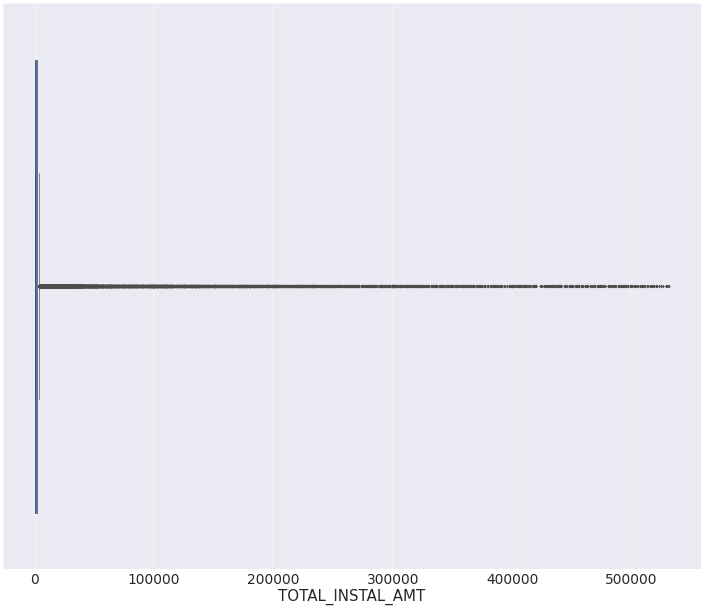

In [223]:
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['TOTAL_INSTAL_AMT'])
plt.show()

In [224]:
print(data_new_1_nums.shape)
print(data_new_1.shape)
print(data_new_2.shape)

(214138, 29)
(214138, 33)
(214138, 21)


In [225]:
Q1 = data_new_1_nums['TOTAL_INSTAL_AMT'].quantile(0.25)
Q2 = data_new_1_nums['TOTAL_INSTAL_AMT'].quantile(0.50)
Q3 = data_new_1_nums['TOTAL_INSTAL_AMT'].quantile(0.75)

In [226]:
print(data_new_1_nums['TOTAL_INSTAL_AMT'].quantile(0.95))
print(data_new_1_nums['TOTAL_INSTAL_AMT'].quantile(0.96))
print(data_new_1_nums['TOTAL_INSTAL_AMT'].quantile(0.97))
print(data_new_1_nums['TOTAL_INSTAL_AMT'].quantile(0.98))
print(data_new_1_nums['TOTAL_INSTAL_AMT'].quantile(0.99))

15104.0
18468.0
24572.77999999997
42954.04000000004
112756.45000000007


In [227]:
Q3 = data_new_1_nums['TOTAL_INSTAL_AMT'].quantile(0.75)
Q4 = data_new_1_nums['TOTAL_INSTAL_AMT'].quantile(0.95)

In [228]:
no_INSTAL_AMT = data_new_1_nums[data_new_1_nums['TOTAL_INSTAL_AMT'] == 0]
high_INSTAL_AMT = data_new_1_nums[data_new_1_nums['TOTAL_INSTAL_AMT'] >= Q3][data_new_1_nums['TOTAL_INSTAL_AMT'] < Q4]
very_high_INSTAL_AMT = data_new_1_nums[data_new_1_nums['TOTAL_INSTAL_AMT'] >= Q4] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [229]:
# Now we'll check the percentage of defaults for every band of total installment amount groups :
print(no_INSTAL_AMT['loan_default'].value_counts()/no_INSTAL_AMT.shape[0])
print(high_INSTAL_AMT['loan_default'].value_counts()/high_INSTAL_AMT.shape[0])
print(very_high_INSTAL_AMT['loan_default'].value_counts()/very_high_INSTAL_AMT.shape[0])

0    0.778731
1    0.221269
Name: loan_default, dtype: float64
0    0.771194
1    0.228806
Name: loan_default, dtype: float64
0    0.788569
1    0.211431
Name: loan_default, dtype: float64


#### Thus,clearly,for those with exceptionally higher installment amounts,the chances of defaulting reduce.

In [230]:
print(data_new_1_nums.shape)
print(data_new_1.shape)
print(data_new_2.shape)

(214138, 29)
(214138, 33)
(214138, 21)


### 11) NEW.ACCTS.IN.LAST.SIX.MONTHS :

In [231]:
# Checking to see if all of the created instances of the dataframes are still the same.
print(data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS'].nunique())
print(data_new_1['NEW.ACCTS.IN.LAST.SIX.MONTHS'].nunique())
print(data_new_2['NEW.ACCTS.IN.LAST.SIX.MONTHS'].nunique())

14
14
14


No handles with labels found to put in legend.


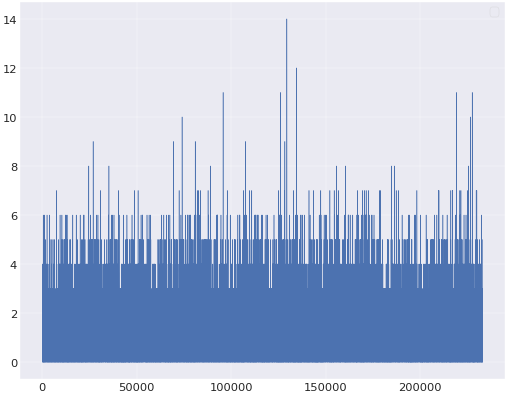

In [232]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS'])
plt.legend(loc=1)
sns.set(font_scale=2)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


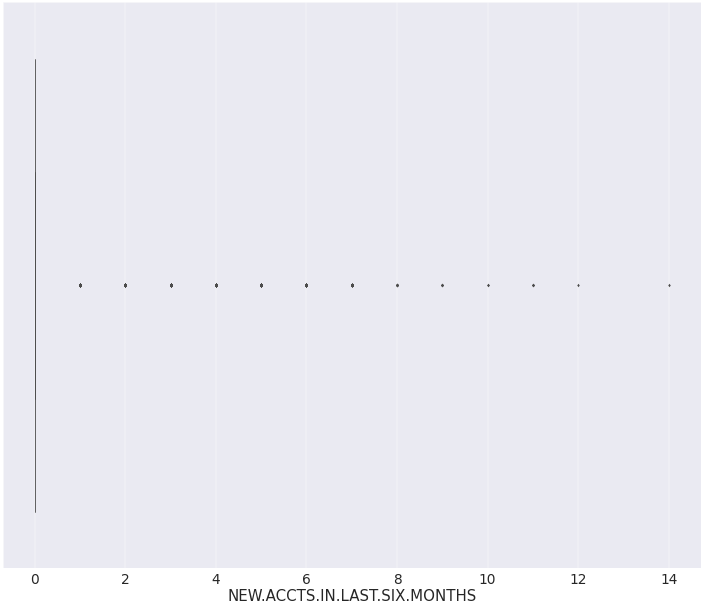

In [233]:
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS'])
plt.show()

In [234]:
print(data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS'].quantile(0.25))
print(data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS'].quantile(0.50))
print(data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS'].quantile(0.75))
print(data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS'].quantile(0.95))
print(data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS'].quantile(0.98))
print(data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS'].quantile(0.99))
print(data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS'].quantile(0.995))
print(data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS'].quantile(0.998))
print(data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS'].quantile(0.999))


0.0
0.0
0.0
2.0
3.0
3.0
4.0
5.0
5.0


#### Now, since here the number of unique values are very low, as 99.99% of values are within 5,we we can treat it as a categorical variable as follows :

In [235]:
def new_accounts(i):
    if i >= 4 :
        return '4 or greater'
    else :
        return i

In [236]:
data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS'] = data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS'].apply(new_accounts)
data_new_1['NEW.ACCTS.IN.LAST.SIX.MONTHS'] = data_new_1['NEW.ACCTS.IN.LAST.SIX.MONTHS'].apply(new_accounts)
data_new_2['NEW.ACCTS.IN.LAST.SIX.MONTHS'] = data_new_2['NEW.ACCTS.IN.LAST.SIX.MONTHS'].apply(new_accounts)

In [237]:
data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS'].value_counts()

0               172206
1                28215
2                 8809
3                 3152
4 or greater      1756
Name: NEW.ACCTS.IN.LAST.SIX.MONTHS, dtype: int64

In [238]:
print(data_new_1_nums[data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS']==0]['loan_default'].value_counts()/data_new_1_nums[data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS']==0].shape[0])
print(data_new_1_nums[data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS']==1]['loan_default'].value_counts()/data_new_1_nums[data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS']==1].shape[0])
print(data_new_1_nums[data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS']==2]['loan_default'].value_counts()/data_new_1_nums[data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS']==2].shape[0])
print(data_new_1_nums[data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS']==3]['loan_default'].value_counts()/data_new_1_nums[data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS']==3].shape[0])
print(data_new_1_nums[data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS']=='4 or greater']['loan_default'].value_counts()/data_new_1_nums[data_new_1_nums['NEW.ACCTS.IN.LAST.SIX.MONTHS']=='4 or greater'].shape[0])

0    0.772836
1    0.227164
Name: loan_default, dtype: float64
0    0.79603
1    0.20397
Name: loan_default, dtype: float64
0    0.80134
1    0.19866
Name: loan_default, dtype: float64
0    0.811865
1    0.188135
Name: loan_default, dtype: float64
0    0.807517
1    0.192483
Name: loan_default, dtype: float64


#### So clearly there is a trend of decreasing default risk with increasing number of accounts in the last 6 months,with a slight exception when number of accounts crosses beyond 4.

### 12) DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS :

In [239]:
data_new_1_nums['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].nunique()

8

No handles with labels found to put in legend.


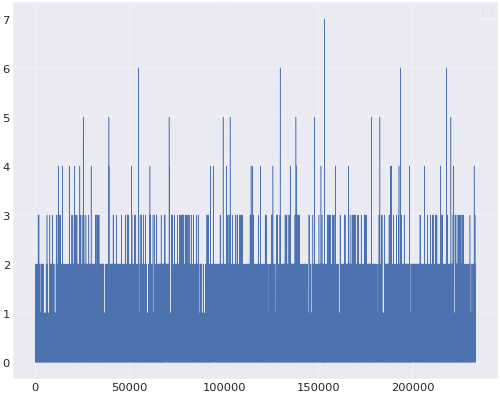

In [240]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'])
plt.legend(loc=1)
sns.set(font_scale=2)
plt.show()

In [241]:
print(data_new_1_nums['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].quantile(0.25))
print(data_new_1_nums['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].quantile(0.50))
print(data_new_1_nums['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].quantile(0.75))
print(data_new_1_nums['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].quantile(0.95))
print(data_new_1_nums['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].quantile(0.98))
print(data_new_1_nums['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].quantile(0.99))
print(data_new_1_nums['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].quantile(0.995))
print(data_new_1_nums['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].quantile(0.998))
print(data_new_1_nums['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].quantile(0.999))

0.0
0.0
0.0
1.0
1.0
1.0
2.0
2.0
3.0


In [242]:
def deliq(i):
    if i > 1 :
        return 'Greater than 1'
    else :
        return i

In [243]:
data_new_1_nums['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'] = data_new_1_nums['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].apply(deliq)
data_new_1['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'] = data_new_1['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].apply(deliq)
data_new_2['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'] = data_new_2['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].apply(deliq)

In [244]:
data_new_1_nums['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].value_counts()

0                 200737
1                  11701
Greater than 1      1700
Name: DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS, dtype: int64

In [245]:
no_DELINQUENT_ACCTS = data_new_1_nums[data_new_1_nums['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'] == 0]
one_DELINQUENT_ACCT = data_new_1_nums[data_new_1_nums['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'] == 1]
more_DELINQUENT_ACCTS  = data_new_1_nums[data_new_1_nums['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'] == 'Greater than 1']

In [246]:
print(no_DELINQUENT_ACCTS['loan_default'].value_counts()/no_DELINQUENT_ACCTS.shape[0])
print(one_DELINQUENT_ACCT['loan_default'].value_counts()/one_DELINQUENT_ACCT.shape[0])
print(more_DELINQUENT_ACCTS['loan_default'].value_counts()/more_DELINQUENT_ACCTS.shape[0])

0    0.782855
1    0.217145
Name: loan_default, dtype: float64
0    0.708316
1    0.291684
Name: loan_default, dtype: float64
0    0.674706
1    0.325294
Name: loan_default, dtype: float64


### Thus delinquent accounts in the last 6 months is another very important determinant of default, as multiple defaults in previously taken loans causes one to be more under financial stress in the current loan.

In [247]:
print(data_new_1_nums.shape)
print(data_new_1.shape)
print(data_new_2.shape)

(214138, 29)
(214138, 33)
(214138, 21)


### 13) NO.OF_INQUIRIES :

In [248]:
data_new_1_nums['NO.OF_INQUIRIES'].nunique()

25

In [249]:
data_new_1_nums.shape

(214138, 29)

No handles with labels found to put in legend.


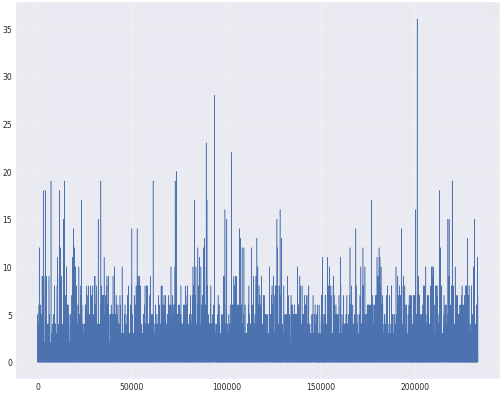

In [250]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['NO.OF_INQUIRIES'])
plt.legend(loc=1)
sns.set(font_scale=2)
plt.show()

In [251]:
data_new_1_nums = data_new_1_nums[data_new_1_nums['NO.OF_INQUIRIES'] < 20]
data_new_1 = data_new_1[data_new_1['NO.OF_INQUIRIES'] < 20]
data_new_2 = data_new_2[data_new_2['NO.OF_INQUIRIES'] < 20]

In [252]:
print(data_new_1_nums['NO.OF_INQUIRIES'].quantile(0.25))
print(data_new_1_nums['NO.OF_INQUIRIES'].quantile(0.50))
print(data_new_1_nums['NO.OF_INQUIRIES'].quantile(0.75))
print(data_new_1_nums['NO.OF_INQUIRIES'].quantile(0.95))
print(data_new_1_nums['NO.OF_INQUIRIES'].quantile(0.98))
print(data_new_1_nums['NO.OF_INQUIRIES'].quantile(0.99))
print(data_new_1_nums['NO.OF_INQUIRIES'].quantile(0.995))
print(data_new_1_nums['NO.OF_INQUIRIES'].quantile(0.998))
print(data_new_1_nums['NO.OF_INQUIRIES'].quantile(0.999))

0.0
0.0
0.0
1.0
2.0
3.0
4.0
6.0
8.0


In [253]:
def inq(i):
    if i >= 4 :
        return '4 or greater'
    else :
        return i

In [254]:
data_new_1_nums['NO.OF_INQUIRIES'] = data_new_1_nums['NO.OF_INQUIRIES'].apply(inq)
data_new_1['NO.OF_INQUIRIES'] = data_new_1['NO.OF_INQUIRIES'].apply(inq)
data_new_2['NO.OF_INQUIRIES'] = data_new_2['NO.OF_INQUIRIES'].apply(inq)

In [255]:
data_new_1_nums['NO.OF_INQUIRIES'].value_counts()

0               186713
1                19866
2                 4638
3                 1470
4 or greater      1446
Name: NO.OF_INQUIRIES, dtype: int64

In [256]:
no_INQUIRIES = data_new_1_nums[data_new_1_nums['NO.OF_INQUIRIES'] == 0]
one_INQUIRY = data_new_1_nums[data_new_1_nums['NO.OF_INQUIRIES'] == 1]
two_INQUIRIES  = data_new_1_nums[data_new_1_nums['NO.OF_INQUIRIES'] == 2]
three_INQUIRIES = data_new_1_nums[data_new_1_nums['NO.OF_INQUIRIES'] == 3]
high_INQUIRIES = data_new_1_nums[data_new_1_nums['NO.OF_INQUIRIES'] == '4 or greater']

In [257]:
print(no_INQUIRIES['loan_default'].value_counts()/no_INQUIRIES.shape[0])
print(one_INQUIRY['loan_default'].value_counts()/one_INQUIRY.shape[0])
print(two_INQUIRIES['loan_default'].value_counts()/two_INQUIRIES.shape[0])
print(three_INQUIRIES['loan_default'].value_counts()/three_INQUIRIES.shape[0])
print(high_INQUIRIES['loan_default'].value_counts()/high_INQUIRIES.shape[0])

0    0.78437
1    0.21563
Name: loan_default, dtype: float64
0    0.748515
1    0.251485
Name: loan_default, dtype: float64
0    0.71216
1    0.28784
Name: loan_default, dtype: float64
0    0.693197
1    0.306803
Name: loan_default, dtype: float64
0    0.64592
1    0.35408
Name: loan_default, dtype: float64


### Thus this is another important indicator of default.

'PC1', 'PC2', 'Age', 'AVERAGE.ACCT.AGE (in days)',
       'CREDIT.HISTORY.LENGTH (in days)

### 14) Age :

In [258]:
# Let's convert 'Age' to years from days :
data_new_1_nums['Age(in years)'] = round(data_new_1_nums['Age']/365.24,2)
data_new_1['Age(in years)'] = round(data_new_1['Age']/365.24,2)
data_new_2['Age(in years)'] = round(data_new_2['Age']/365.24,2)
data_new_1_nums = data_new_1_nums.drop(['Age'],axis=1)
data_new_1 = data_new_1.drop(['Age'],axis=1)
data_new_2 = data_new_2.drop(['Age'],axis=1)

In [259]:
data_new_1_nums['Age(in years)'].head()

0    34.18
1    33.16
2    32.38
3    24.82
4    41.04
Name: Age(in years), dtype: float64

No handles with labels found to put in legend.


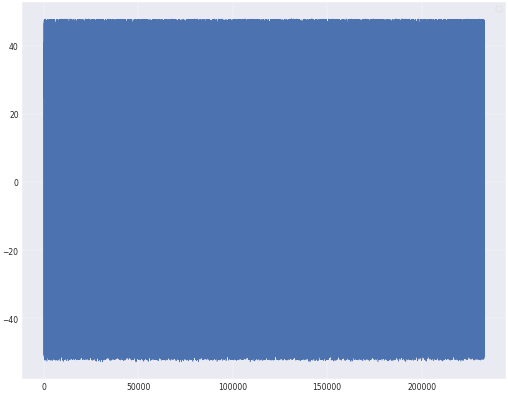

In [260]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['Age(in years)'])
plt.legend(loc=1)
sns.set(font_scale=2)
plt.show()

#### Thus clearly there are some values of 'Age' which are in negative. Now,this is an anomaly.Let's explore the dataframe 'data_new' to understand this :

#### The cause of having negative ages is some anomalous data values with 'Data of Births' which are greater than or after the 'Disbursal Date',and at times which hav not yet come. So we'll remove all of these values:

In [261]:
data_new_1_nums = data_new_1_nums[data_new_1_nums['Age(in years)'] >= 0]
data_new_1 = data_new_1[data_new_1['Age(in years)'] >= 0]
data_new_2 = data_new_2[data_new_2['Age(in years)'] >= 0]

In [262]:
data_new_1_nums['Age(in years)'].describe()

count    190253.000000
mean         31.848172
std           7.520951
min          17.420000
25%          25.530000
50%          30.780000
75%          37.730000
max          47.940000
Name: Age(in years), dtype: float64

In [263]:
data_new_1_nums.shape

(190253, 29)

No handles with labels found to put in legend.


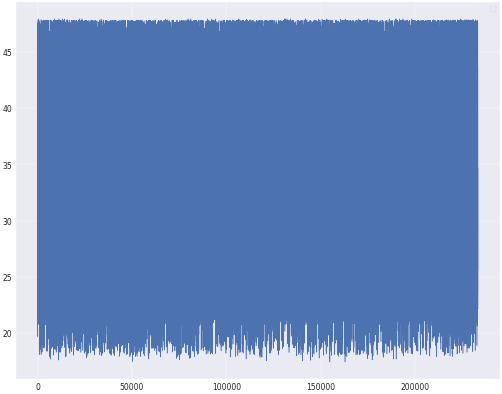

In [264]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['Age(in years)'])
plt.legend(loc=1)
sns.set(font_scale=2)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


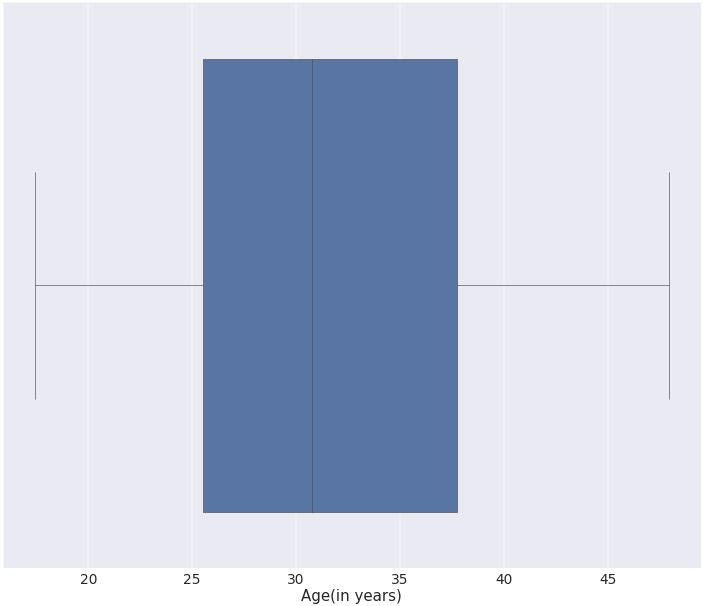

In [265]:
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['Age(in years)'])
plt.show()

In [266]:
young_age = data_new_1_nums[data_new_1_nums['Age(in years)'] <= 20]
working_age = data_new_1_nums[data_new_1_nums['Age(in years)'] > 20][data_new_1_nums['Age(in years)'] <= 40]
working_age_2 = data_new_1_nums[data_new_1_nums['Age(in years)'] > 40]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [267]:
print(young_age['loan_default'].value_counts()/young_age.shape[0])
print(working_age['loan_default'].value_counts()/working_age.shape[0])
print(working_age_2['loan_default'].value_counts()/working_age_2.shape[0])

0    0.75213
1    0.24787
Name: loan_default, dtype: float64
0    0.772402
1    0.227598
Name: loan_default, dtype: float64
0    0.790326
1    0.209674
Name: loan_default, dtype: float64


#### Thus the '40 or above' age group are the ones least likely to default.

### 15) AVERAGE.ACCT.AGE (in days) :

In [268]:
# Let's convert 'Age' to years from days :
data_new_1_nums['AVERAGE.ACCT.AGE (in years)'] = round(data_new_1_nums['AVERAGE.ACCT.AGE (in days)']/365.24,2)
data_new_1['AVERAGE.ACCT.AGE (in years)'] = round(data_new_1['AVERAGE.ACCT.AGE (in days)']/365.24,2)
data_new_2['AVERAGE.ACCT.AGE (in years)'] = round(data_new_2['AVERAGE.ACCT.AGE (in days)']/365.24,2)

data_new_1_nums = data_new_1_nums.drop(['AVERAGE.ACCT.AGE (in days)'],axis=1)
data_new_1 = data_new_1.drop(['AVERAGE.ACCT.AGE (in days)'],axis=1)
data_new_2 = data_new_2.drop(['AVERAGE.ACCT.AGE (in days)'],axis=1)

No handles with labels found to put in legend.


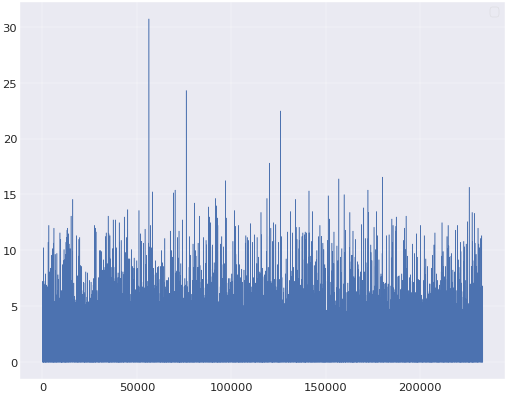

In [269]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['AVERAGE.ACCT.AGE (in years)'])
plt.legend(loc=1)
sns.set(font_scale=2)
plt.show()

In [270]:
data_new_1_nums = data_new_1_nums[data_new_1_nums['AVERAGE.ACCT.AGE (in years)'] < 17.5]
data_new_1 = data_new_1[data_new_1['AVERAGE.ACCT.AGE (in years)'] < 17.5]
data_new_2 = data_new_2[data_new_2['AVERAGE.ACCT.AGE (in years)'] < 17.5]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


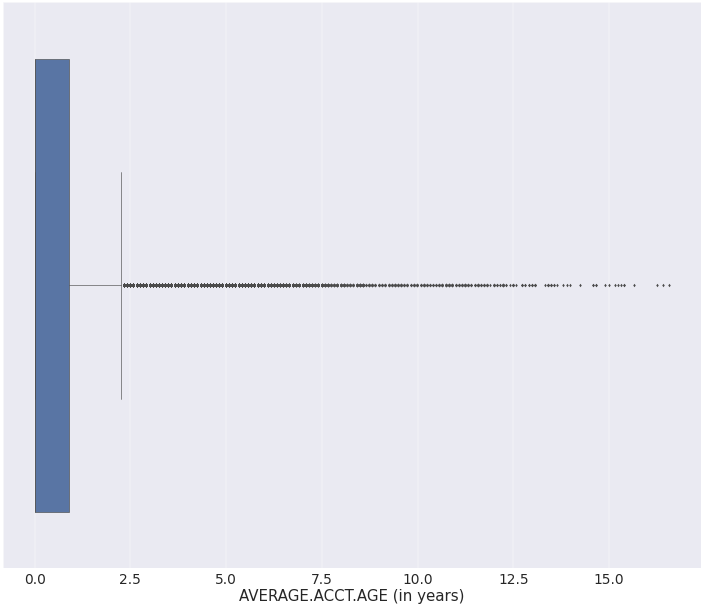

In [271]:
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['AVERAGE.ACCT.AGE (in years)'])
plt.show()

In [272]:
print(data_new_1_nums['AVERAGE.ACCT.AGE (in years)'].quantile(0.25))
print(data_new_1_nums['AVERAGE.ACCT.AGE (in years)'].quantile(0.50))
print(data_new_1_nums['AVERAGE.ACCT.AGE (in years)'].quantile(0.75))
print(data_new_1_nums['AVERAGE.ACCT.AGE (in years)'].quantile(0.95))
print(data_new_1_nums['AVERAGE.ACCT.AGE (in years)'].quantile(0.98))
print(data_new_1_nums['AVERAGE.ACCT.AGE (in years)'].quantile(0.99))
print(data_new_1_nums['AVERAGE.ACCT.AGE (in years)'].quantile(0.995))
print(data_new_1_nums['AVERAGE.ACCT.AGE (in years)'].quantile(0.998))
print(data_new_1_nums['AVERAGE.ACCT.AGE (in years)'].quantile(0.999))

0.0
0.0
0.9
2.82
4.08
5.24
6.57
8.49
10.550160000000616


In [273]:
data_new_1_nums['AVERAGE.ACCT.AGE (in years)'] = round(data_new_1_nums['AVERAGE.ACCT.AGE (in years)'],2)

In [274]:
for i in data_new_1_nums['AVERAGE.ACCT.AGE (in years)']:
    if i > 7 :
        data_new_1_nums['AVERAGE.ACCT.AGE (in years)'].replace({i : 7},inplace=True)
        
for i in data_new_1['AVERAGE.ACCT.AGE (in years)']:
    if i > 7 :
        data_new_1['AVERAGE.ACCT.AGE (in years)'].replace({i : 7},inplace=True)
        
for i in data_new_2['AVERAGE.ACCT.AGE (in years)']:
    if i > 7 :
        data_new_2['AVERAGE.ACCT.AGE (in years)'].replace({i : 7},inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


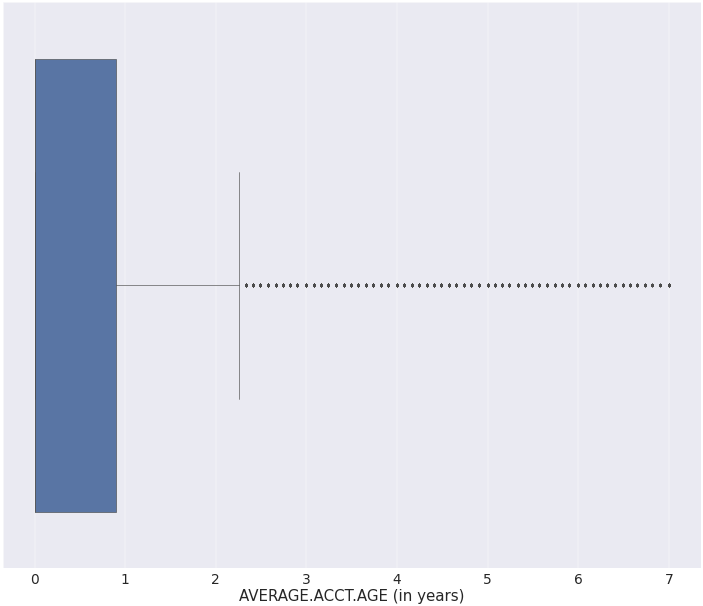

In [275]:
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['AVERAGE.ACCT.AGE (in years)'])
plt.show()

In [276]:
zero_accountage = data_new_1_nums[data_new_1_nums['AVERAGE.ACCT.AGE (in years)'] == 0]
more_accountage = data_new_1_nums[data_new_1_nums['AVERAGE.ACCT.AGE (in years)'] > 0][data_new_1_nums['AVERAGE.ACCT.AGE (in years)'] < 3 ]
high_accountage = data_new_1_nums[data_new_1_nums['AVERAGE.ACCT.AGE (in years)'] >= 3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [277]:
print(zero_accountage['loan_default'].value_counts()/zero_accountage.shape[0])
print(more_accountage['loan_default'].value_counts()/more_accountage.shape[0])
print(high_accountage['loan_default'].value_counts()/high_accountage.shape[0])

0    0.766091
1    0.233909
Name: loan_default, dtype: float64
0    0.787532
1    0.212468
Name: loan_default, dtype: float64
0    0.781924
1    0.218076
Name: loan_default, dtype: float64


In [278]:
print(data_new_1_nums.shape)
print(data_new_1.shape)
print(data_new_2.shape)

(190249, 29)
(190249, 33)
(190249, 21)


### 16) CREDIT.HISTORY.LENGTH (in days) :

In [279]:
# Let's convert 'Age' to years from days :
data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'] = round(data_new_1_nums['CREDIT.HISTORY.LENGTH (in days)']/365.24,2)
data_new_1['CREDIT.HISTORY.LENGTH (in years)'] = round(data_new_1['CREDIT.HISTORY.LENGTH (in days)']/365.24,2)
data_new_2['CREDIT.HISTORY.LENGTH (in years)'] = round(data_new_2['CREDIT.HISTORY.LENGTH (in days)']/365.24,2)

data_new_1_nums = data_new_1_nums.drop(['CREDIT.HISTORY.LENGTH (in days)'],axis=1)
data_new_1 = data_new_1.drop(['CREDIT.HISTORY.LENGTH (in days)'],axis=1)
data_new_2 = data_new_2.drop(['CREDIT.HISTORY.LENGTH (in days)'],axis=1)

No handles with labels found to put in legend.


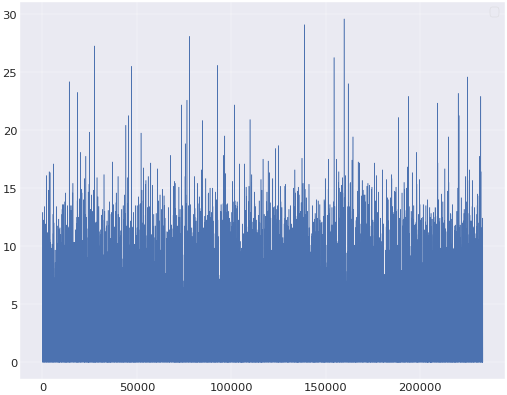

In [280]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'])
plt.legend(loc=1)
sns.set(font_scale=2)
plt.show()

In [281]:
data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'].head()

0    0.00
1    1.90
2    0.00
3    1.25
4    0.00
Name: CREDIT.HISTORY.LENGTH (in years), dtype: float64

In [282]:
data_new_1_nums = data_new_1_nums[data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'] <= 20]
data_new_1 = data_new_1[data_new_1['CREDIT.HISTORY.LENGTH (in years)'] <= 20]
data_new_2 = data_new_2[data_new_2['CREDIT.HISTORY.LENGTH (in years)'] <= 20]

No handles with labels found to put in legend.


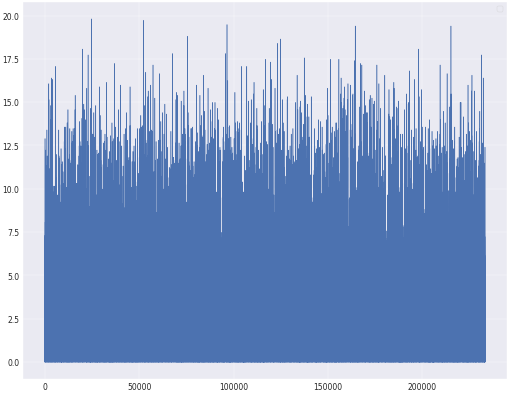

In [283]:
plt.figure(figsize=(25,20),dpi=25)
plt.plot(data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'])
plt.legend(loc=1)
sns.set(font_scale=2)
plt.show()

In [284]:
print(data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'].quantile(0.25))
print(data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'].quantile(0.50))
print(data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'].quantile(0.75))
print(data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'].quantile(0.95))
print(data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'].quantile(0.98))
print(data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'].quantile(0.99))
print(data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'].quantile(0.995))
print(data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'].quantile(0.998))
print(data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'].quantile(0.999))

0.0
0.0
1.49
4.74
7.08
9.57
11.4
12.9
13.99


In [285]:
data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'].nunique()

219

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


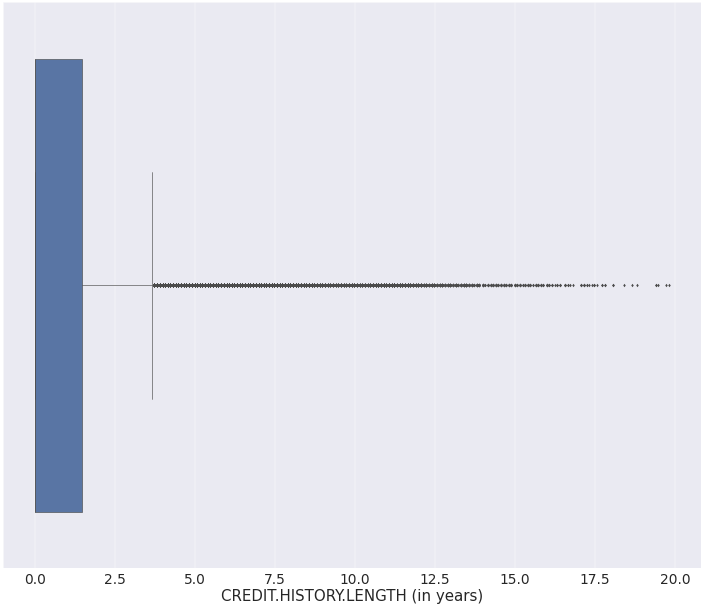

In [286]:
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'])
plt.show()

In [287]:
data_new_1_nums = data_new_1_nums[data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'] <= data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'].quantile(0.998)]
data_new_1 = data_new_1[data_new_1['CREDIT.HISTORY.LENGTH (in years)'] <= data_new_1['CREDIT.HISTORY.LENGTH (in years)'].quantile(0.998)]
data_new_2 = data_new_2[data_new_2['CREDIT.HISTORY.LENGTH (in years)'] <= data_new_2['CREDIT.HISTORY.LENGTH (in years)'].quantile(0.998)]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


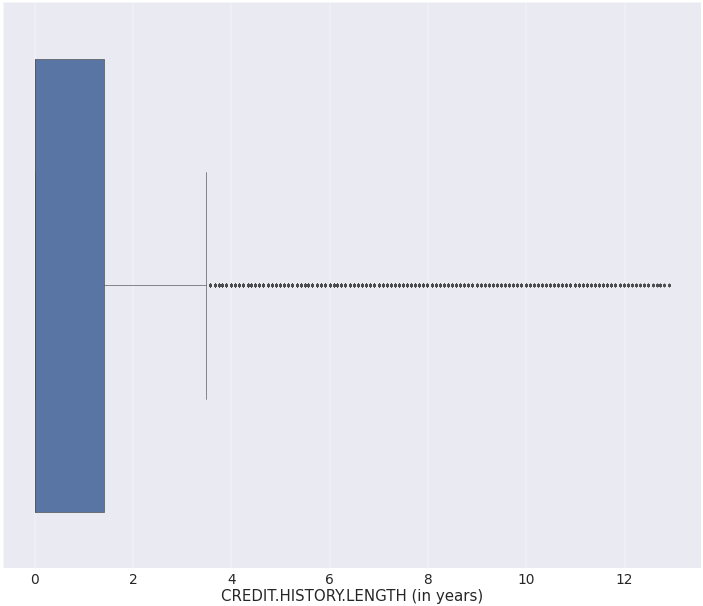

In [288]:
plt.figure(figsize=(30,25),dpi=30)
sns.set(font_scale=3)
sns.boxplot(data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'])
plt.show()

In [289]:
zero_credithistory = data_new_1_nums[data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'] == 0]
long_credithistory = data_new_1_nums[data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'] > 0][data_new_1_nums['AVERAGE.ACCT.AGE (in years)'] < 5 ]
longer_credithistory = data_new_1_nums[data_new_1_nums['CREDIT.HISTORY.LENGTH (in years)'] >= 5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [290]:
print(zero_credithistory['loan_default'].value_counts()/zero_credithistory.shape[0])
print(long_credithistory['loan_default'].value_counts()/long_credithistory.shape[0])
print(longer_credithistory['loan_default'].value_counts()/longer_credithistory.shape[0])

0    0.766345
1    0.233655
Name: loan_default, dtype: float64
0    0.786265
1    0.213735
Name: loan_default, dtype: float64
0    0.810526
1    0.189474
Name: loan_default, dtype: float64


### So clearly as expected length of Credit History has a negative correlation with loan default,i.e. the longer the credit history of a customer, the lesser are his chances of defaulting.

In [291]:
print(data_new_1_nums.shape)
print(data_new_1.shape)
print(data_new_2.shape)

(189848, 29)
(189848, 33)
(189848, 21)


### 17) PERFORM_CNS.SCORE :

In [292]:
data_new_2.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'manufacturer_id',
       'Employment.Type', 'PERFORM_CNS.SCORE', 'PERFORM_CNS.SCORE.DESCRIPTION',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'NO.OF_INQUIRIES', 'loan_default', 'TOTAL_NO_OF_ACCTS',
       'TOTAL_ACTIVE_ACCTS', 'TOTAL_OVERDUE_ACCTS', 'OVERALL_CURRENT_BALANCE',
       'OVERALL_DISBURSED_AMOUNT', 'TOTAL_INSTAL_AMT', 'Age(in years)',
       'AVERAGE.ACCT.AGE (in years)', 'CREDIT.HISTORY.LENGTH (in years)'],
      dtype='object')

#### For understanding and analysing this variable 'PERFORM_CNS.SCORE', we need help of the variable 'PERFORM_CNS.SCORE.DESCRIPTION' :

In [293]:
data_new_1.shape

(189848, 33)

In [294]:
data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts()

No Bureau History Available                                103418
C-Very Low Risk                                             13180
A-Very Low Risk                                             11607
D-Very Low Risk                                              8499
B-Very Low Risk                                              6649
F-Low Risk                                                   6016
M-Very High Risk                                             5796
K-High Risk                                                  5103
H-Medium Risk                                                5009
I-Medium Risk                                                4056
E-Low Risk                                                   3930
Not Scored: Sufficient History Not Available                 3349
Not Scored: Not Enough Info available on the customer        3193
G-Low Risk                                                   2663
J-High Risk                                                  2398
Not Scored

In [295]:
# Sum of not scored ones :
2942 + 2789 + 1989 + 1073 + 703

9496

In [296]:
# Checking percentage of 'No Bureau History available' cases :
164049/2

82024.5

#### Out of all these different types of CNS scores,we have more than half of the entire records who don't have a bureau history at all,and a lot many who are not scored due to various reasons.Let's explore them one by one:

In [297]:
data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'No Bureau History Available'].head()

UniqueID  disbursed_amount  asset_cost    ltv manufacturer_id  \
0    420825             50578       58400  89.55              45   
2    417566             53278       61360  89.63              45   
4    539055             52378       60300  88.39              45   
6    529269             46349       61500  76.42              45   
22   563215             43594       78256  57.50              86   

   Employment.Type  PERFORM_CNS.SCORE PERFORM_CNS.SCORE.DESCRIPTION  \
0         Salaried                  0   No Bureau History Available   
2    Self employed                  0   No Bureau History Available   
4    Self employed                  0   No Bureau History Available   
6         Salaried                  0   No Bureau History Available   
22   Self employed                  0   No Bureau History Available   

    PRI.NO.OF.ACCTS  PRI.ACTIVE.ACCTS  PRI.OVERDUE.ACCTS  PRI.CURRENT.BALANCE  \
0                 0                 0                  0                    0   
2                 0                 0                  0                    0   
4                 0                 0                  0                    0   
6                 0                 0                  0                    0   
22                0                 0                  0                    0   

    PRI.DISBURSED.AMOUNT  SEC.NO.OF.ACCTS  SEC.ACTIVE.ACCTS  \
0                      0                0                 0   
2                      0                0                 0   
4                      0                0                 0   
6                      0                0                 0   
22                     0                0                 0   

    SEC.OVERDUE.ACCTS  SEC.CURRENT.BALANCE  SEC.DISBURSED.AMOUNT  \
0                   0                    0                     0   
2                   0                    0                     0   
4                   0                    0                     0   
6                   0                    0                     0   
22                  0                    0                     0   

    PRIMARY.INSTAL.AMT  SEC.INSTAL.AMT NEW.ACCTS.IN.LAST.SIX.MONTHS  \
0                    0               0                            0   
2                    0               0                            0   
4                    0               0                            0   
6                    0               0                            0   
22                   0               0                            0   

   DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS NO.OF_INQUIRIES  loan_default  \
0                                    0               0             0   
2                                    0               0             0   
4                                    0               1             1   
6                                    0               0             0   
22                                   0               0             0   

    TOTAL_NO_OF_ACCTS  TOTAL_ACTIVE_ACCTS  TOTAL_OVERDUE_ACCTS  \
0                   0                   0                    0   
2                   0                   0                    0   
4                   0                   0                    0   
6                   0                   0                    0   
22                  0                   0                    0   

    OVERALL_CURRENT_BALANCE  OVERALL_DISBURSED_AMOUNT  TOTAL_INSTAL_AMT  \
0                         0                         0                 0   
2                         0                         0                 0   
4                         0                         0                 0   
6                         0                         0                 0   
22                        0                         0                 0   

    Age(in years)  AVERAGE.ACCT.AGE (in years)  \
0           34.18                          0.0   
2           32.38                          0.0   
4           41.04                 

In [298]:
data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'No Bureau History Available']['PERFORM_CNS.SCORE'].value_counts()

0    103418
Name: PERFORM_CNS.SCORE, dtype: int64

#### For those without a bureau history available the score assigned is 0.

In [299]:
data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'No Bureau History Available']['loan_default'].value_counts()/data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'No Bureau History Available'].shape[0]

0    0.766453
1    0.233547
Name: loan_default, dtype: float64

#### Here since 76.65% of the customers have not defaulted, it clearly means that not having a bureau history doesn't necessarily mean that one is likely to default. 

In [300]:
data_new_1['loan_default'].value_counts()

0    147194
1     42654
Name: loan_default, dtype: int64

### Now we'll explore all the cases which are not scored.

### I) Not Scored: Sufficient History Not Available :

In [301]:
data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: Sufficient History Not Available'].head()

UniqueID  disbursed_amount  asset_cost    ltv manufacturer_id  \
46    566809             48349       67650  72.43              45   
145   633425             46349       65687  71.55              86   
149   527969             52003       68695  76.72              86   
157   426993             50303       67099  76.01              86   
449   597809             50303       64226  80.96              45   

    Employment.Type  PERFORM_CNS.SCORE  \
46         Salaried                 15   
145        Salaried                 15   
149        Salaried                 15   
157   Self employed                 15   
449        Salaried                 15   

                    PERFORM_CNS.SCORE.DESCRIPTION  PRI.NO.OF.ACCTS  \
46   Not Scored: Sufficient History Not Available                1   
145  Not Scored: Sufficient History Not Available                1   
149  Not Scored: Sufficient History Not Available                1   
157  Not Scored: Sufficient History Not Available                3   
449  Not Scored: Sufficient History Not Available                1   

     PRI.ACTIVE.ACCTS  PRI.OVERDUE.ACCTS  PRI.CURRENT.BALANCE  \
46                  1                  0               155000   
145                 1                  0                 5470   
149                 1                  0                 8455   
157                 3                  1                 7960   
449                 1                  0                 4930   

     PRI.DISBURSED.AMOUNT  SEC.NO.OF.ACCTS  SEC.ACTIVE.ACCTS  \
46                 155000                0                 0   
145                  5470                0                 0   
149                 14500                0                 0   
157                  7960                0                 0   
449                 20000                0                 0   

     SEC.OVERDUE.ACCTS  SEC.CURRENT.BALANCE  SEC.DISBURSED.AMOUNT  \
46                   0                    0                     0   
145                  0                    0                     0   
149                  0                    0                     0   
157                  0                    0                     0   
449                  0                    0                     0   

     PRIMARY.INSTAL.AMT  SEC.INSTAL.AMT NEW.ACCTS.IN.LAST.SIX.MONTHS  \
46                    0               0                            1   
145                 954               0                            1   
149                1209               0                            1   
157                1464               0                            2   
449                   0               0                            1   

    DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS NO.OF_INQUIRIES  loan_default  \
46                                    0               1             0   
145                                   0               1             0   
149                                   0               0             0   
157                                   1               1             1   
449                                   0               0             0   

     TOTAL_NO_OF_ACCTS  TOTAL_ACTIVE_ACCTS  TOTAL_OVERDUE_ACCTS  \
46                   1                   1                    0   
145                  1                   1                    0   
149                  1                   1                    0   
157                  3                   3                    1   
449                  1                   1                    0   

     OVERALL_CURRENT_BALANCE  OVERALL_DISBURSED_AMOUNT  TOTAL_INSTAL_AMT  \
46                    155000                    155000                 0   
145                     5470                      5470               954   
149                     8455                     14500              1209   
157                     7960                      7960              1464   
449                     4930                     20000               

In [302]:
data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: Sufficient History Not Available']['loan_default'].value_counts()/data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: Sufficient History Not Available'].shape[0]

0    0.74261
1    0.25739
Name: loan_default, dtype: float64

In [303]:
data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: Sufficient History Not Available']['PERFORM_CNS.SCORE'].value_counts()

15    3349
Name: PERFORM_CNS.SCORE, dtype: int64

### II) Not Scored: Not Enough Info available on the customer :

In [304]:
data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: Not Enough Info available on the customer'].head()

UniqueID  disbursed_amount  asset_cost    ltv manufacturer_id  \
7    510278             43894       61900  71.89              45   
15   600655             47549       61400  79.80              45   
73   433647             48468       65500  77.86              45   
79   653618             48258       63896  80.60              45   
98   493843             49458       63000  82.54              45   

   Employment.Type  PERFORM_CNS.SCORE  \
7         Salaried                 17   
15        Salaried                 17   
73        Salaried                 17   
79        Salaried                 17   
98        Salaried                 17   

                            PERFORM_CNS.SCORE.DESCRIPTION  PRI.NO.OF.ACCTS  \
7   Not Scored: Not Enough Info available on the customer                1   
15  Not Scored: Not Enough Info available on the customer                1   
73  Not Scored: Not Enough Info available on the customer                1   
79  Not Scored: Not Enough Info available on the customer                1   
98  Not Scored: Not Enough Info available on the customer                1   

    PRI.ACTIVE.ACCTS  PRI.OVERDUE.ACCTS  PRI.CURRENT.BALANCE  \
7                  1                  0                72879   
15                 0                  0                    0   
73                 1                  0                58558   
79                 1                  0                51500   
98                 1                  0               282809   

    PRI.DISBURSED.AMOUNT  SEC.NO.OF.ACCTS  SEC.ACTIVE.ACCTS  \
7                  74500                0                 0   
15                     0                0                 0   
73                 48220                0                 0   
79                 51500                0                 0   
98                292906                0                 0   

    SEC.OVERDUE.ACCTS  SEC.CURRENT.BALANCE  SEC.DISBURSED.AMOUNT  \
7                   0                    0                     0   
15                  0                    0                     0   
73                  0                    0                     0   
79                  0                    0                     0   
98                  0                    0                     0   

    PRIMARY.INSTAL.AMT  SEC.INSTAL.AMT NEW.ACCTS.IN.LAST.SIX.MONTHS  \
7                    0               0                            0   
15                7900               0                            1   
73                   0               0                            1   
79                   0               0                            1   
98                   0               0                            1   

   DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS NO.OF_INQUIRIES  loan_default  \
7                                    0               0             0   
15                                   0               0             1   
73                                   0               0             1   
79                                   0               0             0   
98                                   0               0             1   

    TOTAL_NO_OF_ACCTS  TOTAL_ACTIVE_ACCTS  TOTAL_OVERDUE_ACCTS  \
7                   1                   1                    0   
15                  1                   0                    0   
73                  1                   1                    0   
79                  1                   1                    0   
98                  1                   1                    0   

    OVERALL_CURRENT_BALANCE  OVERALL_DISBURSED_AMOUNT  TOTAL_INSTAL_AMT  \
7                     72879                     74500                 0   
15                        0                         0              7900   
73                    58558                     48220                 0   
79                    51500                     51500                 0   
98                   282809                    292906                 0  

In [305]:
data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: Not Enough Info available on the customer']['loan_default'].value_counts()/data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: Not Enough Info available on the customer'].shape[0]

0    0.786721
1    0.213279
Name: loan_default, dtype: float64

In [306]:
data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: Not Enough Info available on the customer']['PERFORM_CNS.SCORE'].value_counts()

17    3193
Name: PERFORM_CNS.SCORE, dtype: int64

### III) Not Scored: No Activity seen on the customer (Inactive) :

In [307]:
data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: No Activity seen on the customer (Inactive)'].head()

UniqueID  disbursed_amount  asset_cost    ltv manufacturer_id  \
44    529381             57213       64750  89.88              45   
159   632900             52303       68695  77.15              86   
471   595694             44599       66245  69.44              45   
605   583539             48349       67540  72.55              45   
637   484730             54613       66651  84.92              86   

    Employment.Type  PERFORM_CNS.SCORE  \
44         Salaried                 16   
159   Self employed                 16   
471   Self employed                 16   
605   Self employed                 16   
637        Salaried                 16   

                               PERFORM_CNS.SCORE.DESCRIPTION  PRI.NO.OF.ACCTS  \
44   Not Scored: No Activity seen on the customer (Inactive)                1   
159  Not Scored: No Activity seen on the customer (Inactive)                1   
471  Not Scored: No Activity seen on the customer (Inactive)                1   
605  Not Scored: No Activity seen on the customer (Inactive)                1   
637  Not Scored: No Activity seen on the customer (Inactive)                2   

     PRI.ACTIVE.ACCTS  PRI.OVERDUE.ACCTS  PRI.CURRENT.BALANCE  \
44                  0                  0                    0   
159                 1                  0                    0   
471                 0                  0                    0   
605                 1                  0                    0   
637                 1                  0                56600   

     PRI.DISBURSED.AMOUNT  SEC.NO.OF.ACCTS  SEC.ACTIVE.ACCTS  \
44                      0                0                 0   
159                     0                0                 0   
471                     0                0                 0   
605                     0                0                 0   
637                 56600                0                 0   

     SEC.OVERDUE.ACCTS  SEC.CURRENT.BALANCE  SEC.DISBURSED.AMOUNT  \
44                   0                    0                     0   
159                  0                    0                     0   
471                  0                    0                     0   
605                  0                    0                     0   
637                  0                    0                     0   

     PRIMARY.INSTAL.AMT  SEC.INSTAL.AMT NEW.ACCTS.IN.LAST.SIX.MONTHS  \
44                    0               0                            0   
159                   0               0                            0   
471                   0               0                            0   
605                   0               0                            1   
637                2380               0                            1   

    DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS NO.OF_INQUIRIES  loan_default  \
44                                    0               0             0   
159                                   0               0             0   
471                                   0               0             0   
605                                   0               0             0   
637                                   0               0             0   

     TOTAL_NO_OF_ACCTS  TOTAL_ACTIVE_ACCTS  TOTAL_OVERDUE_ACCTS  \
44                   1                   0                    0   
159                  1                   1                    0   
471                  1                   0                    0   
605                  1                   1                    0   
637                  2                   1                    0   

     OVERALL_CURRENT_BALANCE  OVERALL_DISBURSED_AMOUNT  TOTAL_INSTAL_AMT  \
44                         0                         0                 0   
159                        0                         0                 0   
471                        0                         0                 0   
605                        0                         0                 0   
637

In [308]:
data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: No Activity seen on the customer (Inactive)']['loan_default'].value_counts()/data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: No Activity seen on the customer (Inactive)'].shape[0]

0    0.805812
1    0.194188
Name: loan_default, dtype: float64

In [309]:
data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: No Activity seen on the customer (Inactive)']['PERFORM_CNS.SCORE'].value_counts()

16    2271
Name: PERFORM_CNS.SCORE, dtype: int64

### IV) Not Scored: No Updates available in last 36 months :

In [310]:
data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: No Updates available in last 36 months'].head()

UniqueID  disbursed_amount  asset_cost    ltv manufacturer_id  \
408   497386             32484       60640  56.07              45   
477   644186             26529       64226  43.60              45   
587   582760             53303       66264  81.49              45   
661   438308             44345       66651  69.02              86   
739   531909             56013       72203  78.94              86   

    Employment.Type  PERFORM_CNS.SCORE  \
408   Self employed                 18   
477   Self employed                 18   
587        Salaried                 18   
661        Salaried                 18   
739   Self employed                 18   

                          PERFORM_CNS.SCORE.DESCRIPTION  PRI.NO.OF.ACCTS  \
408  Not Scored: No Updates available in last 36 months                1   
477  Not Scored: No Updates available in last 36 months                1   
587  Not Scored: No Updates available in last 36 months                1   
661  Not Scored: No Updates available in last 36 months                1   
739  Not Scored: No Updates available in last 36 months                1   

     PRI.ACTIVE.ACCTS  PRI.OVERDUE.ACCTS  PRI.CURRENT.BALANCE  \
408                 0                  0                    0   
477                 0                  0                    0   
587                 0                  0                    0   
661                 0                  0                    0   
739                 0                  0                    0   

     PRI.DISBURSED.AMOUNT  SEC.NO.OF.ACCTS  SEC.ACTIVE.ACCTS  \
408                     0                0                 0   
477                     0                0                 0   
587                     0                0                 0   
661                     0                0                 0   
739                     0                0                 0   

     SEC.OVERDUE.ACCTS  SEC.CURRENT.BALANCE  SEC.DISBURSED.AMOUNT  \
408                  0                    0                     0   
477                  0                    0                     0   
587                  0                    0                     0   
661                  0                    0                     0   
739                  0                    0                     0   

     PRIMARY.INSTAL.AMT  SEC.INSTAL.AMT NEW.ACCTS.IN.LAST.SIX.MONTHS  \
408                   0               0                            0   
477                   0               0                            0   
587                   0               0                            0   
661                   0               0                            0   
739                   0               0                            0   

    DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS NO.OF_INQUIRIES  loan_default  \
408                                   0               0             0   
477                                   0               0             0   
587                                   0               0             0   
661                                   0               0             0   
739                                   0               1             0   

     TOTAL_NO_OF_ACCTS  TOTAL_ACTIVE_ACCTS  TOTAL_OVERDUE_ACCTS  \
408                  1                   0                    0   
477                  1                   0                    0   
587                  1                   0                    0   
661                  1                   0                    0   
739                  1                   0                    0   

     OVERALL_CURRENT_BALANCE  OVERALL_DISBURSED_AMOUNT  TOTAL_INSTAL_AMT  \
408                        0                         0                 0   
477                        0                         0                 0   
587                        0                         0                 0   
661                        0                         0                 0   
739                        0     

In [311]:
data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: No Updates available in last 36 months']['loan_default'].value_counts()/data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: No Updates available in last 36 months'].shape[0]

0    0.808081
1    0.191919
Name: loan_default, dtype: float64

In [312]:
data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: No Updates available in last 36 months']['PERFORM_CNS.SCORE'].value_counts()

18    1188
Name: PERFORM_CNS.SCORE, dtype: int64

### V) Not Scored: Only a Guarantor :

In [313]:
data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: Only a Guarantor'].head()

UniqueID  disbursed_amount  asset_cost    ltv manufacturer_id  \
312    535895             48549       71763  69.40              86   
464    451638             42394       60640  72.56              45   
479    589852             47599       64226  76.29              45   
1025   462609             48310       81899  61.05              86   
2140   519501             50303       71904  72.32              86   

     Employment.Type  PERFORM_CNS.SCORE PERFORM_CNS.SCORE.DESCRIPTION  \
312    Self employed                 14  Not Scored: Only a Guarantor   
464    Self employed                 14  Not Scored: Only a Guarantor   
479    Self employed                 14  Not Scored: Only a Guarantor   
1025   Self employed                 14  Not Scored: Only a Guarantor   
2140        Salaried                 14  Not Scored: Only a Guarantor   

      PRI.NO.OF.ACCTS  PRI.ACTIVE.ACCTS  PRI.OVERDUE.ACCTS  \
312                 1                 0                  0   
464                 1                 1                  1   
479                 1                 1                  0   
1025                1                 1                  1   
2140                1                 1                  0   

      PRI.CURRENT.BALANCE  PRI.DISBURSED.AMOUNT  SEC.NO.OF.ACCTS  \
312                     0                     0                0   
464                116600                158000                0   
479                 17378                112000                0   
1025                41988                 55000                0   
2140               290595                580000                0   

      SEC.ACTIVE.ACCTS  SEC.OVERDUE.ACCTS  SEC.CURRENT.BALANCE  \
312                  0                  0                    0   
464                  0                  0                    0   
479                  0                  0                    0   
1025                 0                  0                    0   
2140                 0                  0                    0   

      SEC.DISBURSED.AMOUNT  PRIMARY.INSTAL.AMT  SEC.INSTAL.AMT  \
312                      0                2158               0   
464                      0                   0               0   
479                      0                   0               0   
1025                     0                1144               0   
2140                     0               12267               0   

     NEW.ACCTS.IN.LAST.SIX.MONTHS DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS  \
312                             0                                   0   
464                             0                                   0   
479                             0                                   0   
1025                            0                                   0   
2140                            0                                   0   

     NO.OF_INQUIRIES  loan_default  TOTAL_NO_OF_ACCTS  TOTAL_ACTIVE_ACCTS  \
312                0             0                  1                   0   
464                0             0                  1                   1   
479                0             1                  1                   1   
1025               0             0                  1                   1   
2140               0             0                  1                   1   

      TOTAL_OVERDUE_ACCTS  OVERALL_CURRENT_BALANCE  OVERALL_DISBURSED_AMOUNT  \
312                     0                        0                         0   
464                     1                   116600                    158000   
479                     0                    17378                    112000   
1025                    1                    41988                     55000   
2140                    0                   290595                    580000   

      TOTAL_INSTAL_AMT  Age(in years)  AVERAGE.ACCT.AGE (in years)  \
312               2158          42.73                         3.82   
464                  0          46.64         

In [314]:
data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: Only a Guarantor']['loan_default'].value_counts()/data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: Only a Guarantor'].shape[0]

0    0.778061
1    0.221939
Name: loan_default, dtype: float64

In [315]:
data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'Not Scored: Only a Guarantor']['PERFORM_CNS.SCORE'].value_counts()

14    784
Name: PERFORM_CNS.SCORE, dtype: int64

#### The difference between those without a Credit History, and those who are not scored is as follows :
- The ones who're not scored do have a certain credit history,but their credit history has something missing, or it's over 36 months old, or it's their history as a guarantor, and not as a main applicant etc because of which they all had some primary accounts at one point. But the ones without a credit history have no history of having taken credit at all . Thus they'll not be grouped together in this case.

In [316]:
# Replacing the values of all the datapoints which are not scored . 
data_new_1.loc[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Not Scored'),'PERFORM_CNS.SCORE.DESCRIPTION'] = 'Not Scored : Sufficient information not available'
data_new_1.loc[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Not Scored'),'PERFORM_CNS.SCORE'] = 15

In [317]:
data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts()

No Bureau History Available                          103418
C-Very Low Risk                                       13180
A-Very Low Risk                                       11607
Not Scored : Sufficient information not available     10785
D-Very Low Risk                                        8499
B-Very Low Risk                                        6649
F-Low Risk                                             6016
M-Very High Risk                                       5796
K-High Risk                                            5103
H-Medium Risk                                          5009
I-Medium Risk                                          4056
E-Low Risk                                             3930
G-Low Risk                                             2663
J-High Risk                                            2398
L-Very High Risk                                        739
Name: PERFORM_CNS.SCORE.DESCRIPTION, dtype: int64

In [318]:
'''data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Not Scored')==True]['PERFORM_CNS.SCORE.DESCRIPTION'] = data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Not Scored')==True]['PERFORM_CNS.SCORE.DESCRIPTION'].replace({i:'Not Scored'},inplace=True)'''
# An important lesson learnt here is that using '.loc' reduces the processing time tremenduously putting less pressure on the processor, instead of using '.replace' kind of functions on a nested bracketted sub-part of the entire dataframe.

"data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Not Scored')==True]['PERFORM_CNS.SCORE.DESCRIPTION'] = data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Not Scored')==True]['PERFORM_CNS.SCORE.DESCRIPTION'].replace({i:'Not Scored'},inplace=True)"

#### Since more than half of the customers have no bureau history available, we'll compare both bureau history available and not available in terms of loan default rates :

In [319]:
print(data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'No Bureau History Available']['loan_default'].value_counts()/data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] == 'No Bureau History Available'].shape[0])
print(data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] != 'No Bureau History Available']['loan_default'].value_counts()/data_new_1[data_new_1['PERFORM_CNS.SCORE.DESCRIPTION'] != 'No Bureau History Available'].shape[0])

0    0.766453
1    0.233547
Name: loan_default, dtype: float64
0    0.785942
1    0.214058
Name: loan_default, dtype: float64


### So now that all the preprocessing steps have been carried out, we'll re-analyse the categorical variables to make sure that all of their original values are preserved.

### 1) manufacturer_id :

In [320]:
data_new_1['manufacturer_id'].value_counts()

86     88904
45     48140
51     22252
48     14164
49      7870
120     7636
145      587
67       295
Name: manufacturer_id, dtype: int64

#### Now 'manufacturer_id' is a categorical variable. So it'll be converted to 'object' category :

In [321]:
data_new_1['manufacturer_id'] = data_new_1['manufacturer_id'].astype(str)

### Also it's to be noted that all the 8 categories of 'manufacturer_id' variable which were observed in the beginning are still present.So the variable has been preserved.

In [322]:
print('For manufacturer_id 86 : ','\n',data_new_1[data_new_1['manufacturer_id'] == '86']['loan_default'].value_counts()/data_new_1[data_new_1['manufacturer_id'] == '86'].shape[0])
print('For manufacturer_id 45 : ','\n',data_new_1[data_new_1['manufacturer_id'] == '45']['loan_default'].value_counts()/data_new_1[data_new_1['manufacturer_id'] == '45'].shape[0])
print('For manufacturer_id 51 : ','\n',data_new_1[data_new_1['manufacturer_id'] == '51']['loan_default'].value_counts()/data_new_1[data_new_1['manufacturer_id'] == '51'].shape[0])
print('For manufacturer_id 48 : ','\n',data_new_1[data_new_1['manufacturer_id'] == '48']['loan_default'].value_counts()/data_new_1[data_new_1['manufacturer_id'] == '48'].shape[0])
print('For manufacturer_id 49 : ','\n',data_new_1[data_new_1['manufacturer_id'] == '49']['loan_default'].value_counts()/data_new_1[data_new_1['manufacturer_id'] == '49'].shape[0])
print('For manufacturer_id 120 : ','\n',data_new_1[data_new_1['manufacturer_id'] == '120']['loan_default'].value_counts()/data_new_1[data_new_1['manufacturer_id'] == '120'].shape[0])
print('For manufacturer_id 145 : ','\n',data_new_1[data_new_1['manufacturer_id'] == '145']['loan_default'].value_counts()/data_new_1[data_new_1['manufacturer_id'] == '145'].shape[0])
print('For manufacturer_id 67 : ','\n',data_new_1[data_new_1['manufacturer_id'] == '67']['loan_default'].value_counts()/data_new_1[data_new_1['manufacturer_id'] == '67'].shape[0])

For manufacturer_id 86 :  
 0    0.787512
1    0.212488
Name: loan_default, dtype: float64
For manufacturer_id 45 :  
 0    0.766473
1    0.233527
Name: loan_default, dtype: float64
For manufacturer_id 51 :  
 0    0.782986
1    0.217014
Name: loan_default, dtype: float64
For manufacturer_id 48 :  
 0    0.719712
1    0.280288
Name: loan_default, dtype: float64
For manufacturer_id 49 :  
 0    0.778399
1    0.221601
Name: loan_default, dtype: float64
For manufacturer_id 120 :  
 0    0.765715
1    0.234285
Name: loan_default, dtype: float64
For manufacturer_id 145 :  
 0    0.776831
1    0.223169
Name: loan_default, dtype: float64
For manufacturer_id 67 :  
 0    0.80339
1    0.19661
Name: loan_default, dtype: float64


loan_default         0      1
manufacturer_id              
120               5847   1789
145                456    131
45               36898  11242
48               10194   3970
49                6126   1744
51               17423   4829
67                 237     58
86               70013  18891


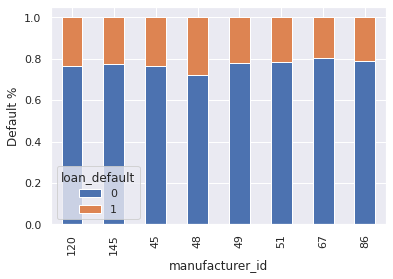

In [350]:
# Checking the distribution of defaults for each 'manufacturer_id' :
print(pd.crosstab(data_new_1["manufacturer_id"],data_new_1["loan_default"]))
manufacturer = pd.crosstab(data_new_1["manufacturer_id"],data_new_1["loan_default"])
manufacturer.div(manufacturer.sum(1).astype(float),axis=0).plot(kind="bar",stacked=True,figsize=(6,4))
plt.xlabel("manufacturer_id")
sns.set(font_scale=1)
plt.ylabel("Default %")
plt.show()

#### Thus,from the figure above it can be clearly seen that brand 48 has the highest default,and brand 67 has the least.

#### Since 'manufacturer_id' has a strong correlation with 'ltv' (loan to value ratio), we'll explore all of 'ltv','disbursed_amount' and 'asset_cost' with respect to the manufacturer_id by plotting as follows :

#### Distribution of 'manufacturer_id' with respect to 'ltv' :

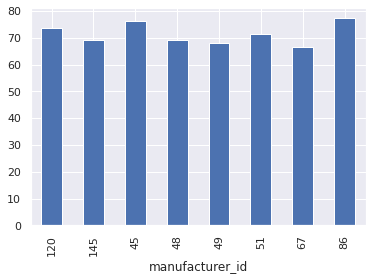

In [324]:
data_new_1.groupby('manufacturer_id')['ltv'].mean().plot.bar()

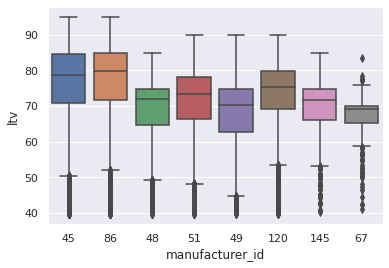

In [325]:
sns.boxplot(x='manufacturer_id',y='ltv',data=data_new_1)
sns.set(font_scale=1)
plt.show()

#### Distribution of 'manufacturer_id' with respect to 'disbursed_amount' :

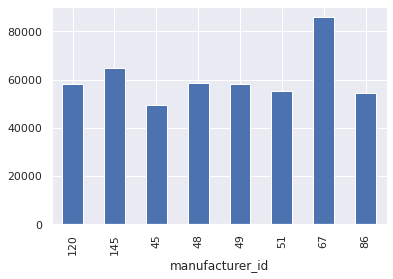

In [326]:
data_new_1.groupby('manufacturer_id')['disbursed_amount'].mean().plot.bar()

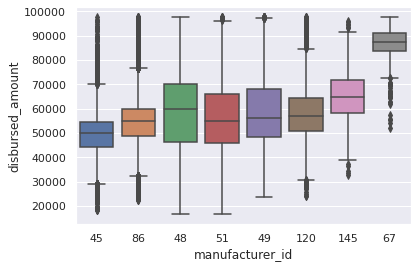

In [327]:
sns.boxplot(x='manufacturer_id',y='disbursed_amount',data=data_new_1)
sns.set(font_scale=1)
plt.show()

#### Distribution of 'manufacturer_id' with respect to 'asset_cost' :

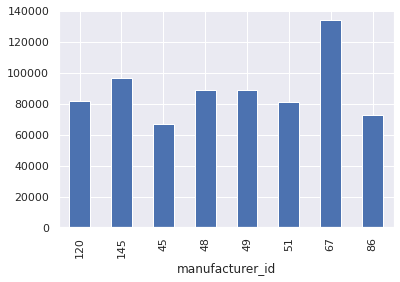

In [328]:
data_new_1.groupby('manufacturer_id')['asset_cost'].mean().plot.bar()

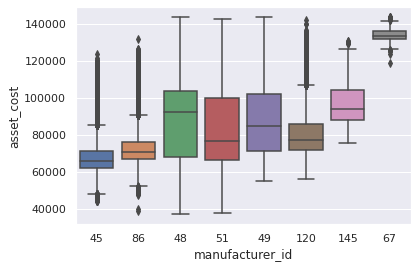

In [329]:
sns.boxplot(x='manufacturer_id',y='asset_cost',data=data_new_1)
sns.set(font_scale=1)
plt.show()

#### It can be clearly seen from all of the three plots above that :
- The brands represented by 45 and 86 are given the highest loan to values as compared to the others.
- The brand 67 has been disbursed the highest amount, and also has the highest cost.
- The brands 48 and 51 have the most widely spread range of values.

#### This can mean the following :
- The brands 45 and 86 represent the class of economy 2 wheeler vehicles,and hence amount-wise it's more easier for the lending Companies to provide them a higher loan amount closer to their vehicle price. It can also mean that the company has a better experience with the customers of this brand in terms of payment behaviour,and also the brand has a good durability.
- The brand 67 represents the class of luxury 2 wheeler automobiles,and thus has the smallest spread of the vehicle prices,mostly concentrated around the higher amounts.
- The brands 48 and 51 have the highest number of customers,and also make vehicles of all the classes,thus having the highest spread without outliers.


#### Let's also check the distribution of the 'PERFORM_CNS.SCORE' or CIBIL scores across all the different brands :

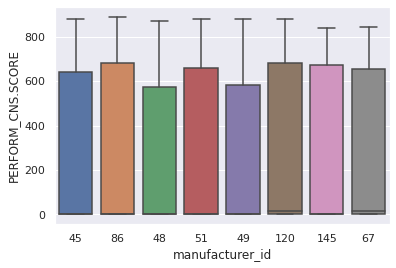

In [330]:
sns.boxplot(x='manufacturer_id',y='PERFORM_CNS.SCORE',data=data_new_1)
sns.set(font_scale=1)
plt.show()

In [331]:
# For checking the relation of 'manufacturer_id' across all the other variables (in case interested) : 
'''for i in data_new_1[['TOTAL_NO_OF_ACCTS','TOTAL_ACTIVE_ACCTS','TOTAL_OVERDUE_ACCTS','OVERALL_CURRENT_BALANCE','OVERALL_DISBURSED_AMOUNT','TOTAL_INSTAL_AMT','Age(in years)','AVERAGE.ACCT.AGE (in years)','CREDIT.HISTORY.LENGTH (in years)']].columns:
                          sns.boxplot(x='manufacturer_id',y=i,data=data_new_1)
                          sns.set(font_scale=1)
                          plt.show()'''

"for i in data_new_1[['TOTAL_NO_OF_ACCTS','TOTAL_ACTIVE_ACCTS','TOTAL_OVERDUE_ACCTS','OVERALL_CURRENT_BALANCE','OVERALL_DISBURSED_AMOUNT','TOTAL_INSTAL_AMT','Age(in years)','AVERAGE.ACCT.AGE (in years)','CREDIT.HISTORY.LENGTH (in years)']].columns:\n                          sns.boxplot(x='manufacturer_id',y=i,data=data_new_1)\n                          sns.set(font_scale=1)\n                          plt.show()"

### 2) Employment.Type :

In [332]:
data_new_1['Employment.Type'].value_counts()

Self employed    101522
Salaried          81465
Name: Employment.Type, dtype: int64

In [333]:
data_new_1.groupby('Employment.Type')['loan_default'].value_counts(normalize=True) 

Employment.Type  loan_default
Salaried         0               0.789186
                 1               0.210814
Self employed    0               0.764031
                 1               0.235969
Name: loan_default, dtype: float64

loan_default         0      1
Employment.Type              
Salaried         64291  17174
Self employed    77566  23956


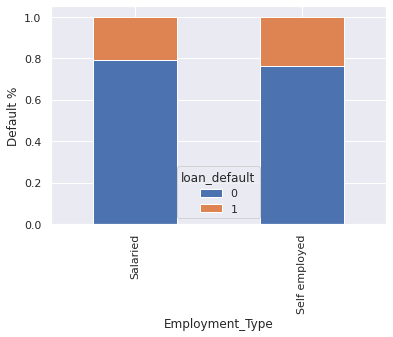

In [334]:
print(pd.crosstab(data_new_1["Employment.Type"],data_new_1["loan_default"]))
employment = pd.crosstab(data_new_1["Employment.Type"],data_new_1["loan_default"])
employment.div(employment.sum(1).astype(float),axis=0).plot(kind="bar",stacked=True,figsize=(6,4))
plt.xlabel("Employment_Type")
sns.set(font_scale=1)
plt.ylabel("Default %")
plt.show()

#### Thus clearly 'Self employed' ones have higher default rate.

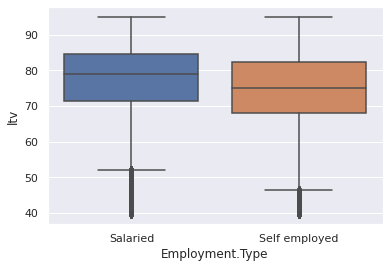

In [335]:
sns.boxplot(x='Employment.Type',y='ltv',data=data_new_1)
sns.set(font_scale=1)
plt.show()

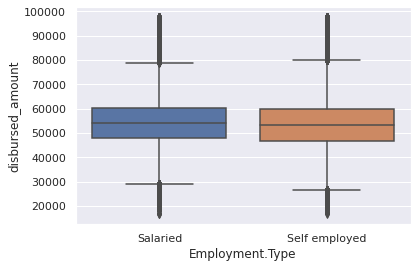

In [336]:
sns.boxplot(x='Employment.Type',y='disbursed_amount',data=data_new_1)
sns.set(font_scale=1)
plt.show()

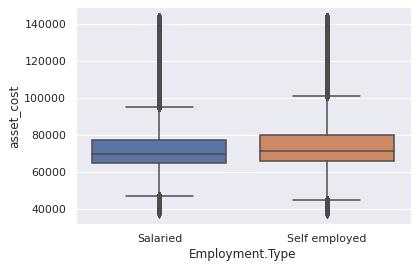

In [337]:
sns.boxplot(x='Employment.Type',y='asset_cost',data=data_new_1)
sns.set(font_scale=1)
plt.show()

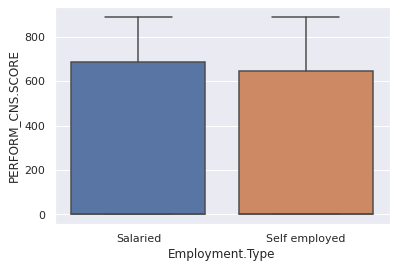

In [338]:
sns.boxplot(x='Employment.Type',y='PERFORM_CNS.SCORE',data=data_new_1)
sns.set(font_scale=1)
plt.show()

#### The following points can be noted here :
- The 'ltv ratio' of Salaried ones is slightly higher than the Self employed ones as naturally due to reduced risks the ratios in which loans are given is higher for Salaried ones.And on the same logic, the PERFORM_CNS.SCORE of the salaried employees is slightly higher.
- The asset_costs are slightly higher for the 'Salaried' ones despite the disbursed_amounts being almost equal for both.

In [339]:
# For checking the relation of 'Employment.Type' across all the other variables (in case interested) : 
'''for i in data_new_1[['TOTAL_NO_OF_ACCTS','TOTAL_ACTIVE_ACCTS','TOTAL_OVERDUE_ACCTS','OVERALL_CURRENT_BALANCE','OVERALL_DISBURSED_AMOUNT','TOTAL_INSTAL_AMT','Age(in years)','AVERAGE.ACCT.AGE (in years)','CREDIT.HISTORY.LENGTH (in years)']].columns:
                          sns.boxplot(x='Employment.Type',y=i,data=data_new_1)
                          sns.set(font_scale=1)
                          plt.show()'''

"for i in data_new_1[['TOTAL_NO_OF_ACCTS','TOTAL_ACTIVE_ACCTS','TOTAL_OVERDUE_ACCTS','OVERALL_CURRENT_BALANCE','OVERALL_DISBURSED_AMOUNT','TOTAL_INSTAL_AMT','Age(in years)','AVERAGE.ACCT.AGE (in years)','CREDIT.HISTORY.LENGTH (in years)']].columns:\n                          sns.boxplot(x='Employment.Type',y=i,data=data_new_1)\n                          sns.set(font_scale=1)\n                          plt.show()"

### Missing Value Treatment

In [340]:
data_new_1.isnull().mean()

UniqueID                               0.000000
disbursed_amount                       0.000000
asset_cost                             0.000000
ltv                                    0.000000
manufacturer_id                        0.000000
Employment.Type                        0.036139
PERFORM_CNS.SCORE                      0.000000
PERFORM_CNS.SCORE.DESCRIPTION          0.000000
PRI.NO.OF.ACCTS                        0.000000
PRI.ACTIVE.ACCTS                       0.000000
PRI.OVERDUE.ACCTS                      0.000000
PRI.CURRENT.BALANCE                    0.000000
PRI.DISBURSED.AMOUNT                   0.000000
SEC.NO.OF.ACCTS                        0.000000
SEC.ACTIVE.ACCTS                       0.000000
SEC.OVERDUE.ACCTS                      0.000000
SEC.CURRENT.BALANCE                    0.000000
SEC.DISBURSED.AMOUNT                   0.000000
PRIMARY.INSTAL.AMT                     0.000000
SEC.INSTAL.AMT                         0.000000
NEW.ACCTS.IN.LAST.SIX.MONTHS           0

#### Since no correlation was found between the loan default rates of the 2 employment types, it's decided to append the missing values as 'Missing' itself.

In [341]:
data_new_1[data_new_1['Employment.Type'].isnull()]['loan_default'].value_counts(normalize=True)

0    0.777875
1    0.222125
Name: loan_default, dtype: float64

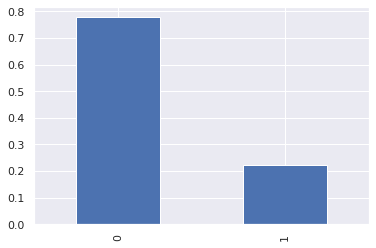

In [342]:
data_new_1[data_new_1['Employment.Type'].isnull()]['loan_default'].value_counts(normalize=True).plot(kind="bar",stacked=True,figsize=(6,4)) 

In [343]:
data_new_1['Employment.Type'] = data_new_1['Employment.Type'].fillna('Missing')

In [344]:
data_new_2['Employment.Type'] = data_new_2['Employment.Type'].fillna('Missing')

In [345]:
data_new_2.isnull().mean()

UniqueID                               0.0
disbursed_amount                       0.0
asset_cost                             0.0
ltv                                    0.0
manufacturer_id                        0.0
Employment.Type                        0.0
PERFORM_CNS.SCORE                      0.0
PERFORM_CNS.SCORE.DESCRIPTION          0.0
NEW.ACCTS.IN.LAST.SIX.MONTHS           0.0
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    0.0
NO.OF_INQUIRIES                        0.0
loan_default                           0.0
TOTAL_NO_OF_ACCTS                      0.0
TOTAL_ACTIVE_ACCTS                     0.0
TOTAL_OVERDUE_ACCTS                    0.0
OVERALL_CURRENT_BALANCE                0.0
OVERALL_DISBURSED_AMOUNT               0.0
TOTAL_INSTAL_AMT                       0.0
Age(in years)                          0.0
AVERAGE.ACCT.AGE (in years)            0.0
CREDIT.HISTORY.LENGTH (in years)       0.0
dtype: float64

### Feature Engineering :

In [346]:
data_new_2.dtypes

UniqueID                                object
disbursed_amount                         int64
asset_cost                               int64
ltv                                    float64
manufacturer_id                         object
Employment.Type                         object
PERFORM_CNS.SCORE                        int64
PERFORM_CNS.SCORE.DESCRIPTION           object
NEW.ACCTS.IN.LAST.SIX.MONTHS            object
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS     object
NO.OF_INQUIRIES                         object
loan_default                             int64
TOTAL_NO_OF_ACCTS                        int64
TOTAL_ACTIVE_ACCTS                       int64
TOTAL_OVERDUE_ACCTS                      int64
OVERALL_CURRENT_BALANCE                  int64
OVERALL_DISBURSED_AMOUNT                 int64
TOTAL_INSTAL_AMT                         int64
Age(in years)                          float64
AVERAGE.ACCT.AGE (in years)            float64
CREDIT.HISTORY.LENGTH (in years)       float64
dtype: object

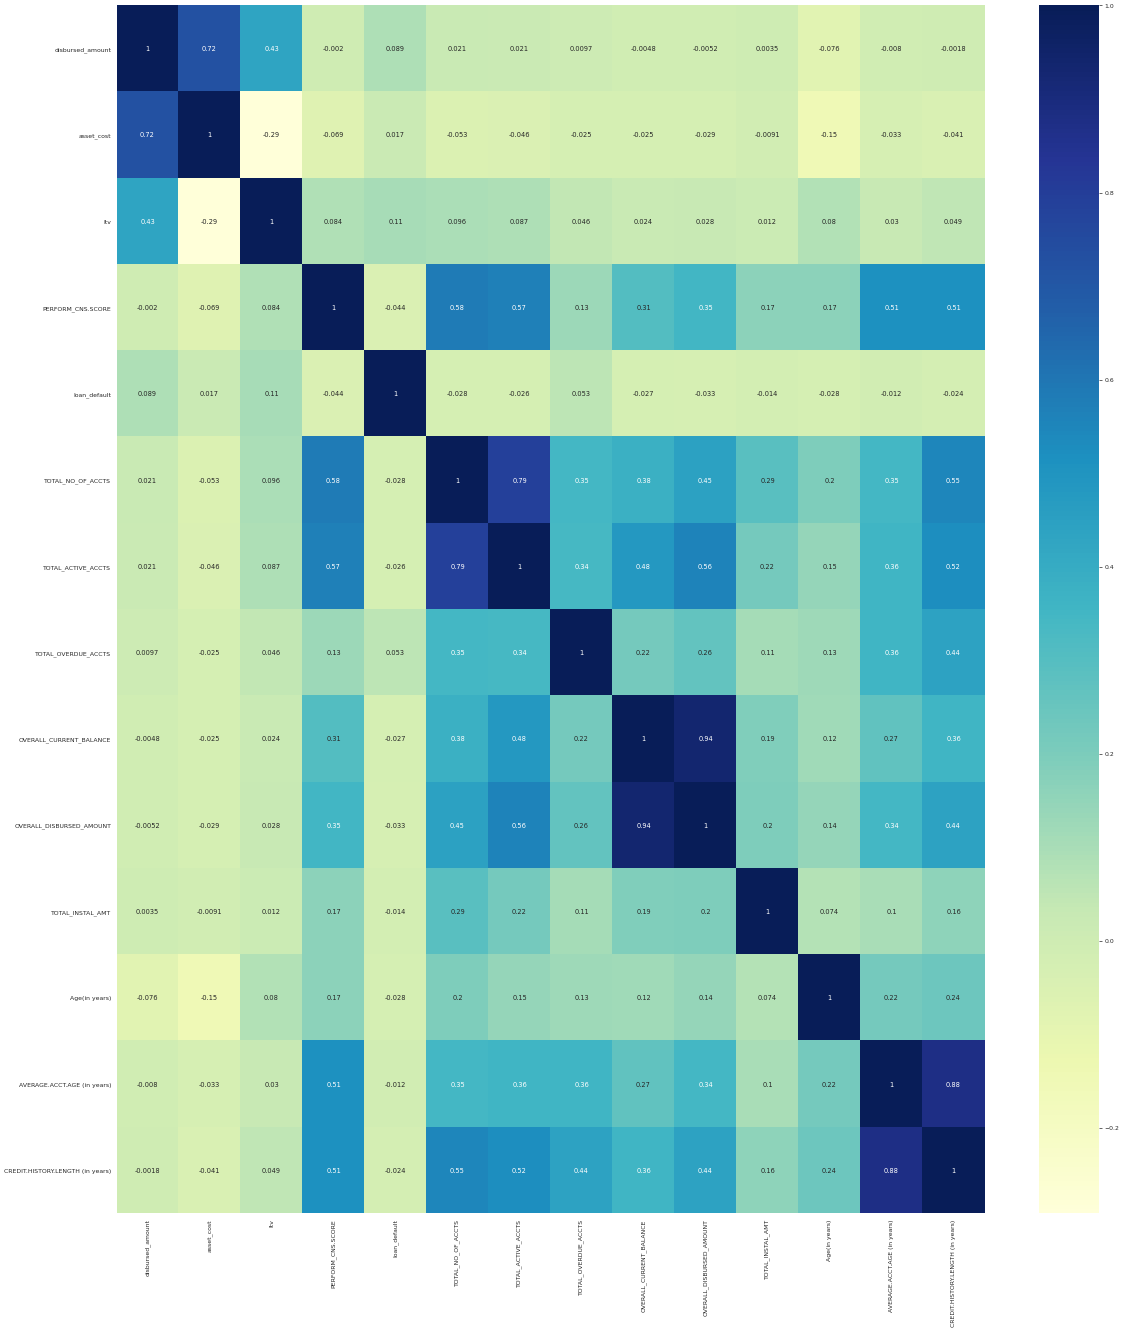

In [347]:
plt.figure(figsize=(35,40),dpi=40)
sns.heatmap(data_new_2.corr(),annot=True,cmap='YlGnBu')
sns.set(font_scale=1.8)
plt.show()

In [348]:
efbrgntyy

NameError: ignored

### New Variables Created :

### Note : Since most of the values are 0 for the variable 'TOTAL_ACTIVE_ACCTS',the resultant new variables will have a majority of 'NaN' values.Thus,to avoid this we're not creating these new variables here. However,one may make use of similar variables in datasets where the values as 0 are lesser, or in other words the 'sparsity' is lesser.

In [ ]:
data_new_2['ACCTS_CLEARED_RATIO'] = (data_new_2['TOTAL_NO_OF_ACCTS'] - data_new_2['TOTAL_ACTIVE_ACCTS'])/data_new_2['TOTAL_NO_OF_ACCTS']  # THis variable will indicate the 
data_new_2['OVERDUE_ACCTS_RATIO'] = data_new_2['TOTAL_OVERDUE_ACCTS']/data_new_2['TOTAL_NO_OF_ACCTS']

In [ ]:
data_new_2.isnull().mean()

In [ ]:
data_new_2[data_new_2['ACCTS_CLEARED_RATIO'].isnull()].head()

#### Creating dummy variables :

In [351]:
data_new_2 = pd.get_dummies(data_new_2,columns=['manufacturer_id','Employment.Type','NEW.ACCTS.IN.LAST.SIX.MONTHS','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','NO.OF_INQUIRIES'])

In [352]:
data_new_2.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv',
       'PERFORM_CNS.SCORE', 'PERFORM_CNS.SCORE.DESCRIPTION', 'loan_default',
       'TOTAL_NO_OF_ACCTS', 'TOTAL_ACTIVE_ACCTS', 'TOTAL_OVERDUE_ACCTS',
       'OVERALL_CURRENT_BALANCE', 'OVERALL_DISBURSED_AMOUNT',
       'TOTAL_INSTAL_AMT', 'Age(in years)', 'AVERAGE.ACCT.AGE (in years)',
       'CREDIT.HISTORY.LENGTH (in years)', 'manufacturer_id_120',
       'manufacturer_id_145', 'manufacturer_id_45', 'manufacturer_id_48',
       'manufacturer_id_49', 'manufacturer_id_51', 'manufacturer_id_67',
       'manufacturer_id_86', 'Employment.Type_Missing',
       'Employment.Type_Salaried', 'Employment.Type_Self employed',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS_0', 'NEW.ACCTS.IN.LAST.SIX.MONTHS_1',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS_2', 'NEW.ACCTS.IN.LAST.SIX.MONTHS_3',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS_4 or greater',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS_0',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS_1',
       'DELINQUENT

In [353]:
data_new_2 = data_new_2.drop(['PERFORM_CNS.SCORE.DESCRIPTION'],axis=1)

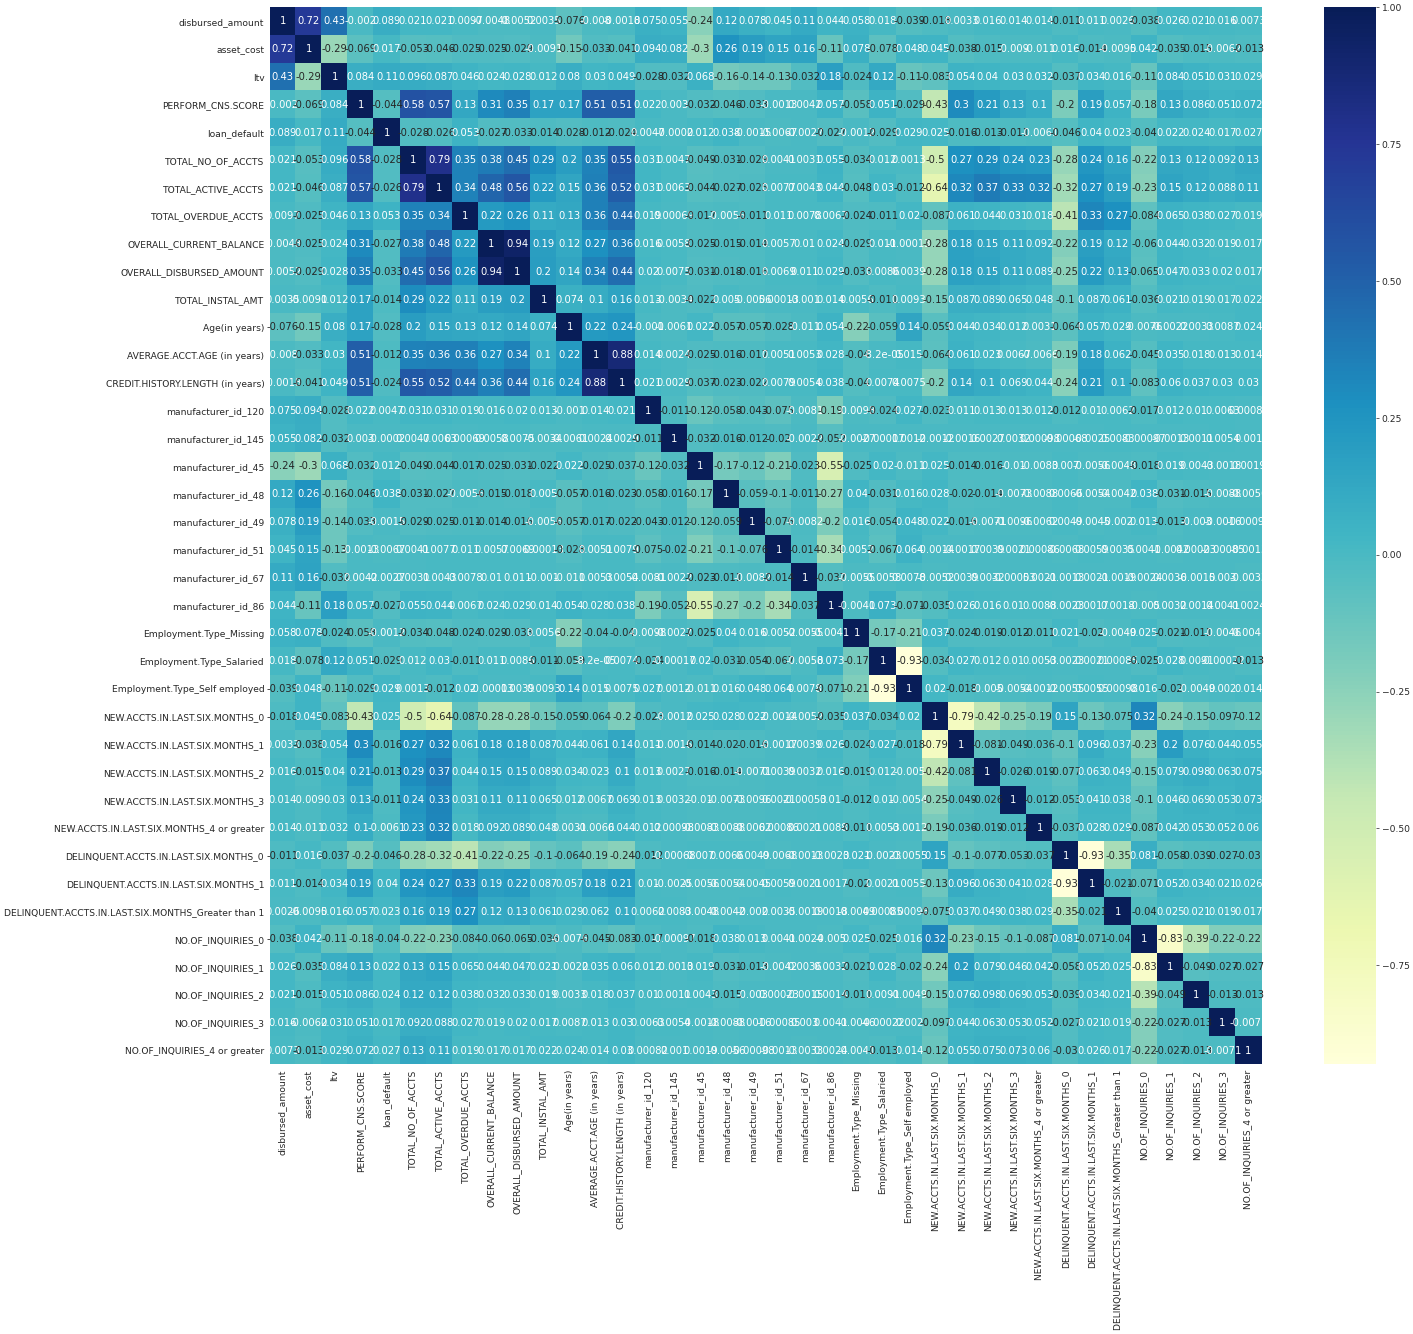

In [355]:
plt.figure(figsize=(40,35),dpi=40)
sns.heatmap(data_new_2.corr(),annot=True,cmap='YlGnBu')
sns.set(font_scale=1.5)
plt.show()

### With Target Variable Balancing :

#### For UnderSampling,we've used the NearMiss,CondensedNearestNeighbour and Tomek Links methods and arrived at poorer results than the standard normal technique of 'class weight=balanced' provided in sklearn.

In [356]:
# Splitting the data into independent and dependent sets, namely X and y :
y = data_new_2['loan_default']
X = data_new_2.drop(['loan_default','UniqueID'],axis=1) # Since both UniqueID and loan_default aren't needed anymore.

In [357]:
X.head()

disbursed_amount  asset_cost    ltv  PERFORM_CNS.SCORE  TOTAL_NO_OF_ACCTS  \
0             50578       58400  89.55                  0                  0   
1             47145       65550  73.23                598                  1   
2             53278       61360  89.63                  0                  0   
3             57513       66113  88.48                305                  3   
4             52378       60300  88.39                  0                  0   

   TOTAL_ACTIVE_ACCTS  TOTAL_OVERDUE_ACCTS  OVERALL_CURRENT_BALANCE  \
0                   0                    0                        0   
1                   1                    1                    27600   
2                   0                    0                        0   
3                   0                    0                        0   
4                   0                    0                        0   

   OVERALL_DISBURSED_AMOUNT  TOTAL_INSTAL_AMT  Age(in years)  \
0                         0                 0          34.18   
1                     50200              1991          33.16   
2                         0                 0          32.38   
3                         0                31          24.82   
4                         0                 0          41.04   

   AVERAGE.ACCT.AGE (in years)  CREDIT.HISTORY.LENGTH (in years)  \
0                         0.00                              0.00   
1                         1.90                              1.90   
2                         0.00                              0.00   
3                         0.66                              1.25   
4                         0.00                              0.00   

   manufacturer_id_120  manufacturer_id_145  manufacturer_id_45  \
0                    0                    0                   1   
1                    0                    0                   1   
2                    0                    0                   1   
3                    0                    0                   1   
4                    0                    0                   1   

   manufacturer_id_48  manufacturer_id_49  manufacturer_id_51  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   manufacturer_id_67  manufacturer_id_86  Employment.Type_Missing  \
0                   0                   0                        0   
1                   0                   0                        0   
2                   0                   0                        0   
3                   0                   0                        0   
4                   0                   0                        0   

   Employment.Type_Salaried  Employment.Type_Self employed  \
0                         1                              0   
1                         0                              1   
2                         0                              1   
3                         0                              1   
4                         0                              1   

   NEW.ACCTS.IN.LAST.SIX.MONTHS_0  NEW.ACCTS.IN.LAST.SIX.MONTHS_1  \
0                               1                               0   
1                               1                               0   
2                               1                               0   
3                               1                               0   
4                               1                               0   

   NEW.ACCTS.IN.LAST.SIX.MONTHS_2  NEW.ACCTS.IN.LAST.SIX.MONTHS_3  \
0                               0                               0   
1                               0                               0   
2                               0                               0   
3                     

In [358]:
print(data_new_2.shape)
print(data_new_2['loan_default'].value_counts()/len(data_new_2))

(189848, 39)
0    0.775326
1    0.224674
Name: loan_default, dtype: float64


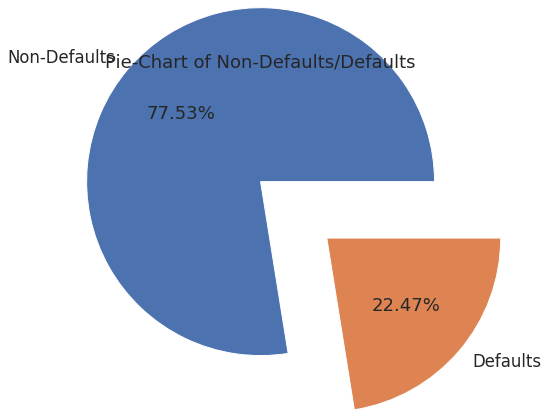

In [359]:
plt.axis('equal')
plt.pie(data_new_2['loan_default'].value_counts(),labels=['Non-Defaults','Defaults'],autopct='%0.2f%%',radius=2,explode=[0,1.0])
plt.title('Pie-Chart of Non-Defaults/Defaults')
plt.show()

Before moving ahead with the undersampling,now we'll do the train-test split so that the undersampled train dataset gives sufficiently good results for the original test dataset,proving it's validity and tenacity.

In [360]:
# We've to do a stratified sampling so that the proportion of defaults remains same in both train and test sets.
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,random_state=42,test_size=0.15)

In [361]:
print(X_train.shape)
print(X_test.shape)

(161370, 37)
(28478, 37)


In [362]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [363]:
y_test.head()

0    0
1    0
2    0
3    0
4    0
Name: loan_default, dtype: int64

### Undersampling :

#### The results obtained by applying NearMiss undersampling algorithm generate poorer 'roc_auc_score' which is the parameter of evaluation here. Incase, one is interested in using the same, the code is provided as follows :

In [ ]:
nm = NearMiss(sampling_strategy=1, version=3, n_neighbors=1, n_neighbors_ver3=3, n_jobs=-1)
X_train_nm, y_train_nm = nm.fit_sample(X_train,y_train)

In [ ]:
X_train_nm.shape

In [ ]:
# We've to do a stratified sampling so that the proportion of defaults remains same in both train and test sets.
'''X_train,X_test,y_train,y_test = train_test_split(X_resampled_nm,y_resampled_nm,stratify=y_resampled_nm,random_state=42,test_size=0.2)'''

In [ ]:
print(y_train_nm.value_counts()/len(y_train_nm))
print(y_test.value_counts()/len(y_test))

In [ ]:
print(y_train_nm.value_counts()/y_train_nm.shape[0])

#### Thus,the proportion of defaults is maintained in both train and test sets.

### Power Transformation : (Yeo Johnson)

In [ ]:
'''pt = PowerTransformer(method='yeo-johnson')

# For X_train,X_test :
pt.fit(X_train)
powerTransformed_train = pt.transform(X_train) 
powerTransformed_test = pt.transform(X_test)'''

In [ ]:
'''X_train_pT = pd.DataFrame(powerTransformed_train, index=X_train.index, columns=X_train.columns)
X_test_pT = pd.DataFrame(powerTransformed_test, index=X_test.index, columns=X_test.columns)'''

In [ ]:
#X_train_pT.head()

#### The values after power transformation aren't making sense. So we'll not employ powertransformation and check the results.

In [ ]:
'''for i in list(X_train_pT[['disbursed_amount','asset_cost','ltv','TOTAL_NO_OF_ACCTS','TOTAL_ACTIVE_ACCTS','TOTAL_OVERDUE_ACCTS','OVERALL_CURRENT_BALANCE','OVERALL_DISBURSED_AMOUNT','TOTAL_INSTAL_AMT','Age(in years)']].columns):
    sns.distplot(X_train_pT[i])
    plt.show()'''

In [ ]:
'''len(list(X_train_nm.columns))'''

### Scaling :

### For Class Weight balanced :

#### The variables are not scaled, in order to keep them practically interpretable, with reality. However,the code for scaling is provided below in case one feels using the same .

In [ ]:
#Standardising the coloumns :
scaler = MinMaxScaler()
X_train[['disbursed_amount','ltv','PERFORM_CNS.SCORE','TOTAL_NO_OF_ACCTS','TOTAL_ACTIVE_ACCTS','TOTAL_OVERDUE_ACCTS','OVERALL_CURRENT_BALANCE', 'OVERALL_DISBURSED_AMOUNT', 'Age(in years)',
       'CREDIT.HISTORY.LENGTH (in years)']] = scaler.fit_transform(X_train[['disbursed_amount','ltv','PERFORM_CNS.SCORE','TOTAL_NO_OF_ACCTS','TOTAL_ACTIVE_ACCTS','TOTAL_OVERDUE_ACCTS','OVERALL_CURRENT_BALANCE', 'OVERALL_DISBURSED_AMOUNT', 'Age(in years)',
       'CREDIT.HISTORY.LENGTH (in years)']])

In [ ]:
X_test[['disbursed_amount','ltv','PERFORM_CNS.SCORE','TOTAL_NO_OF_ACCTS','TOTAL_ACTIVE_ACCTS','TOTAL_OVERDUE_ACCTS','OVERALL_CURRENT_BALANCE', 'OVERALL_DISBURSED_AMOUNT','Age(in years)',
       'CREDIT.HISTORY.LENGTH (in years)']] = scaler.transform(X_test[['disbursed_amount','ltv','PERFORM_CNS.SCORE','TOTAL_NO_OF_ACCTS','TOTAL_ACTIVE_ACCTS','TOTAL_OVERDUE_ACCTS','OVERALL_CURRENT_BALANCE', 'OVERALL_DISBURSED_AMOUNT', 'Age(in years)',
       'CREDIT.HISTORY.LENGTH (in years)']])

### For UnderSampled data :

In [ ]:
#Standardising the coloumns :
scaler = MinMaxScaler()
X_train_nm[['disbursed_amount','ltv','PERFORM_CNS.SCORE','TOTAL_NO_OF_ACCTS','TOTAL_ACTIVE_ACCTS','TOTAL_OVERDUE_ACCTS','OVERALL_CURRENT_BALANCE', 'OVERALL_DISBURSED_AMOUNT', 'Age(in years)',
       'CREDIT.HISTORY.LENGTH (in years)']] = scaler.fit_transform(X_train_nm[['disbursed_amount','ltv','PERFORM_CNS.SCORE','TOTAL_NO_OF_ACCTS','TOTAL_ACTIVE_ACCTS','TOTAL_OVERDUE_ACCTS','OVERALL_CURRENT_BALANCE', 'OVERALL_DISBURSED_AMOUNT', 'Age(in years)',
       'CREDIT.HISTORY.LENGTH (in years)']])

In [ ]:
X_test[['disbursed_amount','ltv','PERFORM_CNS.SCORE','TOTAL_NO_OF_ACCTS','TOTAL_ACTIVE_ACCTS','TOTAL_OVERDUE_ACCTS','OVERALL_CURRENT_BALANCE', 'OVERALL_DISBURSED_AMOUNT','Age(in years)',
       'CREDIT.HISTORY.LENGTH (in years)']] = scaler.transform(X_test[['disbursed_amount','ltv','PERFORM_CNS.SCORE','TOTAL_NO_OF_ACCTS','TOTAL_ACTIVE_ACCTS','TOTAL_OVERDUE_ACCTS','OVERALL_CURRENT_BALANCE', 'OVERALL_DISBURSED_AMOUNT', 'Age(in years)',
       'CREDIT.HISTORY.LENGTH (in years)']])

### Modelling :

### 1) Decision Tree Modelling :

In [ ]:
params = {"max_depth": [7,8,9],
          "criterion":['gini'],
          'max_features':[25,26,27],
          'min_samples_leaf': [2,5,8],
         'min_samples_split': [20,21,22,23]}

In [ ]:
dtree = DecisionTreeClassifier(random_state=42)
dtree_model_cv = GridSearchCV(estimator = dtree, 
                        param_grid = params, 
                        scoring= 'f1_macro', 
                        cv = 5, 
                        return_train_score=True,
                        n_jobs=-1)            
dtree_model_cv.fit(X_train_nm, y_train_nm) 

In [ ]:
print(dtree_model_cv.best_score_)
print(dtree_model_cv.best_params_)

In [ ]:
print(dtree_model_cv.best_score_)
print(dtree_model_cv.best_params_)

In [ ]:
print(dtree_model_cv.best_score_)
print(dtree_model_cv.best_params_)

#### The best results were obtained with :
- Criterion : 'Gini'
- max_depth : 8
- max_features : 26
- min_samples_leaf : 8
- min_samples_split : 22

#### Pydotplus tree using Graphviz is still left

### 2) RandomForest Classification :

### For class weight balanced data :

In [ ]:
rf = RandomForestClassifier(n_jobs=-1,random_state=42)
param_grid = {'max_depth':[6,7,8,9],
              'n_estimators':[100,125,150],
             'max_features':[0.4],
              "criterion":['gini'],
              'max_samples' : [0.7],
              'class_weight' : ['balanced']
          #'min_samples_leaf': [7,10,15],
         #'min_samples_split': [25,30,35]
             } 
rf_model_cv = GridSearchCV(estimator = rf,param_grid=param_grid,cv = 5,scoring = 'roc_auc', n_jobs=-1)
rf_model_cv.fit(X_train,y_train)

In [364]:
rf = RandomForestClassifier(n_estimators = 125,max_depth = 9,max_features = 0.4,criterion='gini',max_samples=0.8,class_weight='balanced',random_state=42,n_jobs=-1)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print(roc_auc_score(y_test,y_pred))
print(f1_score(y_test,y_pred,average='macro'))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred)) 

0.5916979193565924
0.5391450933200744
0.5839244328955685
              precision    recall  f1-score   support

           0       0.83      0.58      0.68     22080
           1       0.29      0.61      0.40      6398

    accuracy                           0.58     28478
   macro avg       0.56      0.59      0.54     28478
weighted avg       0.71      0.58      0.62     28478



In [365]:
y_probs = rf.predict_proba(X_test)[:,1]
y_probs # Probabilities of the various instances to default.

array([0.60509587, 0.41880775, 0.49092249, ..., 0.48167769, 0.37607417,
       0.35677551])

### Building ROC_AUC_Curve :

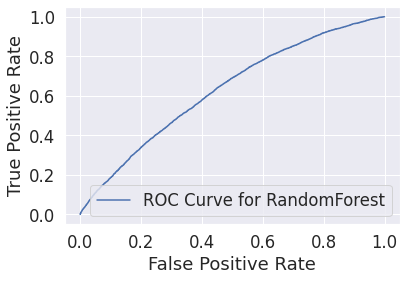

In [366]:
rf_fpr,rf_tpr,_ = roc_curve(y_test,y_probs)
rf_roc = roc_auc_score(y_test,y_pred)
plt.plot(rf_fpr,rf_tpr,label='ROC Curve for RandomForest' %rf_roc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [367]:
coef_df = pd.DataFrame()
coef_df['Columns'] = list(X_train.columns)
coef_df['Coefficients'] = pd.Series(rf.feature_importances_)
coef_df

Columns  Coefficients
0                                     disbursed_amount      0.130152
1                                           asset_cost      0.065523
2                                                  ltv      0.219915
3                                    PERFORM_CNS.SCORE      0.126473
4                                    TOTAL_NO_OF_ACCTS      0.026112
5                                   TOTAL_ACTIVE_ACCTS      0.014277
6                                  TOTAL_OVERDUE_ACCTS      0.028192
7                              OVERALL_CURRENT_BALANCE      0.035841
8                             OVERALL_DISBURSED_AMOUNT      0.046653
9                                     TOTAL_INSTAL_AMT      0.038248
10                                       Age(in years)      0.056436
11                         AVERAGE.ACCT.AGE (in years)      0.027519
12                    CREDIT.HISTORY.LENGTH (in years)      0.037780
13                                 manufacturer_id_120      0.002177
14                                 manufacturer_id_145      0.000306
15                                  manufacturer_id_45      0.003486
16                                  manufacturer_id_48      0.022267
17                                  manufacturer_id_49      0.001515
18                                  manufacturer_id_51      0.002132
19                                  manufacturer_id_67      0.000146
20                                  manufacturer_id_86      0.017726
21                             Employment.Type_Missing      0.001438
22                            Employment.Type_Salaried      0.014865
23                       Employment.Type_Self employed      0.016410
24                      NEW.ACCTS.IN.LAST.SIX.MONTHS_0      0.004543
25                      NEW.ACCTS.IN.LAST.SIX.MONTHS_1      0.002552
26                      NEW.ACCTS.IN.LAST.SIX.MONTHS_2      0.001739
27                      NEW.ACCTS.IN.LAST.SIX.MONTHS_3      0.000978
28           NEW.ACCTS.IN.LAST.SIX.MONTHS_4 or greater      0.000704
29               DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS_0      0.012356
30               DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS_1      0.005064
31  DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS_Greater than 1      0.001104
32                                   NO.OF_INQUIRIES_0      0.024706
33                                   NO.OF_INQUIRIES_1      0.003213
34                                   NO.OF_INQUIRIES_2      0.002540
35                                   NO.OF_INQUIRIES_3      0.001231
36                        NO.OF_INQUIRIES_4 or greater      0.003683

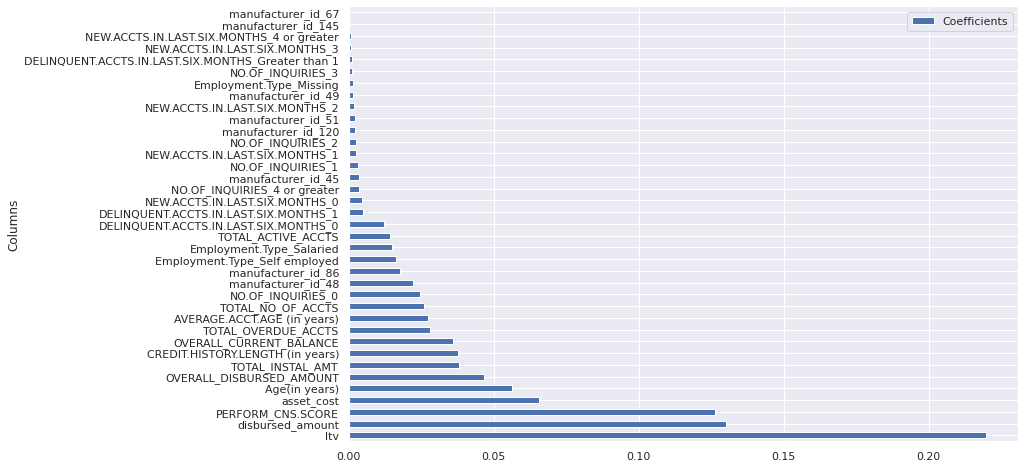

In [368]:
coef_df = coef_df.sort_values(by='Coefficients',ascending=False)
coef_df = coef_df.reset_index(drop=True)
coef_df = coef_df.set_index('Columns')
sns.set(font_scale=1)
coef_df.plot(kind='barh',figsize=(12,8))
plt.show()

#### Thus,the best results were obtained with :
- Criterion : 'Gini'
- n_estimators : 58
- max_depth : 9
- max_features : 0.7 (70%,i.e.27)
- min_samples_leaf : 9
- min_samples_split : 20

### 4) AdaBoosting Classifier :

In [ ]:
adab.get_params().keys()

In [ ]:
from sklearn import metrics
metrics.SCORERS.keys()

In [ ]:
param_grid = {
        'learning_rate': [0.1,0.5] ,
        'base_estimator__max_depth': [3,4,5],
        'n_estimators':[100],
        'base_estimator__max_features':[0.4,0.5],
    'algorithm' : ['SAMME','SAMME.R']
}

tree = DecisionTreeClassifier(class_weight='balanced',random_state=42)
adab = AdaBoostClassifier(base_estimator=tree,random_state=42)
adab_model_cv = GridSearchCV(estimator = adab,param_grid=param_grid,cv = 5,scoring = 'roc_auc',n_jobs=-1)
adab_model_cv.fit(X_train,y_train)

In [ ]:
print(adab_model_cv.best_score_)
print(adab_model_cv.best_params_)

In [ ]:
tree = DecisionTreeClassifier(max_depth=9,max_features=0.4,criterion='gini',random_state=42)
adab = AdaBoostClassifier(base_estimator=tree,algorithm='SAMME.R',learning_rate = 0.3,n_estimators = 100,random_state=42)
adab.fit(X_train,y_train)
y_pred = adab.predict(X_test)
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))
print(f1_score(y_test,y_pred,average='macro'))
#print(accuracy_score(y_test,y_pred))
#print(classification_report(y_test,y_pred))

In [ ]:
tree = DecisionTreeClassifier(max_depth=9,max_features=0.3,criterion='gini',random_state=42)
adab = AdaBoostClassifier(base_estimator=tree,algorithm='SAMME.R',learning_rate = 0.3,n_estimators = 100,random_state=42)
adab.fit(X_train,y_train)
y_pred = adab.predict(X_test)
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))
print(f1_score(y_test,y_pred,average='macro'))
print(accuracy_score(y_test,y_pred))
#print(classification_report(y_test,y_pred))

In [ ]:
print(accuracy_score(y_test,y_pred))

In [ ]:
tree = DecisionTreeClassifier(max_depth=9,max_features=0.3,criterion='gini',random_state=42)
adab = AdaBoostClassifier(base_estimator=tree,algorithm='SAMME.R',learning_rate = 0.3,n_estimators = 100,random_state=42)
adab.fit(X_train,y_train)

### 6) Artificial Neural Networks :

#### Using class_weight = 'balanced' for the data :

In [ ]:
y_train_new = pd.Series(y_train,name='Default')
y_test_new = pd.Series(y_test,name='Default')
y_train_new = pd.get_dummies(y_train_new,columns=['Default'])
y_test_new = pd.get_dummies(y_test_new,columns=['Default'])

In [ ]:
# Initializing the ANN
ann = tf.keras.models.Sequential()
# Adding the input and 1st hidden layer
ann.add(tf.keras.layers.Dense(units=5,input_dim=34,activation='relu'))
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))

# Adding 2nd hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))

# Adding 3rd hidden layer
#ann.add(tf.keras.layers.Dense(units=4, activation='relu'))

# Adding the output layer
ann.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))

In [ ]:
print(y_train[y_train==0].shape)
print(y_train[y_train==1].shape)
print(y_train.shape)

In [ ]:
weight_for_0 =  (1/125114)*(161370/2)
weight_for_1 =  (1/36256)*(161370/2)

In [ ]:
weight_for_1

In [ ]:
weight_for_0

In [ ]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
ann.fit(X_train, y_train, batch_size = 32, epochs = 100,class_weight = {0 : weight_for_0,1 : weight_for_1},verbose=0)

In [ ]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
ann.fit(X_train, y_train_new, batch_size = 32, epochs = 100,verbose=0)

In [ ]:
y_probs_ann = ann.predict_proba(X_test)

In [ ]:
#ann_roc = roc_auc_score(y_test,y_probs)
ann_fpr,ann_tpr,_ = roc_curve(y_test,y_probs_ann)
plt.plot(ann_fpr,ann_tpr,label='ROC Curve for ANN' %ann_roc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
# With 5 neurons each in the 2 hidden layers
print(precision_score(y_test_new,y_pred))
print(recall_score(y_test_new,y_pred))
print(roc_auc_score(y_test_new,y_pred))
print(f1_score(y_test_new,y_pred,average='macro'))
# Ans : 0.5941847698669421

In [ ]:
y_pred_1 = abs(y_pred[:,0])
y_pred_2 = abs(y_pred[:,1])

In [ ]:
(y_pred_2 > 0.5).sum()

In [ ]:
y_pred_1 = abs(y_pred)
y_pred_1

In [ ]:
y_pred = (y_probs > 0.5)

In [ ]:
y_pred_1

In [ ]:
# With single output
roc_auc_score(y_test,y_pred_1)

In [ ]:
# With 5 neurons each in the 3 hidden layers
roc_auc_score(y_test,y_pred)

In [ ]:
# With 4 neurons each in the 3 hidden layers
roc_auc_score(y_test,y_pred)

In [ ]:
# With 4 neurons each in the 2 hidden layers
roc_auc_score(y_test,y_pred)
# Ans : 0.5905335212883555

In [ ]:
# With 5 neurons each in the 2 hidden layers
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))
print(f1_score(y_test,y_pred,average='macro'))
# Ans : 0.5941847698669421

In [ ]:
# With 5 neurons in first layer and relu,4 in 2nd and relu, 1 in output and sigmoid
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))
print(f1_score(y_test,y_pred,average='macro'))
print(accuracy_score(y_test,y_pred))
# Ans : 0.5941847698669421

In [ ]:
# With 5 neurons each in the 2 hidden layers
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))
print(f1_score(y_test,y_pred,average='macro'))
print(roc_auc_score(y_test,y_pred))
# Ans : 0.5941847698669421

In [ ]:
# With 5neurons each in 2 hidden layers and 4 in 3rd
roc_auc_score(y_test,y_pred)

In [ ]:
# With 5 neurons in 1 hidden layer, 4 in second and 3 in third
roc_auc_score(y_test,y_pred)

In [ ]:
# With 5 neurons each in 2 hidden layers and 4 in 3rd
roc_auc_score(y_test,y_pred)

### Applying LIME to RandomForest Model :

In [369]:
predict_fn_rf = lambda x: rf.predict_proba(x).astype(float)
X = X_train.values
explainer = lime.lime_tabular.LimeTabularExplainer(X,feature_names = X_train.columns,class_names=[0,1],kernel_width=5)

### Explaining an instance :

### Let's choose a random instance, say record number(row number) 420 :

In [370]:
X_test.loc[[420]]

disbursed_amount  asset_cost    ltv  PERFORM_CNS.SCORE  \
420             53303       67394  80.13                709   

     TOTAL_NO_OF_ACCTS  TOTAL_ACTIVE_ACCTS  TOTAL_OVERDUE_ACCTS  \
420                  4                   2                    0   

     OVERALL_CURRENT_BALANCE  OVERALL_DISBURSED_AMOUNT  TOTAL_INSTAL_AMT  \
420                   300527                    448990             10721   

     Age(in years)  AVERAGE.ACCT.AGE (in years)  \
420          41.78                         2.57   

     CREDIT.HISTORY.LENGTH (in years)  manufacturer_id_120  \
420                              4.08                    0   

     manufacturer_id_145  manufacturer_id_45  manufacturer_id_48  \
420                    0                   0                   0   

     manufacturer_id_49  manufacturer_id_51  manufacturer_id_67  \
420                   0                   0                   0   

     manufacturer_id_86  Employment.Type_Missing  Employment.Type_Salaried  \
420                   1                        0                         1   

     Employment.Type_Self employed  NEW.ACCTS.IN.LAST.SIX.MONTHS_0  \
420                              0                               0   

     NEW.ACCTS.IN.LAST.SIX.MONTHS_1  NEW.ACCTS.IN.LAST.SIX.MONTHS_2  \
420                               1                               0   

     NEW.ACCTS.IN.LAST.SIX.MONTHS_3  \
420                               0   

     NEW.ACCTS.IN.LAST.SIX.MONTHS_4 or greater  \
420                                          0   

     DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS_0  \
420                                      1   

     DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS_1  \
420                                      0   

     DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS_Greater than 1  NO.OF_INQUIRIES_0  \
420                                                   0                  1   

     NO.OF_INQUIRIES_1  NO.OF_INQUIRIES_2  NO.OF_INQUIRIES_3  \
420                  0                  0                  0   

     NO.OF_INQUIRIES_4 or greater  
420                             0

In [371]:
y_test.loc[[420]]

420    0
Name: loan_default, dtype: int64

#### So it can be seen that the record has a label 0, or it's a non-default case basically.

In [372]:
chosen_instance = X_test.loc[[420]].values[0]
exp = explainer.explain_instance(chosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_all=False)
#exp.show_in_notebook(show_all=False)

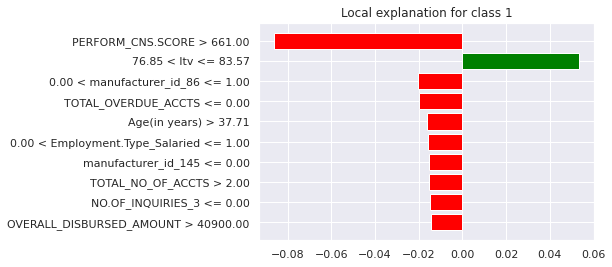

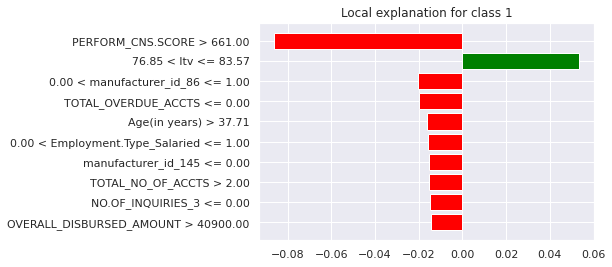

In [373]:
exp.as_pyplot_figure(label= 1)

Thus, firstly the model correctly predicts the chosen instance as having a greater probability to 
not default(0.66), as compared to default (0.34). And secondly, it explains the various contributing factors behind it. For 
example :
- A PERFORM_CNS.SCORE (CIBIL Score) of 709, which is greater than 661 gives it a probability of 0.09 
(9%) to not default.
- Similarly, a loan to value ratio (ltv) of 80.13, which is between 76.85 and 83.57 gives it 
a probability of 0.05 (5%) to default. And the same goes for all other features.
The same interpretation can be achieved for any other instance in the dataset for this particular 
model.

### Let's choose another instance. Say instance number(record/row number) 5,which is actually a case of default or 1 :

In [374]:
y_test.loc[[5]]

5    1
Name: loan_default, dtype: int64

In [375]:
X_test.loc[[5]]

disbursed_amount  asset_cost    ltv  PERFORM_CNS.SCORE  TOTAL_NO_OF_ACCTS  \
5             52500       65800  82.07                  0                  0   

   TOTAL_ACTIVE_ACCTS  TOTAL_OVERDUE_ACCTS  OVERALL_CURRENT_BALANCE  \
5                   0                    0                        0   

   OVERALL_DISBURSED_AMOUNT  TOTAL_INSTAL_AMT  Age(in years)  \
5                         0                 0          27.64   

   AVERAGE.ACCT.AGE (in years)  CREDIT.HISTORY.LENGTH (in years)  \
5                          0.0                               0.0   

   manufacturer_id_120  manufacturer_id_145  manufacturer_id_45  \
5                    0                    0                   0   

   manufacturer_id_48  manufacturer_id_49  manufacturer_id_51  \
5                   0                   0                   0   

   manufacturer_id_67  manufacturer_id_86  Employment.Type_Missing  \
5                   0                   1                        0   

   Employment.Type_Salaried  Employment.Type_Self employed  \
5                         1                              0   

   NEW.ACCTS.IN.LAST.SIX.MONTHS_0  NEW.ACCTS.IN.LAST.SIX.MONTHS_1  \
5                               1                               0   

   NEW.ACCTS.IN.LAST.SIX.MONTHS_2  NEW.ACCTS.IN.LAST.SIX.MONTHS_3  \
5                               0                               0   

   NEW.ACCTS.IN.LAST.SIX.MONTHS_4 or greater  \
5                                          0   

   DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS_0  \
5                                      1   

   DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS_1  \
5                                      0   

   DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS_Greater than 1  NO.OF_INQUIRIES_0  \
5                                                   0                  1   

   NO.OF_INQUIRIES_1  NO.OF_INQUIRIES_2  NO.OF_INQUIRIES_3  \
5                  0                  0                  0   

   NO.OF_INQUIRIES_4 or greater  
5                             0

In [376]:
chosen_instance = X_test.loc[[5]].values[0]
exp = explainer.explain_instance(chosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_table=True)
#exp.show_in_notebook(show_all=False)

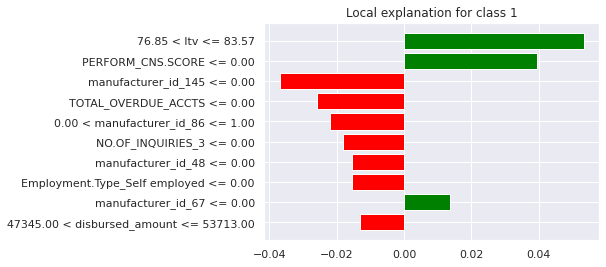

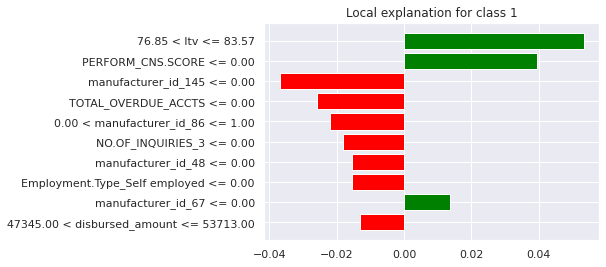

In [377]:
exp.as_pyplot_figure(label=1)

### Hence just like the above case 420, the same explanation can be seen for this case as well.

### So in this manner, interpretable models can be created for any Machine Learning algorithm which produces probability as a measure (except ANN in this case).

### Creation of a Scoring System to actually implement the ML model in realtime :

The scoring system used will be one very commonly used in the Banking Industry worldwide, namely, “Points to Double the Odds”(PDO).
This scoring is based on the probabilities of the same model 
which has been made interpretable using LIME. And thus, the scores/points obtained are 
transparent and more interpretable than any scoring which is obtained using the traditional black 
box kind of ML algorithms. Also on account of having CIBIL score as a feature in the model, 
it’s not missing out on the information provided there as well.

### New Scoring : Points To Double the Odds :

In [378]:
# Predicting the probabilities predicted by RandomForest model :
y_pred_proba = rf.predict_proba(X_test)

# Creating a new dataframe for scoring :
new_scores = pd.DataFrame()

In [379]:
new_scores

Empty DataFrame
Columns: []
Index: []

In [380]:
y_pred_proba[: , 0]

array([0.39490413, 0.58119225, 0.50907751, ..., 0.51832231, 0.62392583,
       0.64322449])

In [381]:
 # Calculating log of odds of non-default :
new_scores['p_non_default'] = y_pred_proba[: , 0]  # Probability of non-defaults
new_scores['p_default'] = y_pred_proba[: , 1]  # Probability of defaults
new_scores['Odds non-default'] = new_scores['p_non_default'] /new_scores['p_default'] # Calculating the odds of non-default
new_scores['ln Odds'] = np.log(new_scores['Odds non-default']) # Calculating the log of odds of non-default 

In [382]:
new_scores.head(10)

p_non_default  p_default  Odds non-default   ln Odds
0       0.394904   0.605096          0.652631 -0.426744
1       0.581192   0.418808          1.387730  0.327670
2       0.509078   0.490922          1.036981  0.036314
3       0.352288   0.647712          0.543896 -0.608998
4       0.493546   0.506454          0.974511 -0.025819
5       0.435986   0.564014          0.773005 -0.257470
6       0.443644   0.556356          0.797410 -0.226386
7       0.413749   0.586251          0.705755 -0.348488
8       0.464049   0.535951          0.865842 -0.144053
9       0.416328   0.583672          0.713291 -0.337866

In [383]:
# Calculating new scores doubling every 20 points with baseline 400 :
new_scores['Score'] = 400 + 20*(new_scores['ln Odds'] / np.log(2))
new_scores['Score'] = round(new_scores['Score'],0)
new_scores.head()

p_non_default  p_default  Odds non-default   ln Odds  Score
0       0.394904   0.605096          0.652631 -0.426744  388.0
1       0.581192   0.418808          1.387730  0.327670  409.0
2       0.509078   0.490922          1.036981  0.036314  401.0
3       0.352288   0.647712          0.543896 -0.608998  382.0
4       0.493546   0.506454          0.974511 -0.025819  399.0

### The 'Score' column shown in the dataset 'new_scores' represents the set of scores generated for each individual case using our model.